# <center>Using 1d CNN-based GAN to generate ECGs</center>
## <center>In this experiment GAN is used to create synthetic 12-kead ECGs and compare them with 12 Lead ECGs from the PTB-XL Dataset</center>

In [2]:
import numpy as np, sys,os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
import wfdb
import tarfile
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import StratifiedKFold
from keras.utils import pad_sequences
import math
import warnings
import os
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from scipy import signal
from tqdm import tqdm

In [2]:
def load_challenge_data(filename):
    """Load ECG files"""
    x = loadmat(filename)
    data = np.asarray(x['val'], dtype=np.float64)
    new_file = filename.replace('.mat','.hea')
    input_header_file = os.path.join(new_file)
    with open(input_header_file,'r') as f:
        header_data=f.readlines()
    return data, header_data


def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

In [3]:
def downsample_ecg(ecg, samples=1000, leads=12):
    """Function used to downsample ECGs from 500Hz to 100Hz"""
    new_ecg = np.zeros((samples,leads))
    for i,j in enumerate(ecg):
        new_ecg[:,i] = signal.resample(j,samples)
    return new_ecg

In [4]:
# Import ECGs to RAM
print("Importing real ECGs..")
ECGs = []
for ecgfilename in tqdm(sorted(os.listdir("/kaggle/input/ptbxl-electrocardiography-database/WFDB/"))):
    if ecgfilename.endswith(".mat"):
        data = load_challenge_data("/kaggle/input/ptbxl-electrocardiography-database/WFDB/" + ecgfilename)[0]
        ECGs.append(downsample_ecg(data))
ECGs = np.asarray(ECGs)

# Convert ECG unit from microvolt to millivolt
ECGs= ECGs/1000

print("A total of {} ECGs were loaded".format(len(ECGs)))

Importing real ECGs..


100%|██████████| 43674/43674 [04:41<00:00, 154.99it/s]


A total of 21837 ECGs were loaded


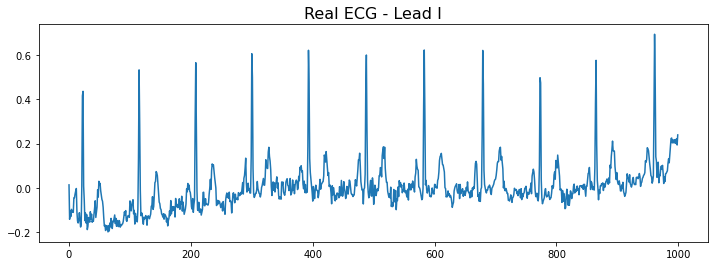

In [5]:
plt.figure(figsize=(12,4))
plt.title("Real ECG - Lead I", fontsize=16)
plt.plot(ECGs[0,:,0])
plt.show()

In [6]:
# generate n real samples with class labels
def generate_real_samples(ecgsignal,n):
    """Randomly pick n real ECG samples from the dataset and return it together with an array of n ones """
    # generate inputs in [-0.5, 0.5]
    X = ecgsignal[np.random.choice(ecgsignal.shape[0],n)]
    # generate class labels
    y = tf.ones((n, 1))
    return X, y
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
    """Generate random numbers used as input to the generator """
    # generate points in the latent space
    x_in = np.random.randn(latent_dim*n).reshape(n,latent_dim)
    # reshape into a batch of inputs for the network
    return np.expand_dims(x_in,1)
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(latent_dim,generator,n):
    """Use the generator to generate fake ECGs"""
    # generate points in latent space
    x_input = generate_latent_points(latent_dim,n)
    # predict outputs
    X = generator(x_input)
    # create class labels
    y = np.zeros((n, 1))
    return X, y

def compare_real_and_gen_ecg(generated_ecg):
    """Plot real and generated ECGs side by side"""
    plt.figure(figsize=(24,4))
    plt.subplot(1,2,1)
    plt.title("Generated (fake) ECG - Lead I", fontsize=16)
    plt.plot(generated_ecg[0,:,0])
    plt.subplot(1,2,2)
    plt.title("Real ECG - Lead I", fontsize=16)
    rand_idx = np.random.choice(np.arange(len(ECGs)))
    plt.plot(ECGs[rand_idx,:,0])
    plt.show()

In [3]:
def _inception_module(
    input_tensor,
    stride=1,
    activation="linear",
    use_bottleneck=True,
    kernel_size=40,
    bottleneck_size=32,
    nb_filters=32,
):

    if use_bottleneck and int(input_tensor.shape[-1]) > 1:
        input_inception = tf.keras.layers.Conv1D(
            filters=bottleneck_size,
            kernel_size=1,
            padding="same",
            activation=activation,
            use_bias=False,
        )(input_tensor)
    else:
        input_inception = input_tensor

    # kernel_size_s = [3, 5, 8, 11, 17]
    kernel_size_s = [kernel_size // (2**i) for i in range(3)]

    conv_list = []

    for i in range(len(kernel_size_s)):
        conv_list.append(
            tf.keras.layers.Conv1D(
                filters=nb_filters,
                kernel_size=kernel_size_s[i],
                strides=stride,
                padding="same",
                activation=activation,
                use_bias=False,
            )(input_inception)
        )

    max_pool_1 = tf.keras.layers.MaxPool1D(pool_size=3, strides=stride, padding="same")(
        input_tensor
    )

    conv_6 = tf.keras.layers.Conv1D(
        filters=nb_filters,
        kernel_size=1,
        padding="same",
        activation=activation,
        use_bias=False,
    )(max_pool_1)

    conv_list.append(conv_6)

    x = tf.keras.layers.Concatenate(axis=2)(conv_list)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation="relu")(x)
    return x


def _shortcut_layer(input_tensor, out_tensor):
    shortcut_y = tf.keras.layers.Conv1D(
        filters=int(out_tensor.shape[-1]), kernel_size=1, padding="same", use_bias=False
    )(input_tensor)
    shortcut_y = tf.keras.layers.BatchNormalization()(shortcut_y)

    x = tf.keras.layers.Add()([shortcut_y, out_tensor])
    x = tf.keras.layers.Activation("relu")(x)
    return x


def discriminator(
    input_shape = (1000,12),
    nb_classes=1,
    depth: int = 1,
    use_residual: bool = True,
)-> tf.keras.models.Model:
    """
    Model proposed by HI Fawas et al 2019 "Finding AlexNet for Time Series Classification - InceptionTime"
    """
    input_layer = tf.keras.layers.Input(input_shape)

    x = input_layer
    input_res = input_layer

    for d in range(depth):

        x = _inception_module(x)

        if use_residual and d % 3 == 2:
            x = _shortcut_layer(input_res, x)
            input_res = x

    gap_layer = tf.keras.layers.GlobalAveragePooling1D()(x)

    output_layer = tf.keras.layers.Dense(units=nb_classes, activation="sigmoid")(
        gap_layer
    )

    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
    model.compile(
        loss=tf.keras.losses.MeanAbsoluteError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=[tf.keras.metrics.MeanSquaredError()],
    )

    return model



## Defining the discriminator

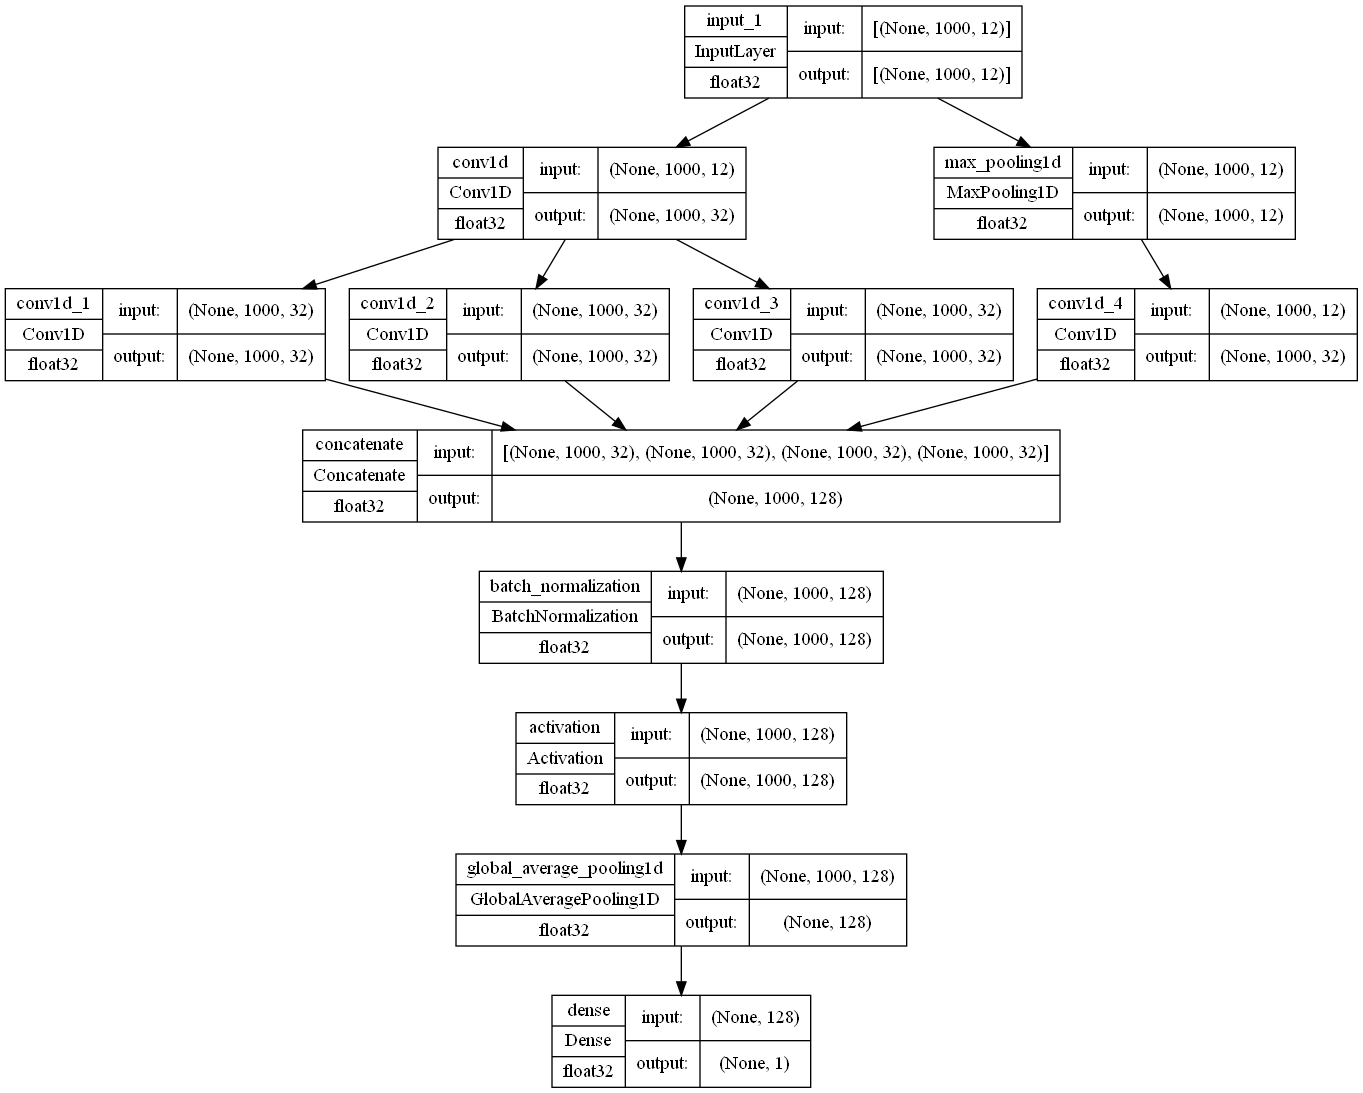

In [5]:
tf.keras.utils.plot_model(desc, to_file='inception disc.png',
    show_shapes=True,
    show_dtype=True,
)

In [10]:
desc.output_shape

(None, 1)

In [4]:
desc = discriminator()
print("Discriminator architecture:")
print(desc.summary())

Discriminator architecture:
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1000, 12)]   0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 1000, 32)     384         ['input_1[0][0]']                
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 1000, 12)     0           ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 1000, 32)     40960       ['conv1d[0][0]']                 
                                                                  

In [9]:
desc.load_weights("/kaggle/input/ecg-gan-weights/descriminator_weights_round3.h5")

In [6]:
def generator():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(12*1000, use_bias=False, input_shape=(1,12)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Reshape((1000,12)))
    assert model.output_shape == (None, 1000, 12)  # Note: None is the batch size

    model.add(tf.keras.layers.Conv1DTranspose(128, 5, strides= 1, padding='same', use_bias=False))
    assert model.output_shape == (None, 1000, 128)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv1DTranspose(64,  5, strides= 1, padding='same', use_bias=False))
    assert model.output_shape == (None, 1000, 64)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv1DTranspose(12, 5, strides=1, padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 1000, 12)
    return model

## Defining the generator

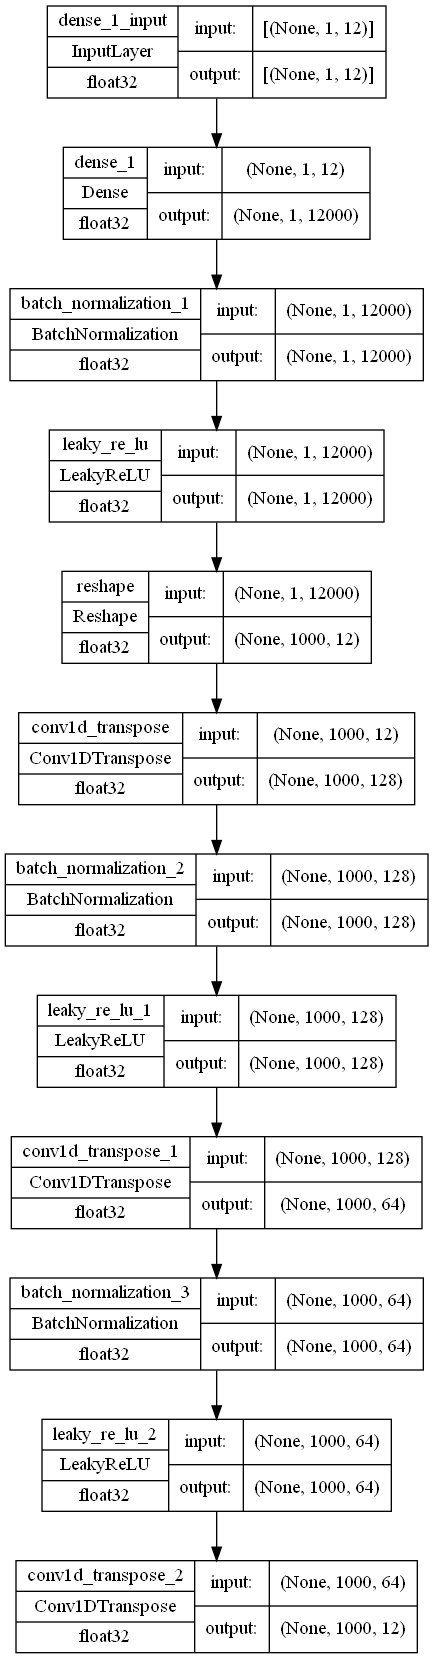

In [8]:
tf.keras.utils.plot_model(gen, to_file='gen.png',
    show_shapes=True,
    show_dtype=True,
)

In [7]:
gen = generator()
print("Generator architecture:")
print(gen.summary())

Generator architecture:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 1, 12000)          144000    
                                                                 
 batch_normalization_1 (Batc  (None, 1, 12000)         48000     
 hNormalization)                                                 
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1, 12000)          0         
                                                                 
 reshape (Reshape)           (None, 1000, 12)          0         
                                                                 
 conv1d_transpose (Conv1DTra  (None, 1000, 128)        7680      
 nspose)                                                         
                                                                 
 batch_normalization_2 (Batc  (N

In [12]:
gen.load_weights("/kaggle/input/ecg-gan-weights/generator_weights_round3.h5")

## Start training..

Before training:


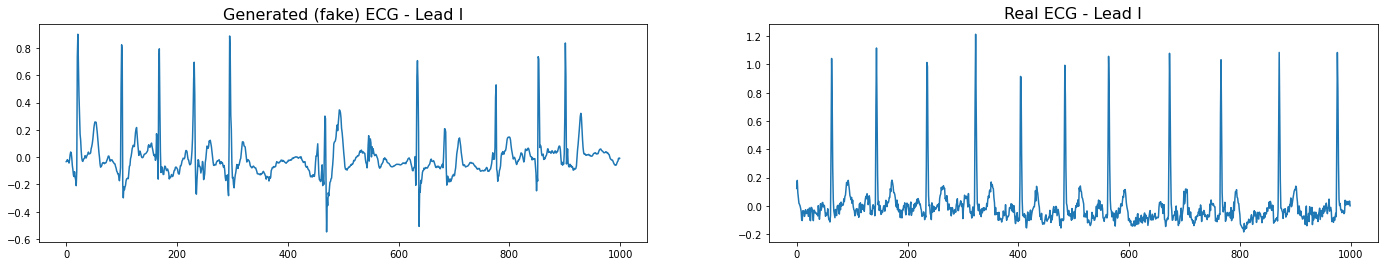

-------------------
epoch 0
Generator AUROC: 0.0
Generator loss: 0.9404898
Descriminator AUROC: 0.5859375
Descriminator loss: 0.58925825
-------------------
epoch 1


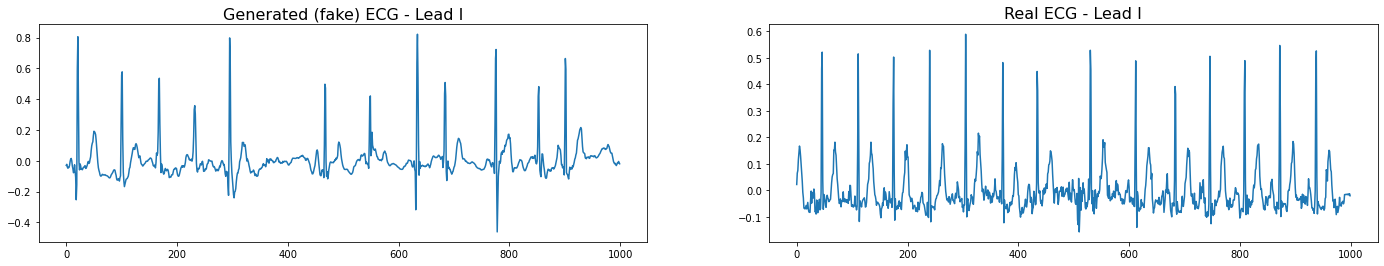

Generator AUROC: 0.0
Generator loss: 0.86806595
Descriminator AUROC: 0.67578125
Descriminator loss: 0.5813553
-------------------
epoch 2
Generator AUROC: 0.0
Generator loss: 0.8733965
Descriminator AUROC: 0.62109375
Descriminator loss: 0.57843536
-------------------
epoch 3
Generator AUROC: 0.0
Generator loss: 0.8760203
Descriminator AUROC: 0.61328125
Descriminator loss: 0.577786
-------------------
epoch 4
Generator AUROC: 0.0
Generator loss: 0.88650036
Descriminator AUROC: 0.52734375
Descriminator loss: 0.5703043
-------------------
epoch 5
Generator AUROC: 0.0
Generator loss: 0.8901822
Descriminator AUROC: 0.42578125
Descriminator loss: 0.5695089
-------------------
epoch 6


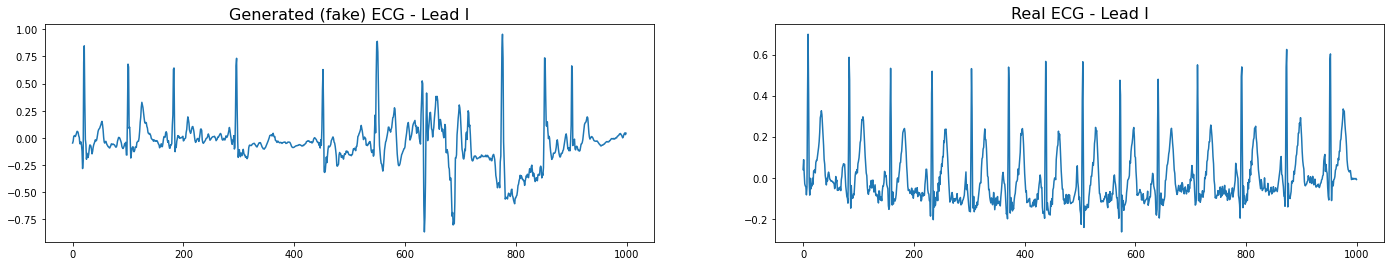

Generator AUROC: 0.0
Generator loss: 0.87730914
Descriminator AUROC: 0.6015625
Descriminator loss: 0.56655496
-------------------
epoch 7
Generator AUROC: 0.0
Generator loss: 0.881197
Descriminator AUROC: 0.52734375
Descriminator loss: 0.56583744
-------------------
epoch 8
Generator AUROC: 0.0
Generator loss: 0.8888573
Descriminator AUROC: 0.49609375
Descriminator loss: 0.5604614
-------------------
epoch 9
Generator AUROC: 0.0
Generator loss: 0.88962
Descriminator AUROC: 0.49609375
Descriminator loss: 0.56091577
-------------------
epoch 10
Generator AUROC: 0.0
Generator loss: 0.8921212
Descriminator AUROC: 0.5078125
Descriminator loss: 0.55920213
-------------------
epoch 11


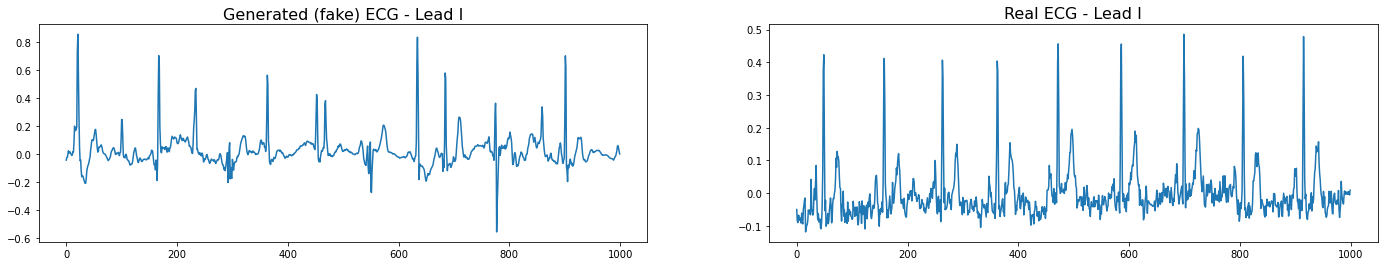

Generator AUROC: 0.0
Generator loss: 0.89086896
Descriminator AUROC: 0.50390625
Descriminator loss: 0.55938065
-------------------
epoch 12
Generator AUROC: 0.0
Generator loss: 0.89090174
Descriminator AUROC: 0.3359375
Descriminator loss: 0.55699384
-------------------
epoch 13
Generator AUROC: 0.0
Generator loss: 0.8937938
Descriminator AUROC: 0.3359375
Descriminator loss: 0.555572
-------------------
epoch 14
Generator AUROC: 0.0
Generator loss: 0.8920939
Descriminator AUROC: 0.43359375
Descriminator loss: 0.556629
-------------------
epoch 15
Generator AUROC: 0.0
Generator loss: 0.89096266
Descriminator AUROC: 0.49609375
Descriminator loss: 0.55688673
-------------------
epoch 16


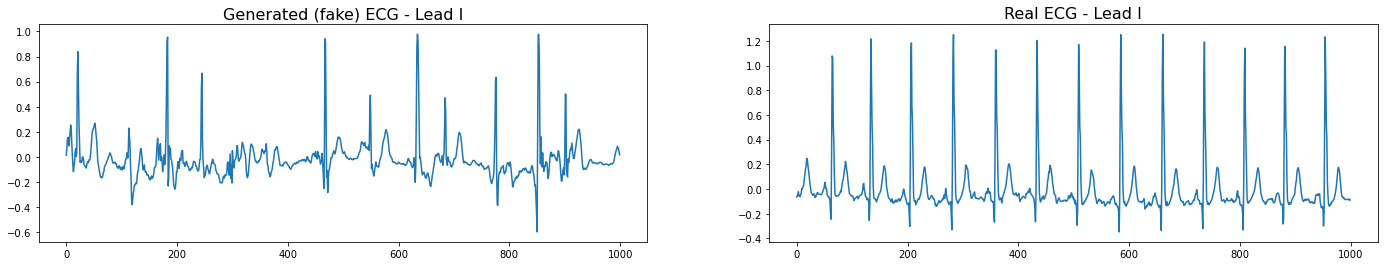

Generator AUROC: 0.0
Generator loss: 0.8974824
Descriminator AUROC: 0.74609375
Descriminator loss: 0.55177873
-------------------
epoch 17
Generator AUROC: 0.0
Generator loss: 0.89512575
Descriminator AUROC: 0.61328125
Descriminator loss: 0.5533742
-------------------
epoch 18
Generator AUROC: 0.0
Generator loss: 0.8942025
Descriminator AUROC: 0.41796875
Descriminator loss: 0.5574732
-------------------
epoch 19
Generator AUROC: 0.0
Generator loss: 0.8958596
Descriminator AUROC: 0.72265625
Descriminator loss: 0.5550899
-------------------
epoch 20
Generator AUROC: 0.0
Generator loss: 0.90004015
Descriminator AUROC: 0.38671875
Descriminator loss: 0.55132437
-------------------
epoch 21


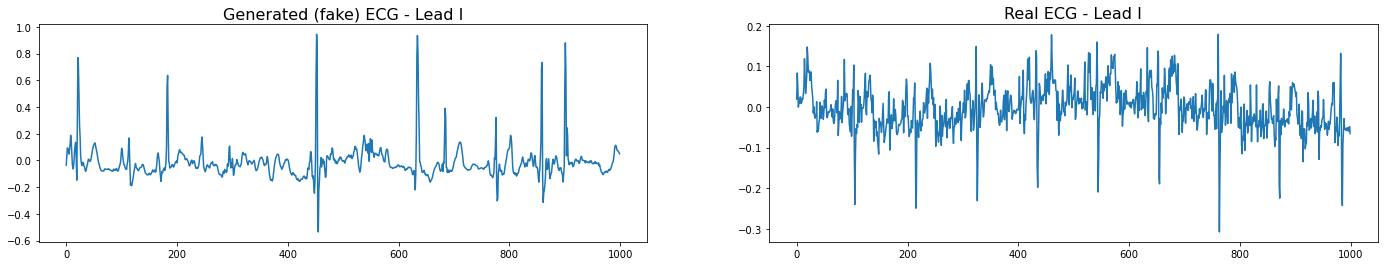

Generator AUROC: 0.0
Generator loss: 0.90295124
Descriminator AUROC: 0.55078125
Descriminator loss: 0.550197
-------------------
epoch 22
Generator AUROC: 0.0
Generator loss: 0.898859
Descriminator AUROC: 0.68359375
Descriminator loss: 0.5514574
-------------------
epoch 23
Generator AUROC: 0.0
Generator loss: 0.8975866
Descriminator AUROC: 0.5625
Descriminator loss: 0.557965
-------------------
epoch 24
Generator AUROC: 0.0
Generator loss: 0.89725804
Descriminator AUROC: 0.68359375
Descriminator loss: 0.5545532
-------------------
epoch 25
Generator AUROC: 0.0
Generator loss: 0.89862955
Descriminator AUROC: 0.34375
Descriminator loss: 0.55157906
-------------------
epoch 26


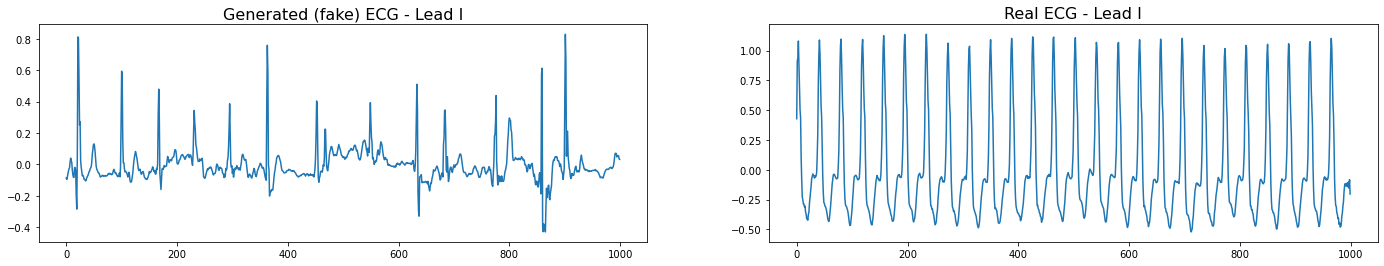

Generator AUROC: 0.0
Generator loss: 0.89802754
Descriminator AUROC: 0.51953125
Descriminator loss: 0.55407965
-------------------
epoch 27
Generator AUROC: 0.0
Generator loss: 0.89875317
Descriminator AUROC: 0.51171875
Descriminator loss: 0.5536753
-------------------
epoch 28
Generator AUROC: 0.0
Generator loss: 0.89670944
Descriminator AUROC: 0.44921875
Descriminator loss: 0.55185646
-------------------
epoch 29
Generator AUROC: 0.0
Generator loss: 0.8994874
Descriminator AUROC: 0.48046875
Descriminator loss: 0.5546903
-------------------
epoch 30
Generator AUROC: 0.0
Generator loss: 0.8980981
Descriminator AUROC: 0.4921875
Descriminator loss: 0.5537715
-------------------
epoch 31


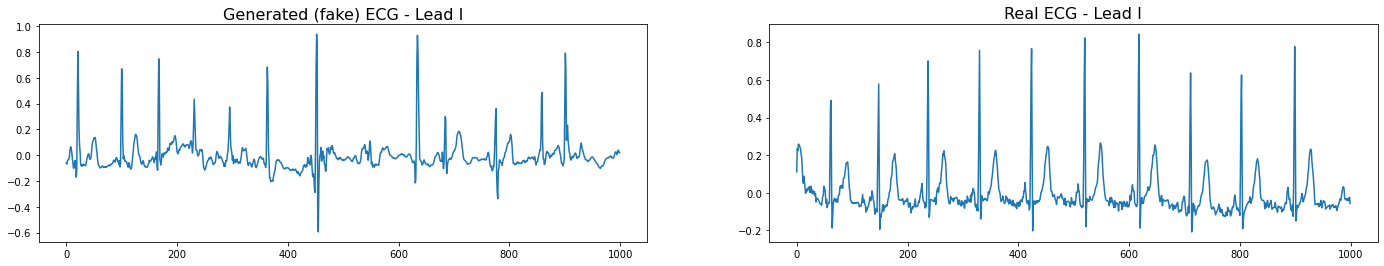

Generator AUROC: 0.0
Generator loss: 0.9015503
Descriminator AUROC: 0.44140625
Descriminator loss: 0.5518583
-------------------
epoch 32
Generator AUROC: 0.0
Generator loss: 0.8995968
Descriminator AUROC: 0.53125
Descriminator loss: 0.55423903
-------------------
epoch 33
Generator AUROC: 0.0
Generator loss: 0.9008941
Descriminator AUROC: 0.57421875
Descriminator loss: 0.5497097
-------------------
epoch 34
Generator AUROC: 0.0
Generator loss: 0.8989659
Descriminator AUROC: 0.3515625
Descriminator loss: 0.5562872
-------------------
epoch 35
Generator AUROC: 0.0
Generator loss: 0.8988755
Descriminator AUROC: 0.37109375
Descriminator loss: 0.55176026
-------------------
epoch 36


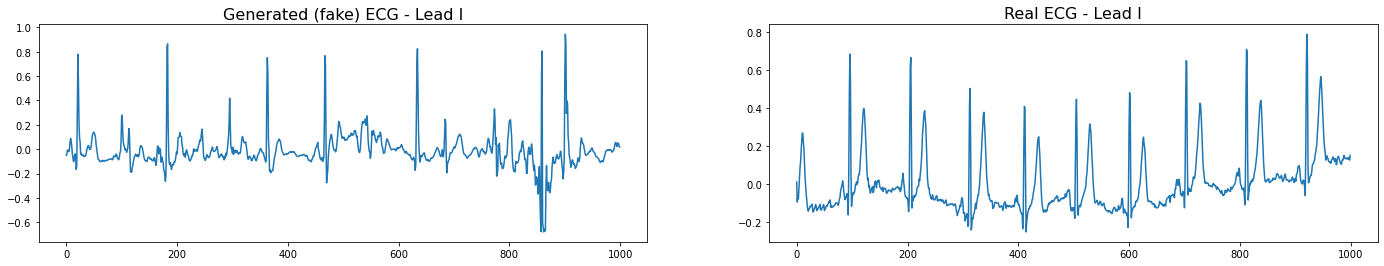

Generator AUROC: 0.0
Generator loss: 0.89883953
Descriminator AUROC: 0.4296875
Descriminator loss: 0.5539683
-------------------
epoch 37
Generator AUROC: 0.0
Generator loss: 0.90246886
Descriminator AUROC: 0.60546875
Descriminator loss: 0.5546424
-------------------
epoch 38
Generator AUROC: 0.0
Generator loss: 0.9012107
Descriminator AUROC: 0.25
Descriminator loss: 0.5536462
-------------------
epoch 39
Generator AUROC: 0.0
Generator loss: 0.9007217
Descriminator AUROC: 0.4609375
Descriminator loss: 0.55201566
-------------------
epoch 40
Generator AUROC: 0.0
Generator loss: 0.90068024
Descriminator AUROC: 0.46875
Descriminator loss: 0.5537919
-------------------
epoch 41


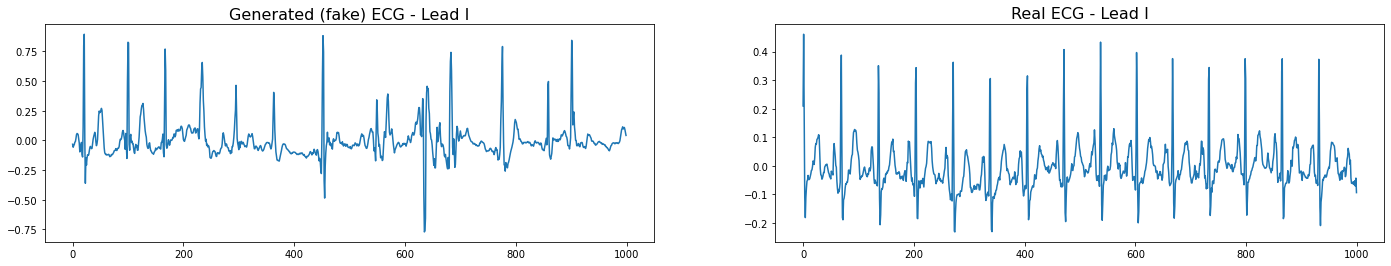

Generator AUROC: 0.0
Generator loss: 0.9017962
Descriminator AUROC: 0.33984375
Descriminator loss: 0.5541744
-------------------
epoch 42
Generator AUROC: 0.0
Generator loss: 0.9016423
Descriminator AUROC: 0.56640625
Descriminator loss: 0.5559959
-------------------
epoch 43
Generator AUROC: 0.0
Generator loss: 0.9019458
Descriminator AUROC: 0.58984375
Descriminator loss: 0.5505383
-------------------
epoch 44
Generator AUROC: 0.0
Generator loss: 0.90210694
Descriminator AUROC: 0.5546875
Descriminator loss: 0.5541587
-------------------
epoch 45
Generator AUROC: 0.0
Generator loss: 0.89995354
Descriminator AUROC: 0.44140625
Descriminator loss: 0.55202836
-------------------
epoch 46


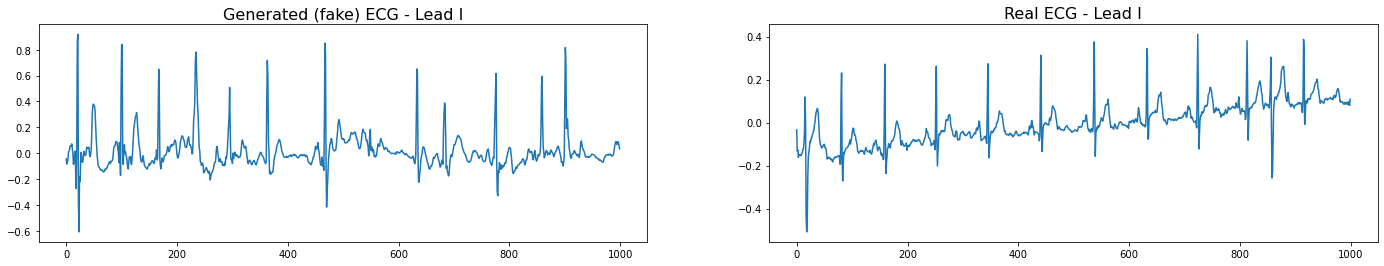

Generator AUROC: 0.0
Generator loss: 0.90083396
Descriminator AUROC: 0.6171875
Descriminator loss: 0.55203897
-------------------
epoch 47
Generator AUROC: 0.0
Generator loss: 0.9017134
Descriminator AUROC: 0.46875
Descriminator loss: 0.55315036
-------------------
epoch 48
Generator AUROC: 0.0
Generator loss: 0.9021237
Descriminator AUROC: 0.4765625
Descriminator loss: 0.55303943
-------------------
epoch 49
Generator AUROC: 0.0
Generator loss: 0.90172714
Descriminator AUROC: 0.61328125
Descriminator loss: 0.55272245
-------------------
epoch 50
Generator AUROC: 0.0
Generator loss: 0.90160257
Descriminator AUROC: 0.51171875
Descriminator loss: 0.5521336
-------------------
epoch 51


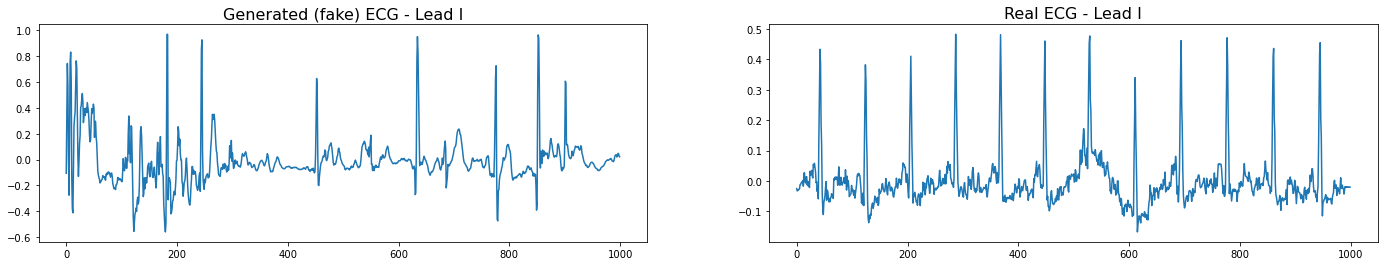

Generator AUROC: 0.0
Generator loss: 0.90139437
Descriminator AUROC: 0.58984375
Descriminator loss: 0.5554099
-------------------
epoch 52
Generator AUROC: 0.0
Generator loss: 0.90142626
Descriminator AUROC: 0.44140625
Descriminator loss: 0.5532303
-------------------
epoch 53
Generator AUROC: 0.0
Generator loss: 0.9012387
Descriminator AUROC: 0.40625
Descriminator loss: 0.55271065
-------------------
epoch 54
Generator AUROC: 0.0
Generator loss: 0.90101135
Descriminator AUROC: 0.4296875
Descriminator loss: 0.55362314
-------------------
epoch 55
Generator AUROC: 0.0
Generator loss: 0.90018874
Descriminator AUROC: 0.54296875
Descriminator loss: 0.55719066
-------------------
epoch 56


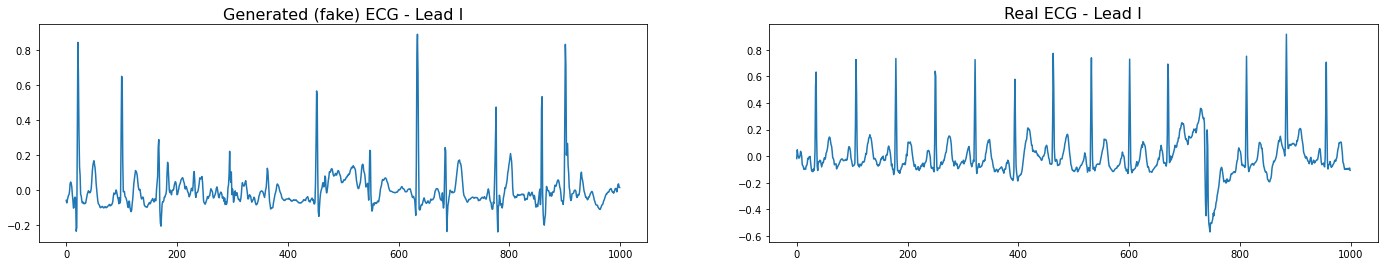

Generator AUROC: 0.0
Generator loss: 0.8998579
Descriminator AUROC: 0.46875
Descriminator loss: 0.5544296
-------------------
epoch 57
Generator AUROC: 0.0
Generator loss: 0.89981896
Descriminator AUROC: 0.4375
Descriminator loss: 0.55295545
-------------------
epoch 58
Generator AUROC: 0.0
Generator loss: 0.90016776
Descriminator AUROC: 0.37109375
Descriminator loss: 0.55125695
-------------------
epoch 59
Generator AUROC: 0.0
Generator loss: 0.90022326
Descriminator AUROC: 0.4921875
Descriminator loss: 0.5522353
-------------------
epoch 60
Generator AUROC: 0.0
Generator loss: 0.9003525
Descriminator AUROC: 0.49609375
Descriminator loss: 0.55130935
-------------------
epoch 61


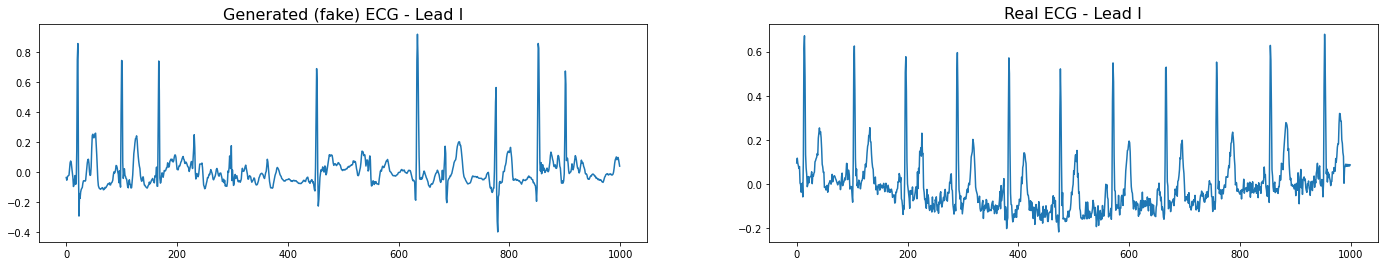

Generator AUROC: 0.0
Generator loss: 0.90046614
Descriminator AUROC: 0.44921875
Descriminator loss: 0.5494154
-------------------
epoch 62
Generator AUROC: 0.0
Generator loss: 0.9006803
Descriminator AUROC: 0.6875
Descriminator loss: 0.5525894
-------------------
epoch 63
Generator AUROC: 0.0
Generator loss: 0.90036774
Descriminator AUROC: 0.6875
Descriminator loss: 0.5528948
-------------------
epoch 64
Generator AUROC: 0.0
Generator loss: 0.90041566
Descriminator AUROC: 0.63671875
Descriminator loss: 0.5562691
-------------------
epoch 65
Generator AUROC: 0.0
Generator loss: 0.9001731
Descriminator AUROC: 0.51171875
Descriminator loss: 0.55406356
-------------------
epoch 66


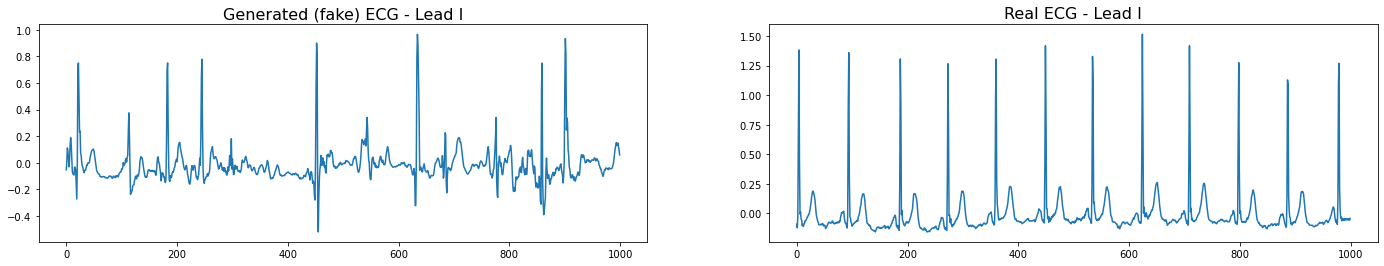

Generator AUROC: 0.0
Generator loss: 0.9003128
Descriminator AUROC: 0.50390625
Descriminator loss: 0.55176854
-------------------
epoch 67
Generator AUROC: 0.0
Generator loss: 0.90034425
Descriminator AUROC: 0.40234375
Descriminator loss: 0.550803
-------------------
epoch 68
Generator AUROC: 0.0
Generator loss: 0.9004943
Descriminator AUROC: 0.54296875
Descriminator loss: 0.5521893
-------------------
epoch 69
Generator AUROC: 0.0
Generator loss: 0.9004377
Descriminator AUROC: 0.5390625
Descriminator loss: 0.5533894
-------------------
epoch 70
Generator AUROC: 0.0
Generator loss: 0.90033656
Descriminator AUROC: 0.6640625
Descriminator loss: 0.55381405
-------------------
epoch 71


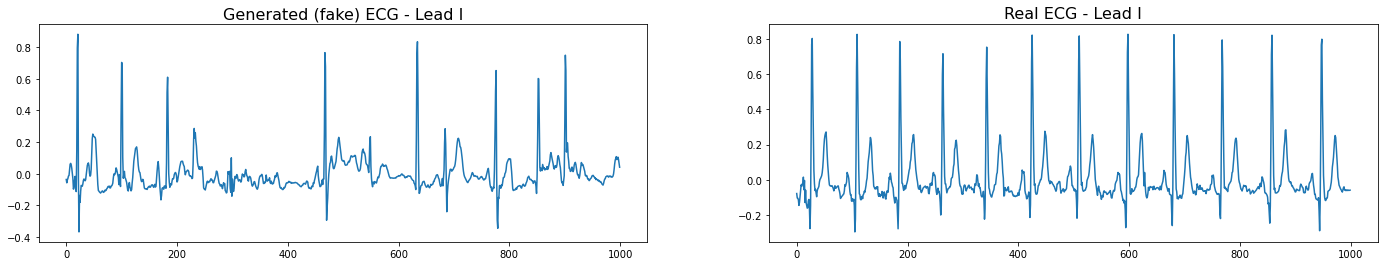

Generator AUROC: 0.0
Generator loss: 0.90048206
Descriminator AUROC: 0.57421875
Descriminator loss: 0.5532963
-------------------
epoch 72
Generator AUROC: 0.0
Generator loss: 0.90020734
Descriminator AUROC: 0.57421875
Descriminator loss: 0.55477357
-------------------
epoch 73
Generator AUROC: 0.0
Generator loss: 0.90046537
Descriminator AUROC: 0.4921875
Descriminator loss: 0.555105
-------------------
epoch 74
Generator AUROC: 0.0
Generator loss: 0.90024495
Descriminator AUROC: 0.54296875
Descriminator loss: 0.55494785
-------------------
epoch 75
Generator AUROC: 0.0
Generator loss: 0.9004488
Descriminator AUROC: 0.640625
Descriminator loss: 0.55241007
-------------------
epoch 76


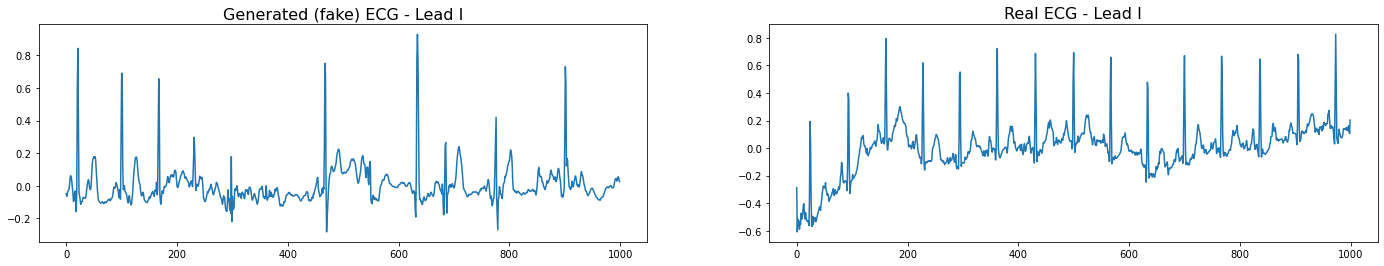

Generator AUROC: 0.0
Generator loss: 0.90028244
Descriminator AUROC: 0.62890625
Descriminator loss: 0.5533231
-------------------
epoch 77
Generator AUROC: 0.0
Generator loss: 0.90027946
Descriminator AUROC: 0.4140625
Descriminator loss: 0.55340385
-------------------
epoch 78
Generator AUROC: 0.0
Generator loss: 0.90045094
Descriminator AUROC: 0.29296875
Descriminator loss: 0.5533303
-------------------
epoch 79
Generator AUROC: 0.0
Generator loss: 0.90041006
Descriminator AUROC: 0.33203125
Descriminator loss: 0.55322546
-------------------
epoch 80
Generator AUROC: 0.0
Generator loss: 0.9004199
Descriminator AUROC: 0.49609375
Descriminator loss: 0.5534855
-------------------
epoch 81


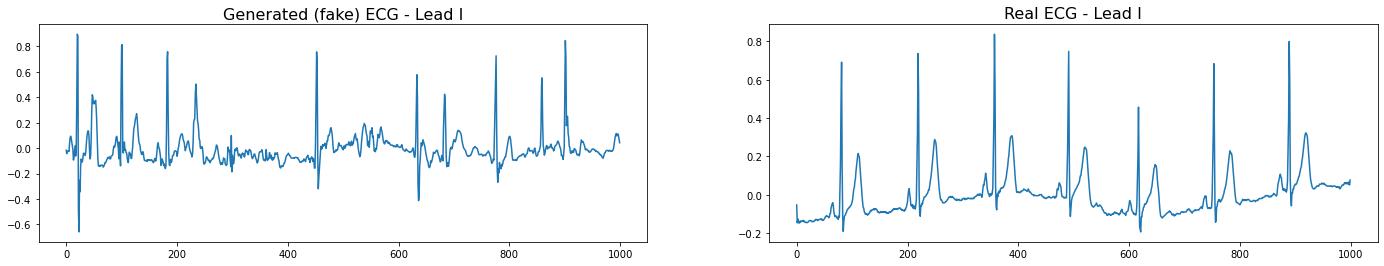

Generator AUROC: 0.0
Generator loss: 0.9004072
Descriminator AUROC: 0.48828125
Descriminator loss: 0.55004996
-------------------
epoch 82
Generator AUROC: 0.0
Generator loss: 0.9004943
Descriminator AUROC: 0.796875
Descriminator loss: 0.5521319
-------------------
epoch 83
Generator AUROC: 0.0
Generator loss: 0.90045005
Descriminator AUROC: 0.48828125
Descriminator loss: 0.5534207
-------------------
epoch 84
Generator AUROC: 0.0
Generator loss: 0.90039957
Descriminator AUROC: 0.37109375
Descriminator loss: 0.55081755
-------------------
epoch 85
Generator AUROC: 0.0
Generator loss: 0.9004922
Descriminator AUROC: 0.6484375
Descriminator loss: 0.5530676
-------------------
epoch 86


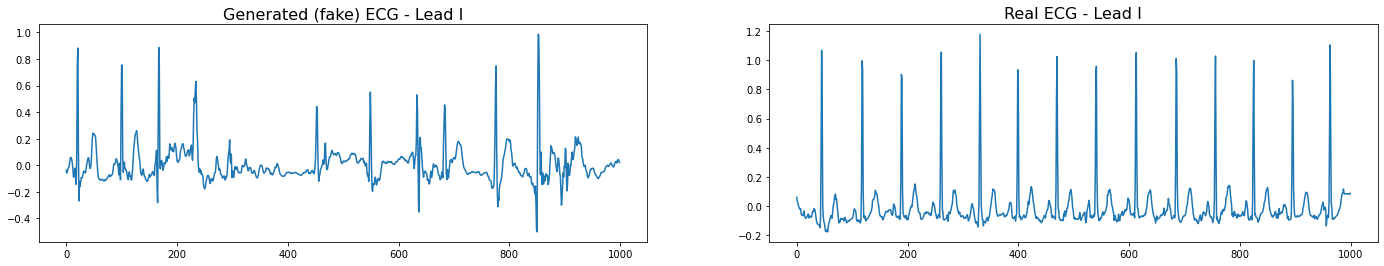

Generator AUROC: 0.0
Generator loss: 0.90049803
Descriminator AUROC: 0.6171875
Descriminator loss: 0.55269724
-------------------
epoch 87
Generator AUROC: 0.0
Generator loss: 0.9004139
Descriminator AUROC: 0.65625
Descriminator loss: 0.55301505
-------------------
epoch 88
Generator AUROC: 0.0
Generator loss: 0.9003688
Descriminator AUROC: 0.40234375
Descriminator loss: 0.55345434
-------------------
epoch 89
Generator AUROC: 0.0
Generator loss: 0.9004581
Descriminator AUROC: 0.73046875
Descriminator loss: 0.5530996
-------------------
epoch 90
Generator AUROC: 0.0
Generator loss: 0.90033114
Descriminator AUROC: 0.4140625
Descriminator loss: 0.5502279
-------------------
epoch 91


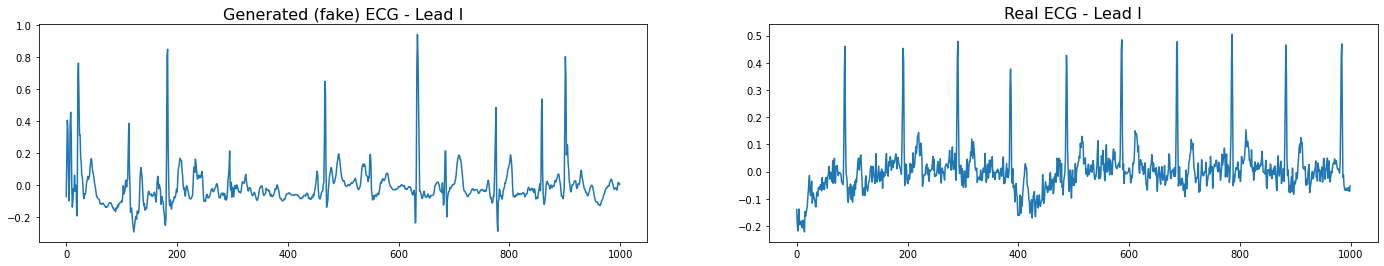

Generator AUROC: 0.0
Generator loss: 0.9004311
Descriminator AUROC: 0.4453125
Descriminator loss: 0.5539767
-------------------
epoch 92
Generator AUROC: 0.0
Generator loss: 0.9002882
Descriminator AUROC: 0.63671875
Descriminator loss: 0.5541501
-------------------
epoch 93
Generator AUROC: 0.0
Generator loss: 0.9005573
Descriminator AUROC: 0.52734375
Descriminator loss: 0.55106336
-------------------
epoch 94
Generator AUROC: 0.0
Generator loss: 0.9002732
Descriminator AUROC: 0.52734375
Descriminator loss: 0.5548715
-------------------
epoch 95
Generator AUROC: 0.0
Generator loss: 0.9005025
Descriminator AUROC: 0.3984375
Descriminator loss: 0.549095
-------------------
epoch 96


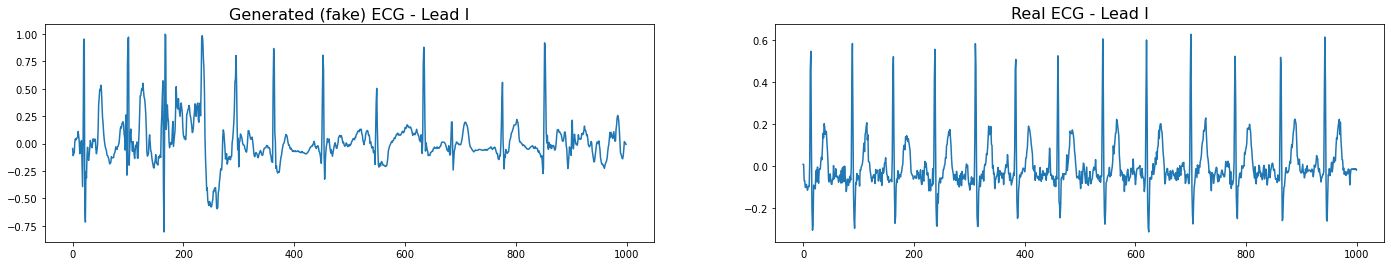

Generator AUROC: 0.0
Generator loss: 0.9005018
Descriminator AUROC: 0.53515625
Descriminator loss: 0.55371845
-------------------
epoch 97
Generator AUROC: 0.0
Generator loss: 0.90043235
Descriminator AUROC: 0.49609375
Descriminator loss: 0.5507898
-------------------
epoch 98
Generator AUROC: 0.0
Generator loss: 0.9004188
Descriminator AUROC: 0.4609375
Descriminator loss: 0.5515403
-------------------
epoch 99
Generator AUROC: 0.0
Generator loss: 0.90046895
Descriminator AUROC: 0.3515625
Descriminator loss: 0.5523541
-------------------
epoch 100
Generator AUROC: 0.0
Generator loss: 0.9004272
Descriminator AUROC: 0.5078125
Descriminator loss: 0.55419743
-------------------
epoch 101


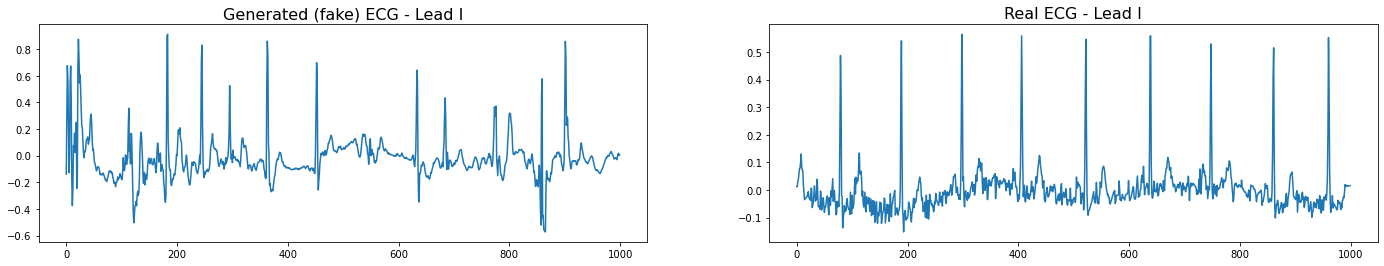

Generator AUROC: 0.0
Generator loss: 0.90049446
Descriminator AUROC: 0.5390625
Descriminator loss: 0.55039144
-------------------
epoch 102
Generator AUROC: 0.0
Generator loss: 0.90044147
Descriminator AUROC: 0.57421875
Descriminator loss: 0.55450535
-------------------
epoch 103
Generator AUROC: 0.0
Generator loss: 0.9003726
Descriminator AUROC: 0.36328125
Descriminator loss: 0.55510455
-------------------
epoch 104
Generator AUROC: 0.0
Generator loss: 0.9004106
Descriminator AUROC: 0.59765625
Descriminator loss: 0.55065405
-------------------
epoch 105
Generator AUROC: 0.0
Generator loss: 0.90057373
Descriminator AUROC: 0.54296875
Descriminator loss: 0.55352795
-------------------
epoch 106


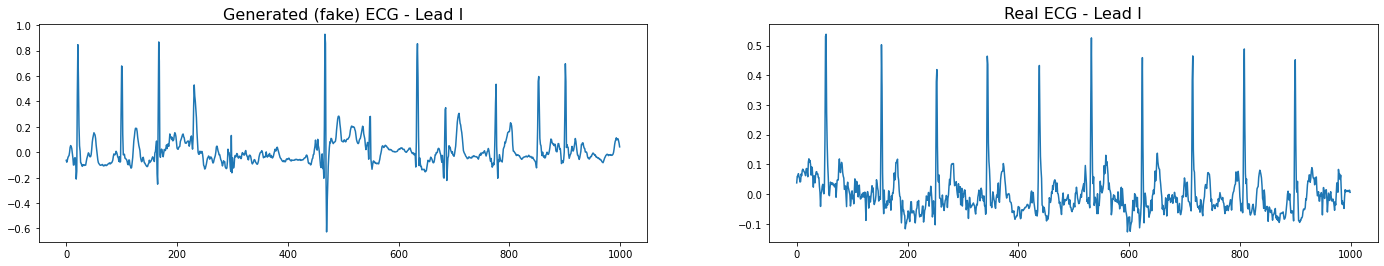

Generator AUROC: 0.0
Generator loss: 0.90044916
Descriminator AUROC: 0.49609375
Descriminator loss: 0.5528127
-------------------
epoch 107
Generator AUROC: 0.0
Generator loss: 0.9005347
Descriminator AUROC: 0.66796875
Descriminator loss: 0.55317503
-------------------
epoch 108
Generator AUROC: 0.0
Generator loss: 0.9002623
Descriminator AUROC: 0.43359375
Descriminator loss: 0.5519072
-------------------
epoch 109
Generator AUROC: 0.0
Generator loss: 0.9003654
Descriminator AUROC: 0.54296875
Descriminator loss: 0.5539712
-------------------
epoch 110
Generator AUROC: 0.0
Generator loss: 0.9004105
Descriminator AUROC: 0.296875
Descriminator loss: 0.5554031
-------------------
epoch 111


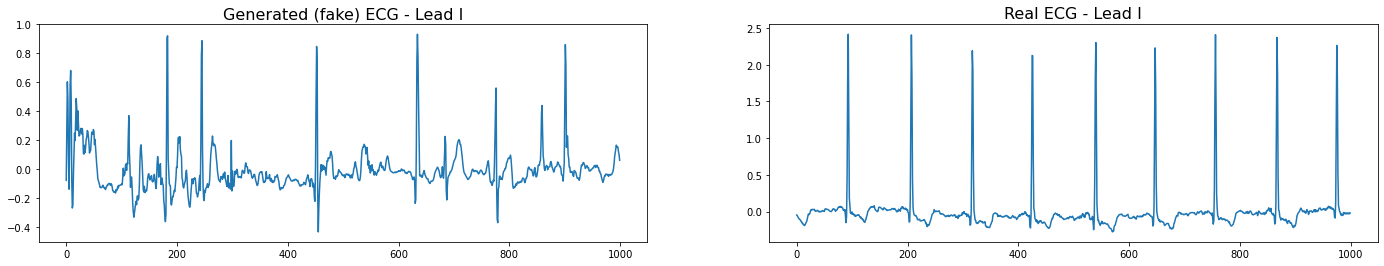

Generator AUROC: 0.0
Generator loss: 0.9003268
Descriminator AUROC: 0.6796875
Descriminator loss: 0.55105096
-------------------
epoch 112
Generator AUROC: 0.0
Generator loss: 0.900418
Descriminator AUROC: 0.2734375
Descriminator loss: 0.5546428
-------------------
epoch 113
Generator AUROC: 0.0
Generator loss: 0.900472
Descriminator AUROC: 0.40234375
Descriminator loss: 0.5527522
-------------------
epoch 114
Generator AUROC: 0.0
Generator loss: 0.9004556
Descriminator AUROC: 0.55859375
Descriminator loss: 0.55639005
-------------------
epoch 115
Generator AUROC: 0.0
Generator loss: 0.9003284
Descriminator AUROC: 0.4453125
Descriminator loss: 0.5561266
-------------------
epoch 116


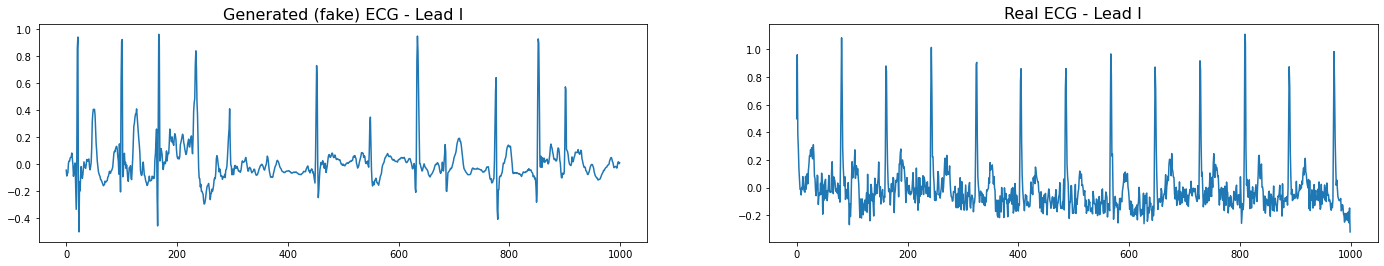

Generator AUROC: 0.0
Generator loss: 0.90032536
Descriminator AUROC: 0.56640625
Descriminator loss: 0.55244815
-------------------
epoch 117
Generator AUROC: 0.0
Generator loss: 0.90042275
Descriminator AUROC: 0.58203125
Descriminator loss: 0.5543084
-------------------
epoch 118
Generator AUROC: 0.0
Generator loss: 0.9003515
Descriminator AUROC: 0.4140625
Descriminator loss: 0.55516547
-------------------
epoch 119
Generator AUROC: 0.0
Generator loss: 0.9003906
Descriminator AUROC: 0.36328125
Descriminator loss: 0.5517401
-------------------
epoch 120
Generator AUROC: 0.0
Generator loss: 0.9003574
Descriminator AUROC: 0.62109375
Descriminator loss: 0.556214
-------------------
epoch 121


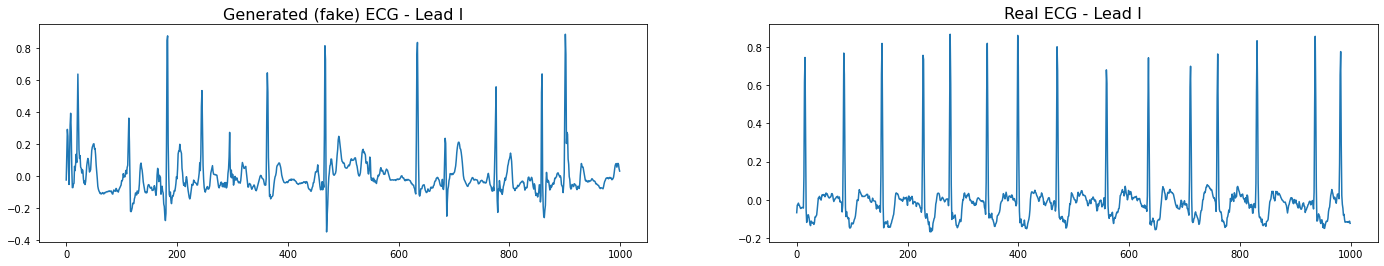

Generator AUROC: 0.0
Generator loss: 0.9004606
Descriminator AUROC: 0.4609375
Descriminator loss: 0.5561818
-------------------
epoch 122
Generator AUROC: 0.0
Generator loss: 0.9003301
Descriminator AUROC: 0.4140625
Descriminator loss: 0.55222607
-------------------
epoch 123
Generator AUROC: 0.0
Generator loss: 0.9005011
Descriminator AUROC: 0.48828125
Descriminator loss: 0.55452013
-------------------
epoch 124
Generator AUROC: 0.0
Generator loss: 0.9004135
Descriminator AUROC: 0.421875
Descriminator loss: 0.55375624
-------------------
epoch 125
Generator AUROC: 0.0
Generator loss: 0.90040046
Descriminator AUROC: 0.49609375
Descriminator loss: 0.54932153
-------------------
epoch 126


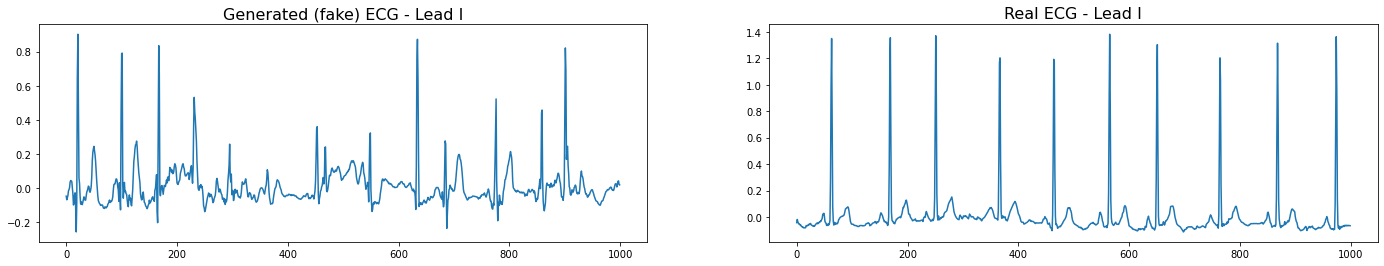

Generator AUROC: 0.0
Generator loss: 0.9005591
Descriminator AUROC: 0.72265625
Descriminator loss: 0.5531008
-------------------
epoch 127
Generator AUROC: 0.0
Generator loss: 0.90034133
Descriminator AUROC: 0.359375
Descriminator loss: 0.54940414
-------------------
epoch 128
Generator AUROC: 0.0
Generator loss: 0.9005399
Descriminator AUROC: 0.6875
Descriminator loss: 0.5533178
-------------------
epoch 129
Generator AUROC: 0.0
Generator loss: 0.90027374
Descriminator AUROC: 0.51953125
Descriminator loss: 0.55160826
-------------------
epoch 130
Generator AUROC: 0.0
Generator loss: 0.90050197
Descriminator AUROC: 0.296875
Descriminator loss: 0.5503543
-------------------
epoch 131


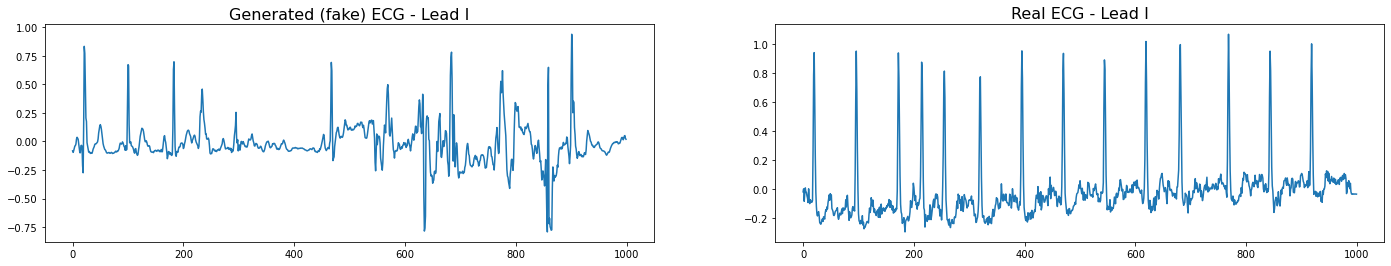

Generator AUROC: 0.0
Generator loss: 0.9004164
Descriminator AUROC: 0.4765625
Descriminator loss: 0.5532309
-------------------
epoch 132
Generator AUROC: 0.0
Generator loss: 0.9004213
Descriminator AUROC: 0.63671875
Descriminator loss: 0.5528643
-------------------
epoch 133
Generator AUROC: 0.0
Generator loss: 0.9004027
Descriminator AUROC: 0.296875
Descriminator loss: 0.5546289
-------------------
epoch 134
Generator AUROC: 0.0
Generator loss: 0.90055656
Descriminator AUROC: 0.44921875
Descriminator loss: 0.5539231
-------------------
epoch 135
Generator AUROC: 0.0
Generator loss: 0.9004532
Descriminator AUROC: 0.77734375
Descriminator loss: 0.5494847
-------------------
epoch 136


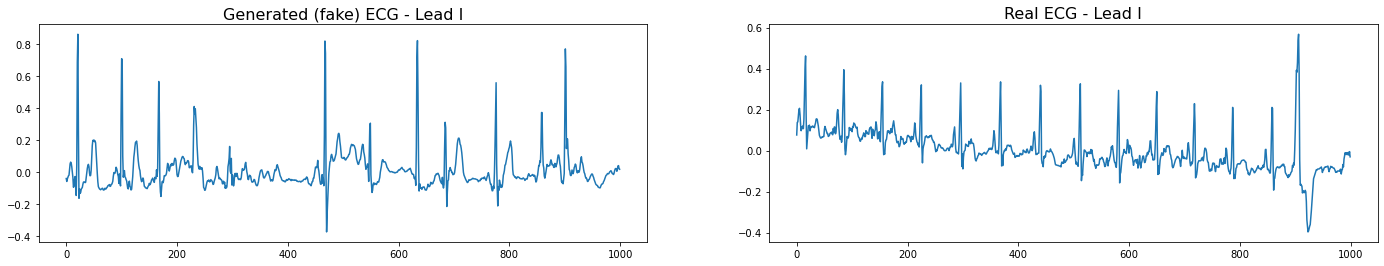

Generator AUROC: 0.0
Generator loss: 0.9005476
Descriminator AUROC: 0.51171875
Descriminator loss: 0.55351824
-------------------
epoch 137
Generator AUROC: 0.0
Generator loss: 0.9004292
Descriminator AUROC: 0.5703125
Descriminator loss: 0.552608
-------------------
epoch 138
Generator AUROC: 0.0
Generator loss: 0.90035766
Descriminator AUROC: 0.58203125
Descriminator loss: 0.55372936
-------------------
epoch 139
Generator AUROC: 0.0
Generator loss: 0.90040994
Descriminator AUROC: 0.296875
Descriminator loss: 0.55123526
-------------------
epoch 140
Generator AUROC: 0.0
Generator loss: 0.90017074
Descriminator AUROC: 0.59765625
Descriminator loss: 0.55117
-------------------
epoch 141


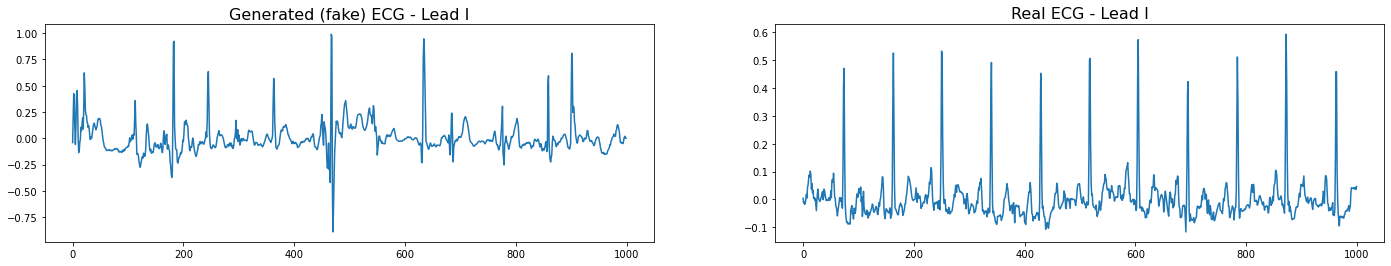

Generator AUROC: 0.0
Generator loss: 0.9005068
Descriminator AUROC: 0.609375
Descriminator loss: 0.55370307
-------------------
epoch 142
Generator AUROC: 0.0
Generator loss: 0.90057534
Descriminator AUROC: 0.48828125
Descriminator loss: 0.5543515
-------------------
epoch 143
Generator AUROC: 0.0
Generator loss: 0.90035945
Descriminator AUROC: 0.37890625
Descriminator loss: 0.551252
-------------------
epoch 144
Generator AUROC: 0.0
Generator loss: 0.90053004
Descriminator AUROC: 0.32421875
Descriminator loss: 0.5520796
-------------------
epoch 145
Generator AUROC: 0.0
Generator loss: 0.90037113
Descriminator AUROC: 0.39453125
Descriminator loss: 0.5519606
-------------------
epoch 146


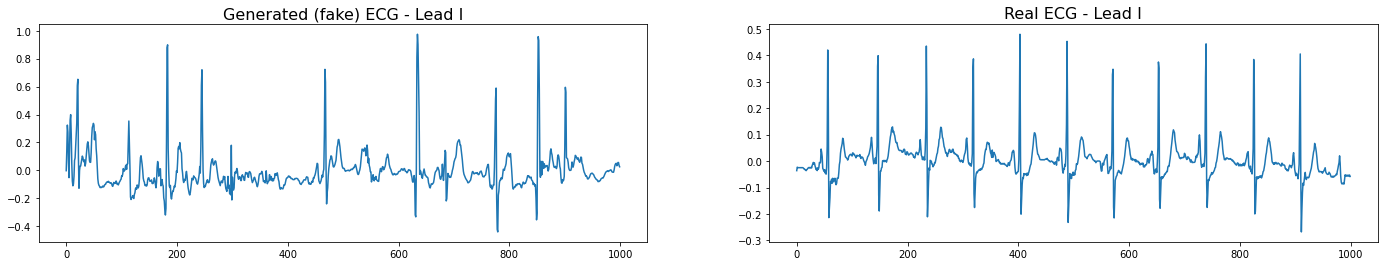

Generator AUROC: 0.0
Generator loss: 0.9004888
Descriminator AUROC: 0.7265625
Descriminator loss: 0.55175555
-------------------
epoch 147
Generator AUROC: 0.0
Generator loss: 0.90033996
Descriminator AUROC: 0.421875
Descriminator loss: 0.5524381
-------------------
epoch 148
Generator AUROC: 0.0
Generator loss: 0.9003729
Descriminator AUROC: 0.515625
Descriminator loss: 0.55408895
-------------------
epoch 149
Generator AUROC: 0.0
Generator loss: 0.90050536
Descriminator AUROC: 0.484375
Descriminator loss: 0.5522168
-------------------
epoch 150
Generator AUROC: 0.0
Generator loss: 0.9003681
Descriminator AUROC: 0.5390625
Descriminator loss: 0.5531305
-------------------
epoch 151


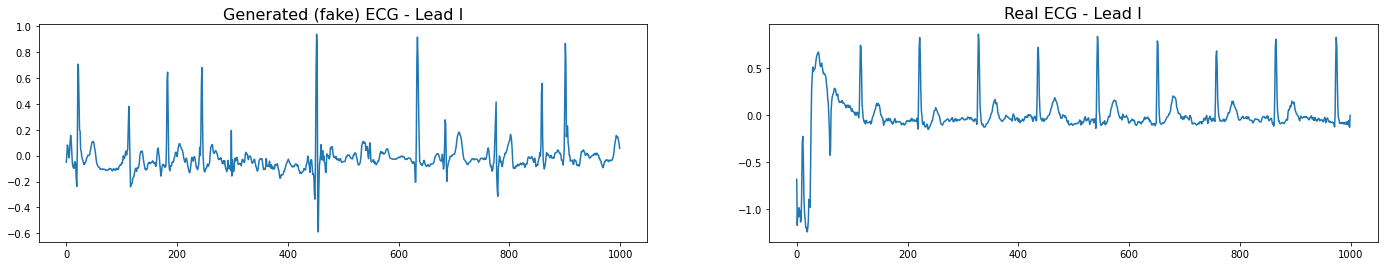

Generator AUROC: 0.0
Generator loss: 0.9004843
Descriminator AUROC: 0.43359375
Descriminator loss: 0.55238885
-------------------
epoch 152
Generator AUROC: 0.0
Generator loss: 0.9002544
Descriminator AUROC: 0.52734375
Descriminator loss: 0.55177975
-------------------
epoch 153
Generator AUROC: 0.0
Generator loss: 0.9003474
Descriminator AUROC: 0.56640625
Descriminator loss: 0.55602926
-------------------
epoch 154
Generator AUROC: 0.0
Generator loss: 0.9003508
Descriminator AUROC: 0.53515625
Descriminator loss: 0.55212045
-------------------
epoch 155
Generator AUROC: 0.0
Generator loss: 0.9005632
Descriminator AUROC: 0.57421875
Descriminator loss: 0.55168813
-------------------
epoch 156


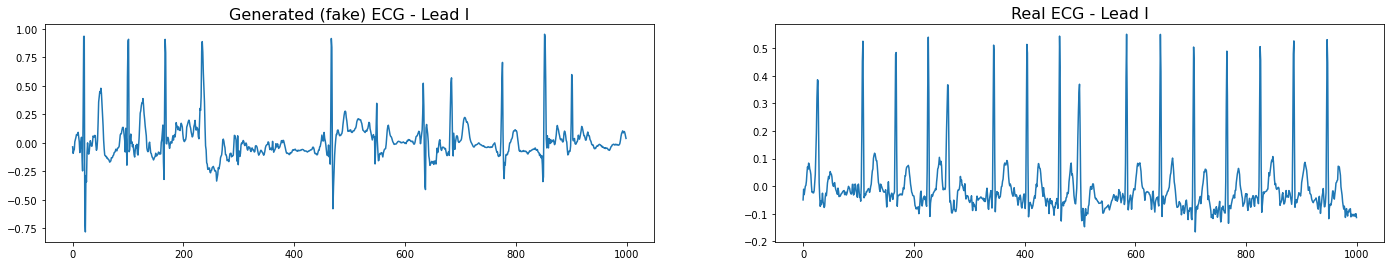

Generator AUROC: 0.0
Generator loss: 0.90048516
Descriminator AUROC: 0.484375
Descriminator loss: 0.55278647
-------------------
epoch 157
Generator AUROC: 0.0
Generator loss: 0.9004956
Descriminator AUROC: 0.4765625
Descriminator loss: 0.55138516
-------------------
epoch 158
Generator AUROC: 0.0
Generator loss: 0.9004915
Descriminator AUROC: 0.46875
Descriminator loss: 0.55389357
-------------------
epoch 159
Generator AUROC: 0.0
Generator loss: 0.9004036
Descriminator AUROC: 0.5703125
Descriminator loss: 0.5524228
-------------------
epoch 160
Generator AUROC: 0.0
Generator loss: 0.9003512
Descriminator AUROC: 0.6953125
Descriminator loss: 0.55460536
-------------------
epoch 161


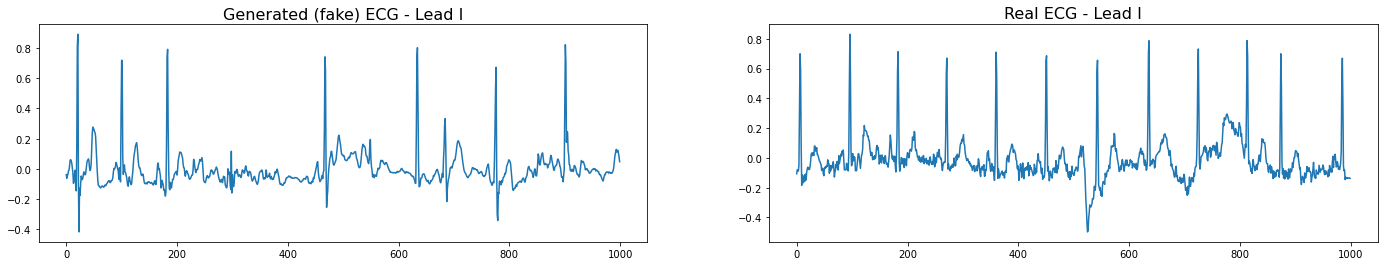

Generator AUROC: 0.0
Generator loss: 0.9005129
Descriminator AUROC: 0.4453125
Descriminator loss: 0.5560718
-------------------
epoch 162
Generator AUROC: 0.0
Generator loss: 0.9004645
Descriminator AUROC: 0.50390625
Descriminator loss: 0.5512458
-------------------
epoch 163
Generator AUROC: 0.0
Generator loss: 0.9004461
Descriminator AUROC: 0.5
Descriminator loss: 0.55331105
-------------------
epoch 164
Generator AUROC: 0.0
Generator loss: 0.9002557
Descriminator AUROC: 0.58203125
Descriminator loss: 0.5529571
-------------------
epoch 165
Generator AUROC: 0.0
Generator loss: 0.9005195
Descriminator AUROC: 0.625
Descriminator loss: 0.54986113
-------------------
epoch 166


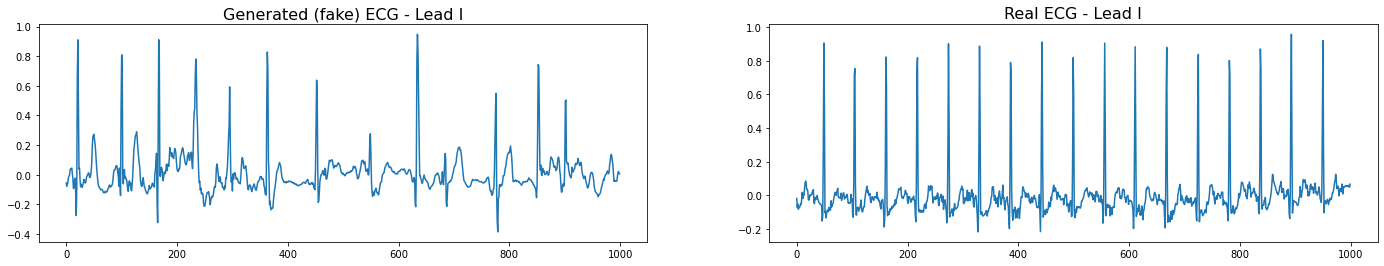

Generator AUROC: 0.0
Generator loss: 0.90055317
Descriminator AUROC: 0.41015625
Descriminator loss: 0.5532987
-------------------
epoch 167
Generator AUROC: 0.0
Generator loss: 0.9003117
Descriminator AUROC: 0.48046875
Descriminator loss: 0.55343926
-------------------
epoch 168
Generator AUROC: 0.0
Generator loss: 0.90029806
Descriminator AUROC: 0.5703125
Descriminator loss: 0.5522985
-------------------
epoch 169
Generator AUROC: 0.0
Generator loss: 0.9003774
Descriminator AUROC: 0.76953125
Descriminator loss: 0.5539033
-------------------
epoch 170
Generator AUROC: 0.0
Generator loss: 0.9004017
Descriminator AUROC: 0.63671875
Descriminator loss: 0.5541501
-------------------
epoch 171


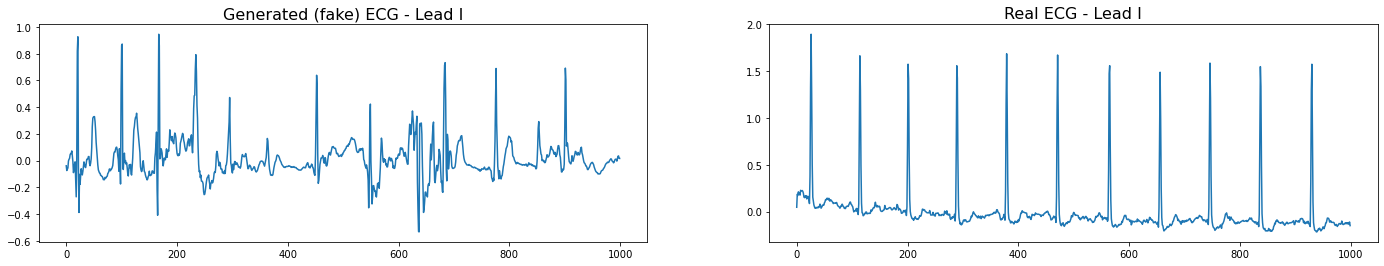

Generator AUROC: 0.0
Generator loss: 0.9004096
Descriminator AUROC: 0.71875
Descriminator loss: 0.5528117
-------------------
epoch 172
Generator AUROC: 0.0
Generator loss: 0.9004198
Descriminator AUROC: 0.3125
Descriminator loss: 0.55080897
-------------------
epoch 173
Generator AUROC: 0.0
Generator loss: 0.9003891
Descriminator AUROC: 0.40625
Descriminator loss: 0.5510897
-------------------
epoch 174
Generator AUROC: 0.0
Generator loss: 0.90043277
Descriminator AUROC: 0.5390625
Descriminator loss: 0.5531911
-------------------
epoch 175
Generator AUROC: 0.0
Generator loss: 0.9003558
Descriminator AUROC: 0.53125
Descriminator loss: 0.5546492
-------------------
epoch 176


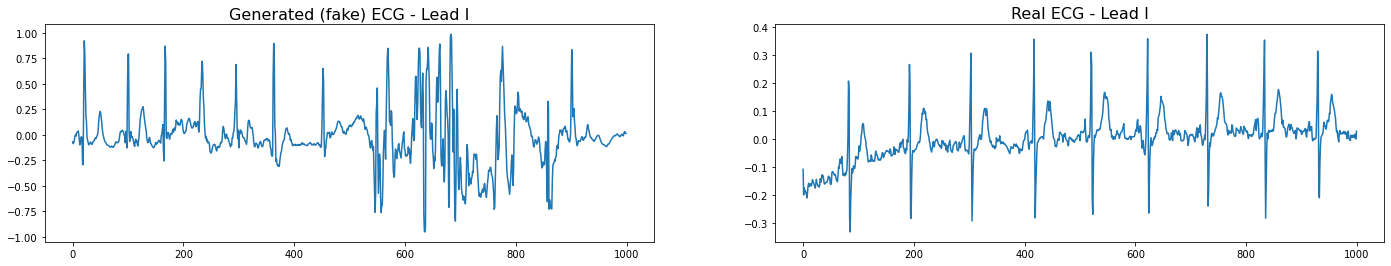

Generator AUROC: 0.0
Generator loss: 0.90025645
Descriminator AUROC: 0.546875
Descriminator loss: 0.5513928
-------------------
epoch 177
Generator AUROC: 0.0
Generator loss: 0.90045184
Descriminator AUROC: 0.53515625
Descriminator loss: 0.5544084
-------------------
epoch 178
Generator AUROC: 0.0
Generator loss: 0.90034837
Descriminator AUROC: 0.609375
Descriminator loss: 0.5513565
-------------------
epoch 179
Generator AUROC: 0.0
Generator loss: 0.90041703
Descriminator AUROC: 0.40625
Descriminator loss: 0.55182505
-------------------
epoch 180
Generator AUROC: 0.0
Generator loss: 0.9003276
Descriminator AUROC: 0.50390625
Descriminator loss: 0.55654955
-------------------
epoch 181


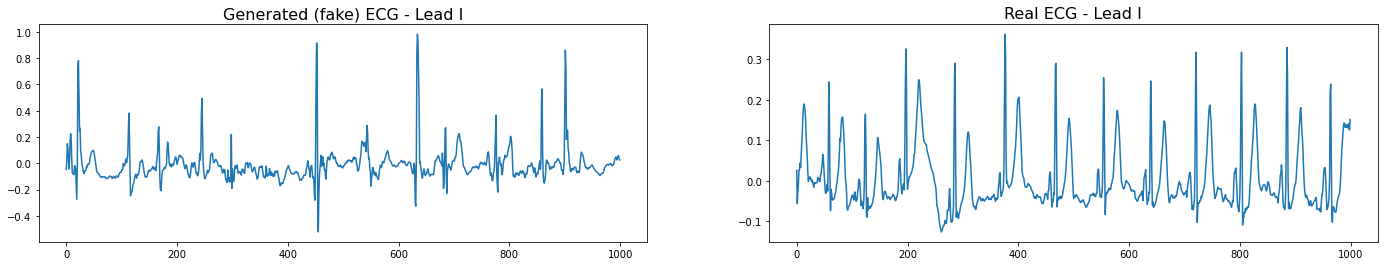

Generator AUROC: 0.0
Generator loss: 0.90042305
Descriminator AUROC: 0.5078125
Descriminator loss: 0.55171585
-------------------
epoch 182
Generator AUROC: 0.0
Generator loss: 0.900557
Descriminator AUROC: 0.37109375
Descriminator loss: 0.55313486
-------------------
epoch 183
Generator AUROC: 0.0
Generator loss: 0.9005115
Descriminator AUROC: 0.359375
Descriminator loss: 0.5525757
-------------------
epoch 184
Generator AUROC: 0.0
Generator loss: 0.90028673
Descriminator AUROC: 0.3671875
Descriminator loss: 0.5510637
-------------------
epoch 185
Generator AUROC: 0.0
Generator loss: 0.9004045
Descriminator AUROC: 0.73046875
Descriminator loss: 0.55426955
-------------------
epoch 186


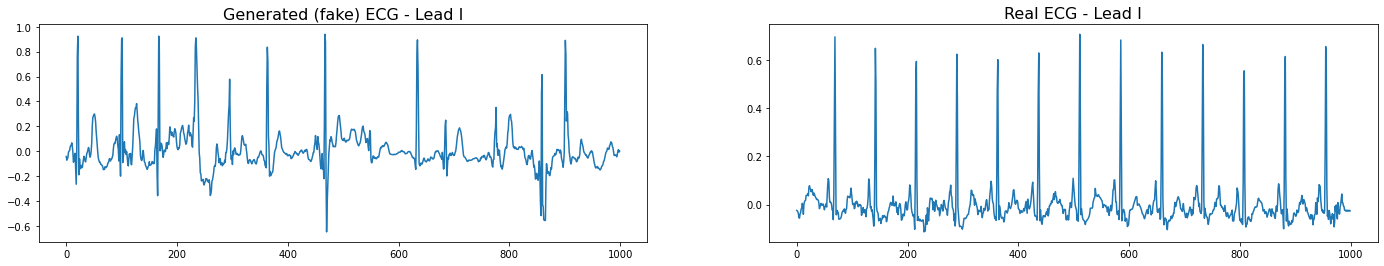

Generator AUROC: 0.0
Generator loss: 0.9003612
Descriminator AUROC: 0.41015625
Descriminator loss: 0.54938954
-------------------
epoch 187
Generator AUROC: 0.0
Generator loss: 0.90056765
Descriminator AUROC: 0.59375
Descriminator loss: 0.55515987
-------------------
epoch 188
Generator AUROC: 0.0
Generator loss: 0.9004957
Descriminator AUROC: 0.546875
Descriminator loss: 0.55449575
-------------------
epoch 189
Generator AUROC: 0.0
Generator loss: 0.9005519
Descriminator AUROC: 0.46484375
Descriminator loss: 0.5494169
-------------------
epoch 190
Generator AUROC: 0.0
Generator loss: 0.90041256
Descriminator AUROC: 0.5078125
Descriminator loss: 0.55359423
-------------------
epoch 191


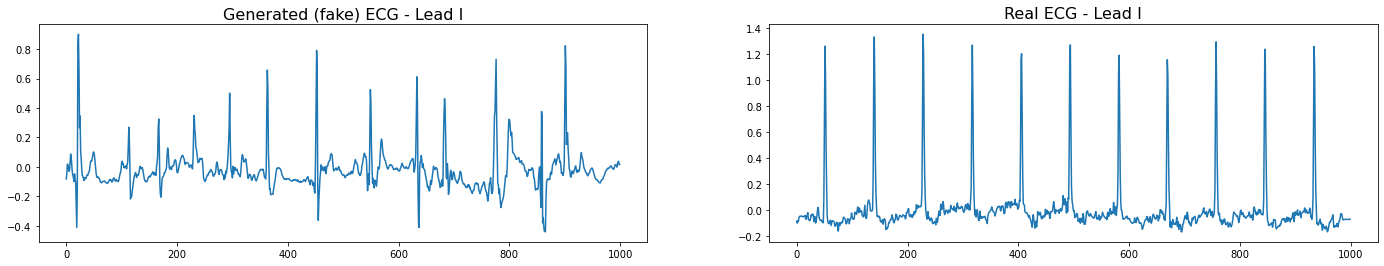

Generator AUROC: 0.0
Generator loss: 0.90047634
Descriminator AUROC: 0.51171875
Descriminator loss: 0.5515089
-------------------
epoch 192
Generator AUROC: 0.0
Generator loss: 0.90039986
Descriminator AUROC: 0.70703125
Descriminator loss: 0.5497226
-------------------
epoch 193
Generator AUROC: 0.0
Generator loss: 0.9003733
Descriminator AUROC: 0.55859375
Descriminator loss: 0.5536909
-------------------
epoch 194
Generator AUROC: 0.0
Generator loss: 0.90048665
Descriminator AUROC: 0.63671875
Descriminator loss: 0.55113494
-------------------
epoch 195
Generator AUROC: 0.0
Generator loss: 0.90046436
Descriminator AUROC: 0.7265625
Descriminator loss: 0.55100894
-------------------
epoch 196


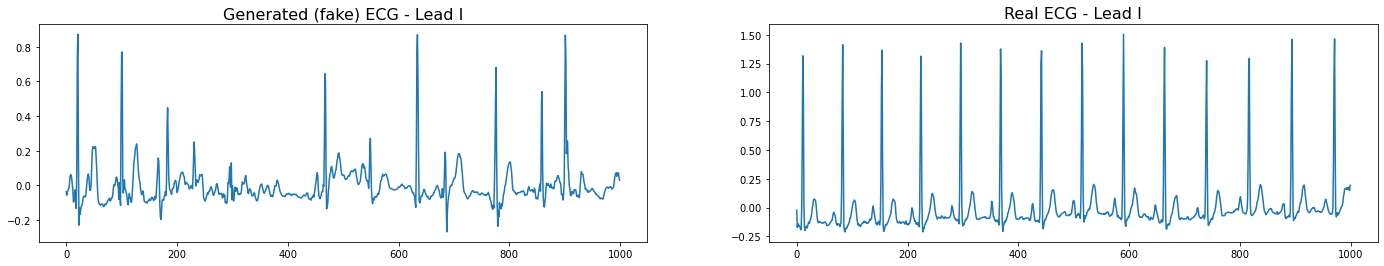

Generator AUROC: 0.0
Generator loss: 0.9004361
Descriminator AUROC: 0.453125
Descriminator loss: 0.55131936
-------------------
epoch 197
Generator AUROC: 0.0
Generator loss: 0.9003873
Descriminator AUROC: 0.546875
Descriminator loss: 0.550041
-------------------
epoch 198
Generator AUROC: 0.0
Generator loss: 0.9002992
Descriminator AUROC: 0.36328125
Descriminator loss: 0.5506104
-------------------
epoch 199
Generator AUROC: 0.0
Generator loss: 0.9005092
Descriminator AUROC: 0.40234375
Descriminator loss: 0.5542063
-------------------
epoch 200
Generator AUROC: 0.0
Generator loss: 0.90034974
Descriminator AUROC: 0.41796875
Descriminator loss: 0.55197585
-------------------
epoch 201


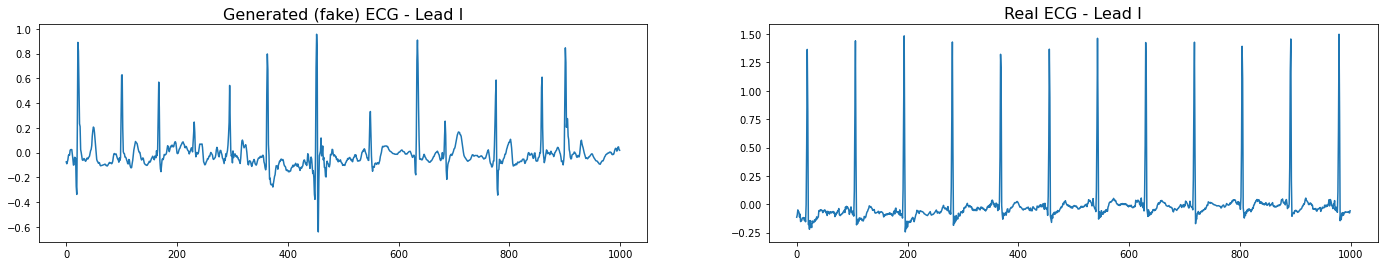

Generator AUROC: 0.0
Generator loss: 0.9003473
Descriminator AUROC: 0.3203125
Descriminator loss: 0.5503785
-------------------
epoch 202
Generator AUROC: 0.0
Generator loss: 0.900349
Descriminator AUROC: 0.4140625
Descriminator loss: 0.5534759
-------------------
epoch 203
Generator AUROC: 0.0
Generator loss: 0.9004699
Descriminator AUROC: 0.4375
Descriminator loss: 0.5555261
-------------------
epoch 204
Generator AUROC: 0.0
Generator loss: 0.90048665
Descriminator AUROC: 0.65234375
Descriminator loss: 0.55209774
-------------------
epoch 205
Generator AUROC: 0.0
Generator loss: 0.9005048
Descriminator AUROC: 0.58203125
Descriminator loss: 0.55443895
-------------------
epoch 206


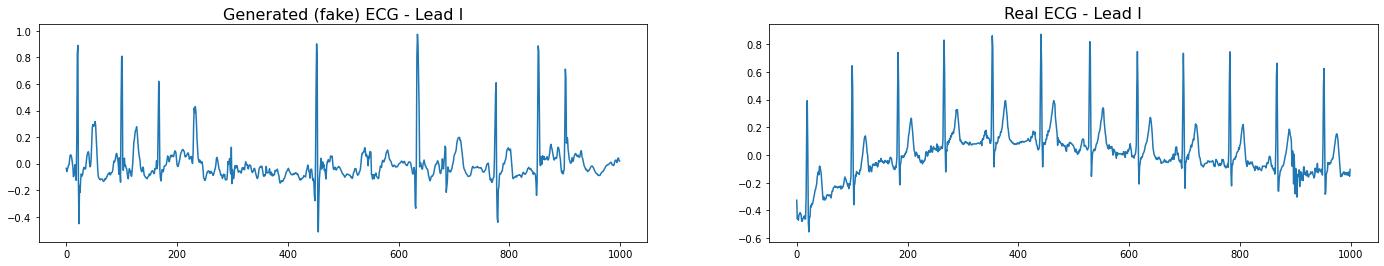

Generator AUROC: 0.0
Generator loss: 0.9003442
Descriminator AUROC: 0.484375
Descriminator loss: 0.55302763
-------------------
epoch 207
Generator AUROC: 0.0
Generator loss: 0.90042144
Descriminator AUROC: 0.40625
Descriminator loss: 0.5542936
-------------------
epoch 208
Generator AUROC: 0.0
Generator loss: 0.90032226
Descriminator AUROC: 0.58984375
Descriminator loss: 0.5518762
-------------------
epoch 209
Generator AUROC: 0.0
Generator loss: 0.90044487
Descriminator AUROC: 0.5390625
Descriminator loss: 0.55483454
-------------------
epoch 210
Generator AUROC: 0.0
Generator loss: 0.90031886
Descriminator AUROC: 0.578125
Descriminator loss: 0.55285025
-------------------
epoch 211


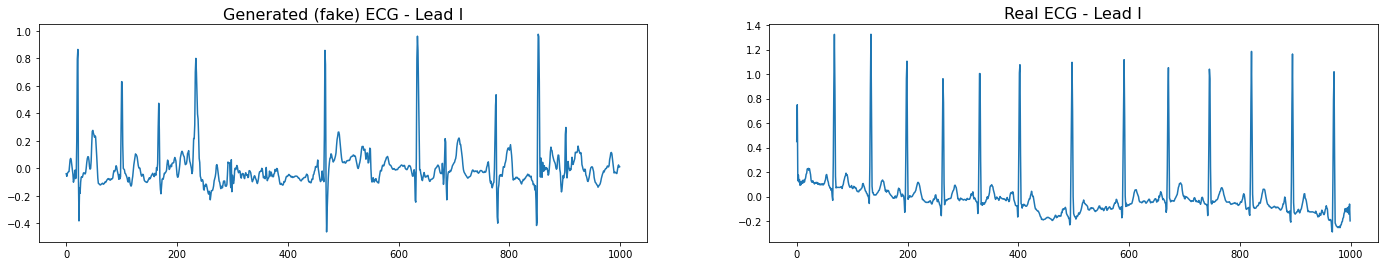

Generator AUROC: 0.0
Generator loss: 0.9003983
Descriminator AUROC: 0.27734375
Descriminator loss: 0.5514175
-------------------
epoch 212
Generator AUROC: 0.0
Generator loss: 0.9003772
Descriminator AUROC: 0.49609375
Descriminator loss: 0.5514657
-------------------
epoch 213
Generator AUROC: 0.0
Generator loss: 0.9002387
Descriminator AUROC: 0.52734375
Descriminator loss: 0.552511
-------------------
epoch 214
Generator AUROC: 0.0
Generator loss: 0.90039134
Descriminator AUROC: 0.48828125
Descriminator loss: 0.5541989
-------------------
epoch 215
Generator AUROC: 0.0
Generator loss: 0.90044254
Descriminator AUROC: 0.59765625
Descriminator loss: 0.5522065
-------------------
epoch 216


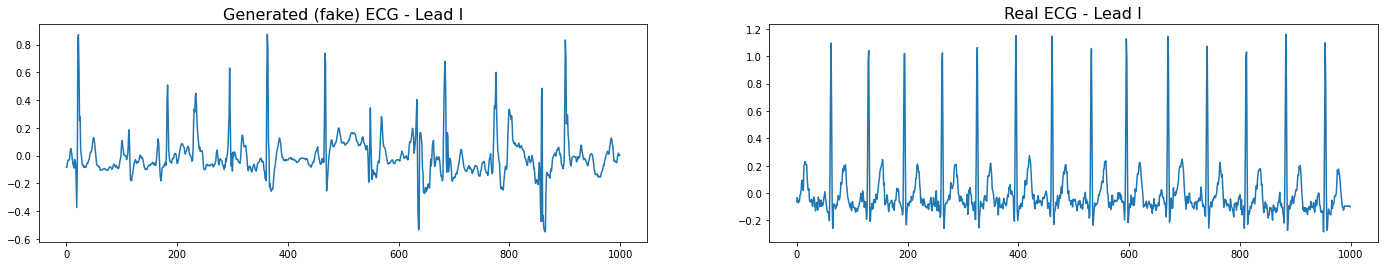

Generator AUROC: 0.0
Generator loss: 0.90053576
Descriminator AUROC: 0.50390625
Descriminator loss: 0.552302
-------------------
epoch 217
Generator AUROC: 0.0
Generator loss: 0.90043914
Descriminator AUROC: 0.44140625
Descriminator loss: 0.55707705
-------------------
epoch 218
Generator AUROC: 0.0
Generator loss: 0.90035427
Descriminator AUROC: 0.61328125
Descriminator loss: 0.55377316
-------------------
epoch 219
Generator AUROC: 0.0
Generator loss: 0.9003232
Descriminator AUROC: 0.53125
Descriminator loss: 0.5543663
-------------------
epoch 220
Generator AUROC: 0.0
Generator loss: 0.9004923
Descriminator AUROC: 0.56640625
Descriminator loss: 0.5514527
-------------------
epoch 221


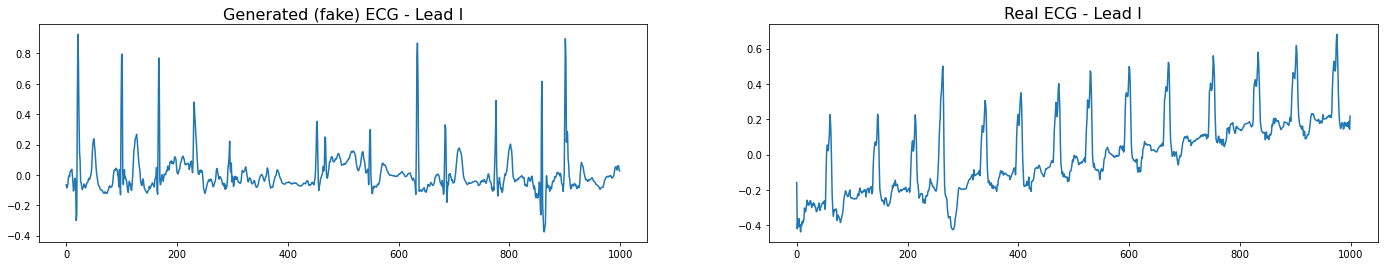

Generator AUROC: 0.0
Generator loss: 0.9003894
Descriminator AUROC: 0.66796875
Descriminator loss: 0.55407095
-------------------
epoch 222
Generator AUROC: 0.0
Generator loss: 0.90034765
Descriminator AUROC: 0.5625
Descriminator loss: 0.55403876
-------------------
epoch 223
Generator AUROC: 0.0
Generator loss: 0.9004033
Descriminator AUROC: 0.72265625
Descriminator loss: 0.55277467
-------------------
epoch 224
Generator AUROC: 0.0
Generator loss: 0.9004952
Descriminator AUROC: 0.38671875
Descriminator loss: 0.5529042
-------------------
epoch 225
Generator AUROC: 0.0
Generator loss: 0.90044993
Descriminator AUROC: 0.55078125
Descriminator loss: 0.55503386
-------------------
epoch 226


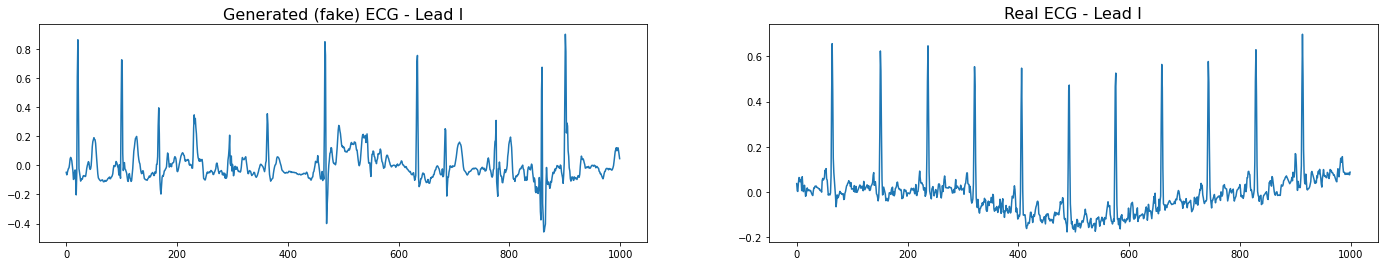

Generator AUROC: 0.0
Generator loss: 0.90053606
Descriminator AUROC: 0.41796875
Descriminator loss: 0.5509478
-------------------
epoch 227
Generator AUROC: 0.0
Generator loss: 0.90050364
Descriminator AUROC: 0.4921875
Descriminator loss: 0.55184597
-------------------
epoch 228
Generator AUROC: 0.0
Generator loss: 0.9003262
Descriminator AUROC: 0.515625
Descriminator loss: 0.5543749
-------------------
epoch 229
Generator AUROC: 0.0
Generator loss: 0.9004395
Descriminator AUROC: 0.5234375
Descriminator loss: 0.5511491
-------------------
epoch 230
Generator AUROC: 0.0
Generator loss: 0.90031904
Descriminator AUROC: 0.4296875
Descriminator loss: 0.5535382
-------------------
epoch 231


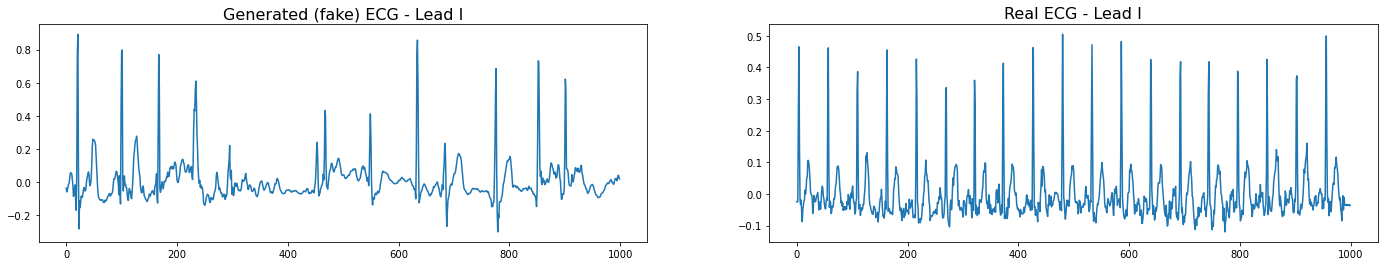

Generator AUROC: 0.0
Generator loss: 0.90042084
Descriminator AUROC: 0.48046875
Descriminator loss: 0.55091614
-------------------
epoch 232
Generator AUROC: 0.0
Generator loss: 0.9003019
Descriminator AUROC: 0.55078125
Descriminator loss: 0.55262995
-------------------
epoch 233
Generator AUROC: 0.0
Generator loss: 0.90046704
Descriminator AUROC: 0.28125
Descriminator loss: 0.55395794
-------------------
epoch 234
Generator AUROC: 0.0
Generator loss: 0.90045077
Descriminator AUROC: 0.453125
Descriminator loss: 0.5505366
-------------------
epoch 235
Generator AUROC: 0.0
Generator loss: 0.9004598
Descriminator AUROC: 0.52734375
Descriminator loss: 0.5584738
-------------------
epoch 236


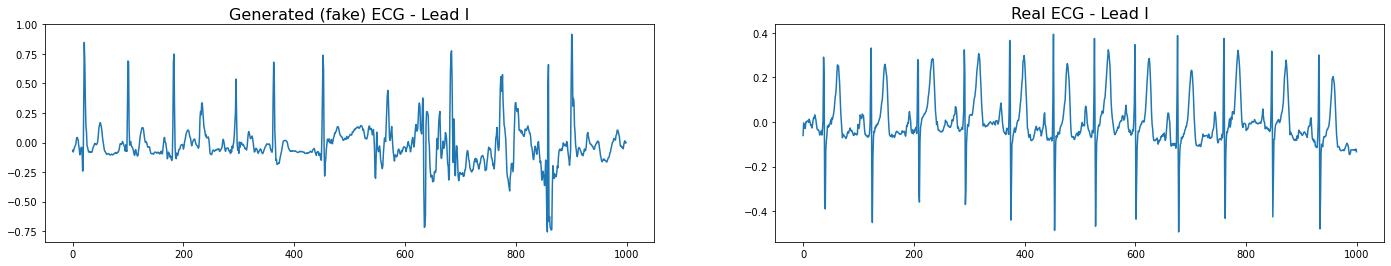

Generator AUROC: 0.0
Generator loss: 0.90026873
Descriminator AUROC: 0.24609375
Descriminator loss: 0.5531217
-------------------
epoch 237
Generator AUROC: 0.0
Generator loss: 0.9004205
Descriminator AUROC: 0.48828125
Descriminator loss: 0.5520245
-------------------
epoch 238
Generator AUROC: 0.0
Generator loss: 0.900581
Descriminator AUROC: 0.66015625
Descriminator loss: 0.55242866
-------------------
epoch 239
Generator AUROC: 0.0
Generator loss: 0.90032834
Descriminator AUROC: 0.55859375
Descriminator loss: 0.55175865
-------------------
epoch 240
Generator AUROC: 0.0
Generator loss: 0.9001807
Descriminator AUROC: 0.6796875
Descriminator loss: 0.55271447
-------------------
epoch 241


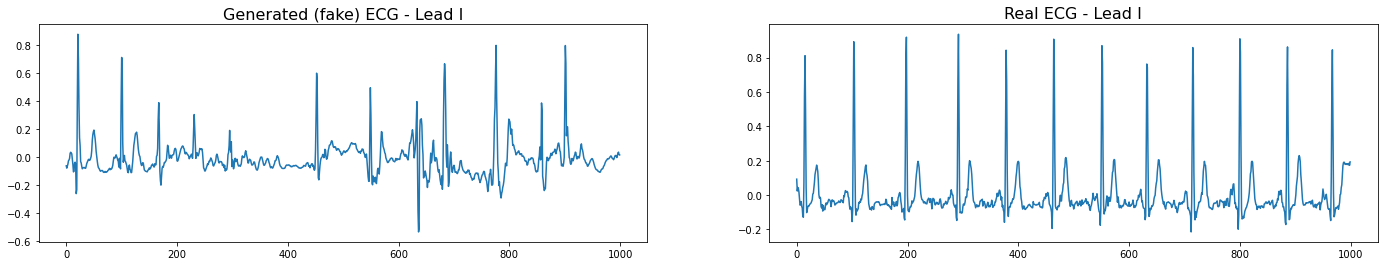

Generator AUROC: 0.0
Generator loss: 0.90048534
Descriminator AUROC: 0.43359375
Descriminator loss: 0.5530377
-------------------
epoch 242
Generator AUROC: 0.0
Generator loss: 0.9002386
Descriminator AUROC: 0.4921875
Descriminator loss: 0.5499536
-------------------
epoch 243
Generator AUROC: 0.0
Generator loss: 0.9005107
Descriminator AUROC: 0.5
Descriminator loss: 0.55377495
-------------------
epoch 244
Generator AUROC: 0.0
Generator loss: 0.90035945
Descriminator AUROC: 0.45703125
Descriminator loss: 0.55157006
-------------------
epoch 245
Generator AUROC: 0.0
Generator loss: 0.90046364
Descriminator AUROC: 0.50390625
Descriminator loss: 0.55318236
-------------------
epoch 246


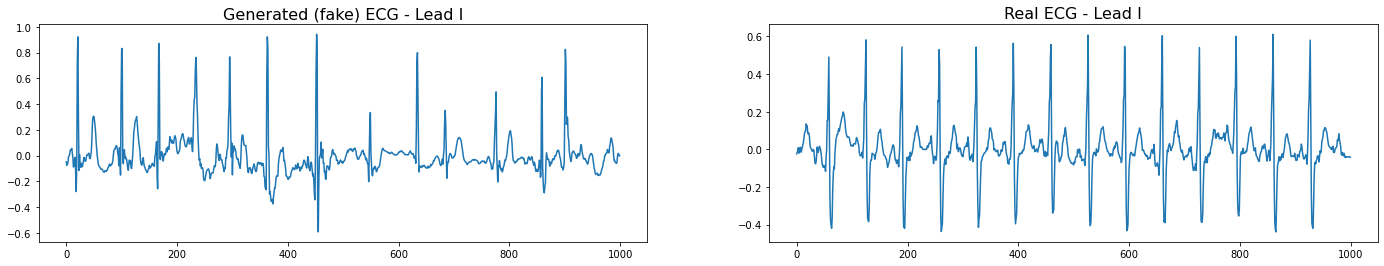

Generator AUROC: 0.0
Generator loss: 0.9004072
Descriminator AUROC: 0.6875
Descriminator loss: 0.5516285
-------------------
epoch 247
Generator AUROC: 0.0
Generator loss: 0.90037256
Descriminator AUROC: 0.3515625
Descriminator loss: 0.5524685
-------------------
epoch 248
Generator AUROC: 0.0
Generator loss: 0.90059286
Descriminator AUROC: 0.63671875
Descriminator loss: 0.55290914
-------------------
epoch 249
Generator AUROC: 0.0
Generator loss: 0.90035903
Descriminator AUROC: 0.7265625
Descriminator loss: 0.55231017
-------------------
epoch 250
Generator AUROC: 0.0
Generator loss: 0.90033257
Descriminator AUROC: 0.4140625
Descriminator loss: 0.5552327
-------------------
epoch 251


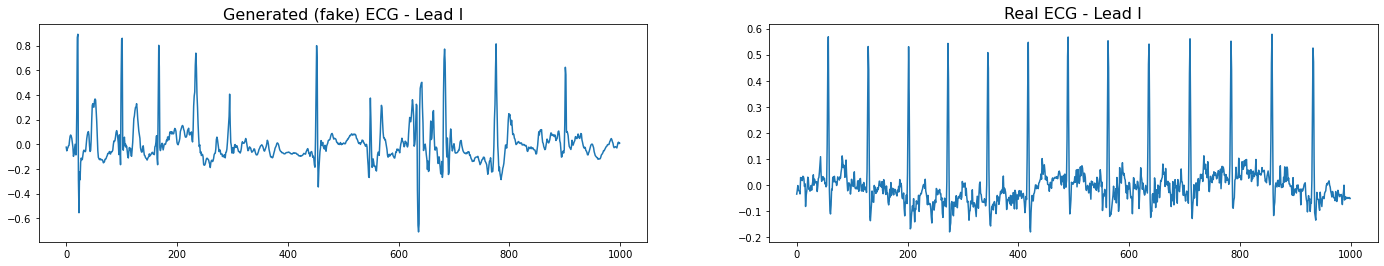

Generator AUROC: 0.0
Generator loss: 0.90048516
Descriminator AUROC: 0.4453125
Descriminator loss: 0.5538707
-------------------
epoch 252
Generator AUROC: 0.0
Generator loss: 0.9004427
Descriminator AUROC: 0.51953125
Descriminator loss: 0.5491026
-------------------
epoch 253
Generator AUROC: 0.0
Generator loss: 0.90043527
Descriminator AUROC: 0.609375
Descriminator loss: 0.5499438
-------------------
epoch 254
Generator AUROC: 0.0
Generator loss: 0.9004112
Descriminator AUROC: 0.55859375
Descriminator loss: 0.55115545
-------------------
epoch 255
Generator AUROC: 0.0
Generator loss: 0.9003273
Descriminator AUROC: 0.453125
Descriminator loss: 0.55301756
-------------------
epoch 256


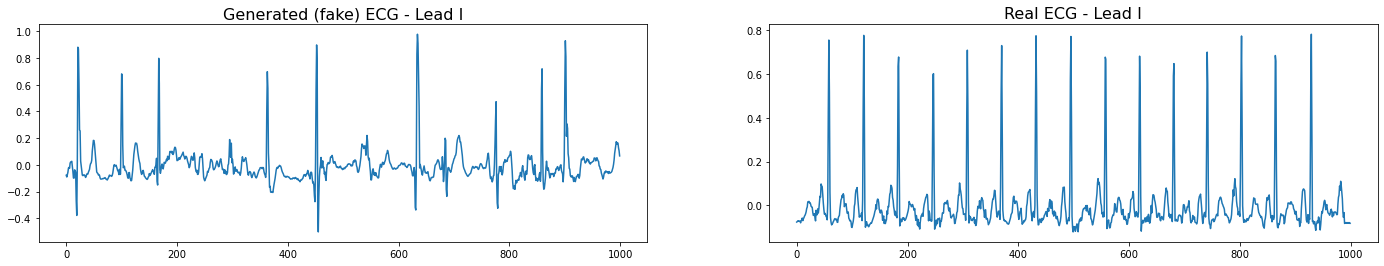

Generator AUROC: 0.0
Generator loss: 0.9003987
Descriminator AUROC: 0.3671875
Descriminator loss: 0.5526425
-------------------
epoch 257
Generator AUROC: 0.0
Generator loss: 0.9004788
Descriminator AUROC: 0.484375
Descriminator loss: 0.5529882
-------------------
epoch 258
Generator AUROC: 0.0
Generator loss: 0.9004325
Descriminator AUROC: 0.4296875
Descriminator loss: 0.5535904
-------------------
epoch 259
Generator AUROC: 0.0
Generator loss: 0.9004708
Descriminator AUROC: 0.609375
Descriminator loss: 0.55409044
-------------------
epoch 260
Generator AUROC: 0.0
Generator loss: 0.90047204
Descriminator AUROC: 0.6484375
Descriminator loss: 0.55195385
-------------------
epoch 261


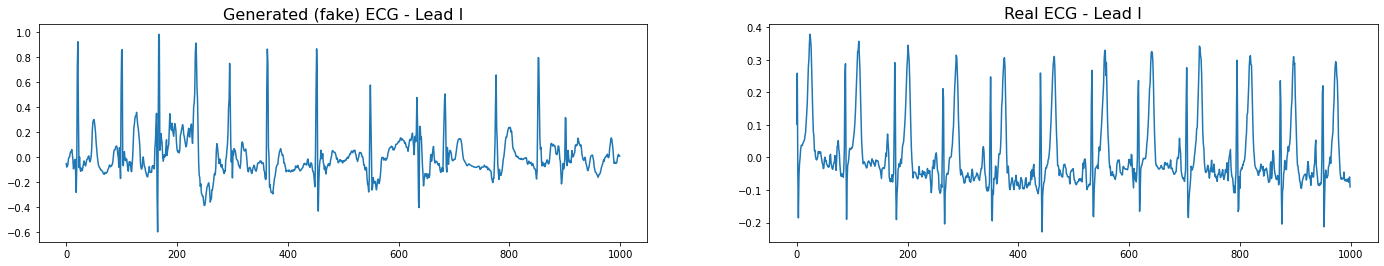

Generator AUROC: 0.0
Generator loss: 0.9004046
Descriminator AUROC: 0.58984375
Descriminator loss: 0.55288726
-------------------
epoch 262
Generator AUROC: 0.0
Generator loss: 0.9005134
Descriminator AUROC: 0.578125
Descriminator loss: 0.55278516
-------------------
epoch 263
Generator AUROC: 0.0
Generator loss: 0.90043324
Descriminator AUROC: 0.68359375
Descriminator loss: 0.55088747
-------------------
epoch 264
Generator AUROC: 0.0
Generator loss: 0.9003931
Descriminator AUROC: 0.57421875
Descriminator loss: 0.5543869
-------------------
epoch 265
Generator AUROC: 0.0
Generator loss: 0.9002728
Descriminator AUROC: 0.359375
Descriminator loss: 0.54989004
-------------------
epoch 266


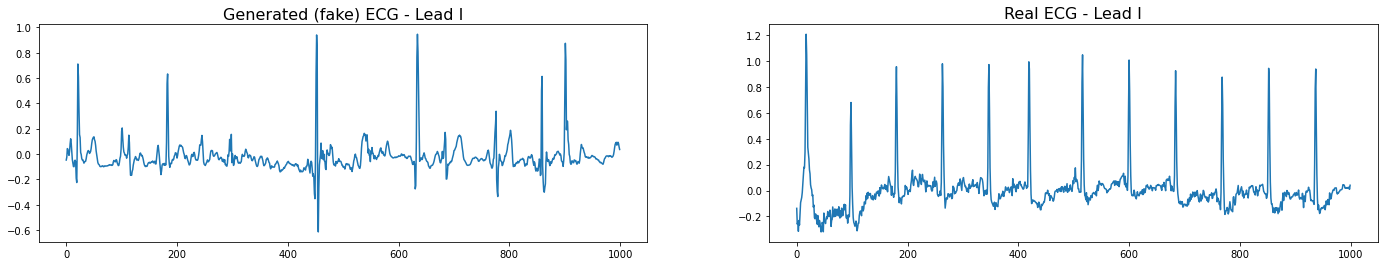

Generator AUROC: 0.0
Generator loss: 0.9003453
Descriminator AUROC: 0.53125
Descriminator loss: 0.5530552
-------------------
epoch 267
Generator AUROC: 0.0
Generator loss: 0.90047884
Descriminator AUROC: 0.4453125
Descriminator loss: 0.55250376
-------------------
epoch 268
Generator AUROC: 0.0
Generator loss: 0.9004674
Descriminator AUROC: 0.59765625
Descriminator loss: 0.55414516
-------------------
epoch 269
Generator AUROC: 0.0
Generator loss: 0.90054023
Descriminator AUROC: 0.4453125
Descriminator loss: 0.5532624
-------------------
epoch 270
Generator AUROC: 0.0
Generator loss: 0.90041333
Descriminator AUROC: 0.47265625
Descriminator loss: 0.55421287
-------------------
epoch 271


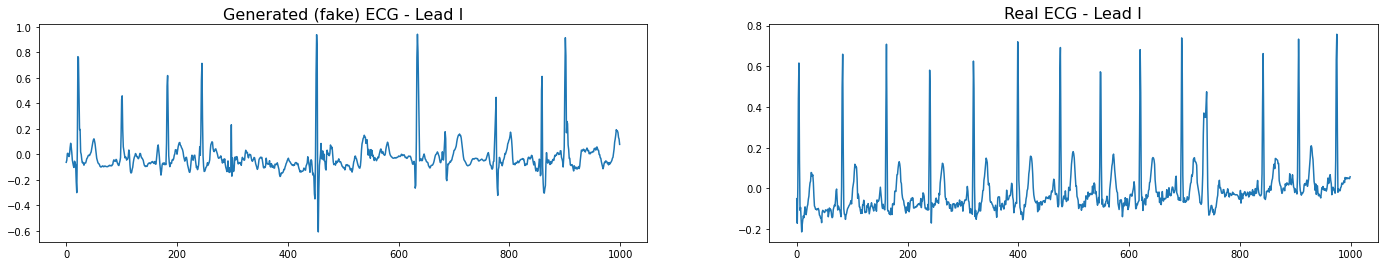

Generator AUROC: 0.0
Generator loss: 0.90039814
Descriminator AUROC: 0.27734375
Descriminator loss: 0.5527339
-------------------
epoch 272
Generator AUROC: 0.0
Generator loss: 0.900304
Descriminator AUROC: 0.41796875
Descriminator loss: 0.5551165
-------------------
epoch 273
Generator AUROC: 0.0
Generator loss: 0.9005712
Descriminator AUROC: 0.62109375
Descriminator loss: 0.55392087
-------------------
epoch 274
Generator AUROC: 0.0
Generator loss: 0.90039796
Descriminator AUROC: 0.515625
Descriminator loss: 0.5556985
-------------------
epoch 275
Generator AUROC: 0.0
Generator loss: 0.9004717
Descriminator AUROC: 0.37109375
Descriminator loss: 0.5511839
-------------------
epoch 276


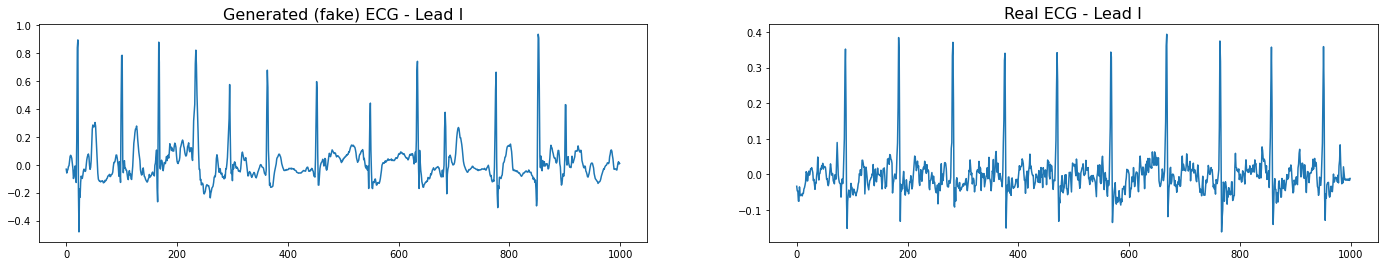

Generator AUROC: 0.0
Generator loss: 0.9005639
Descriminator AUROC: 0.453125
Descriminator loss: 0.55199313
-------------------
epoch 277
Generator AUROC: 0.0
Generator loss: 0.900366
Descriminator AUROC: 0.453125
Descriminator loss: 0.55182004
-------------------
epoch 278
Generator AUROC: 0.0
Generator loss: 0.9006115
Descriminator AUROC: 0.4140625
Descriminator loss: 0.551531
-------------------
epoch 279
Generator AUROC: 0.0
Generator loss: 0.9005052
Descriminator AUROC: 0.6796875
Descriminator loss: 0.5524634
-------------------
epoch 280
Generator AUROC: 0.0
Generator loss: 0.900442
Descriminator AUROC: 0.61328125
Descriminator loss: 0.55240005
-------------------
epoch 281


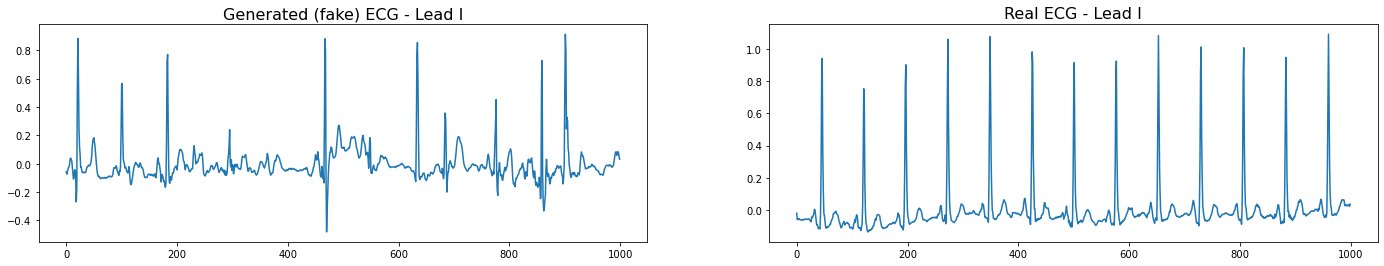

Generator AUROC: 0.0
Generator loss: 0.9004463
Descriminator AUROC: 0.53125
Descriminator loss: 0.5510596
-------------------
epoch 282
Generator AUROC: 0.0
Generator loss: 0.90047115
Descriminator AUROC: 0.6015625
Descriminator loss: 0.5523162
-------------------
epoch 283
Generator AUROC: 0.0
Generator loss: 0.9003905
Descriminator AUROC: 0.421875
Descriminator loss: 0.5525971
-------------------
epoch 284
Generator AUROC: 0.0
Generator loss: 0.9002186
Descriminator AUROC: 0.3046875
Descriminator loss: 0.55521977
-------------------
epoch 285
Generator AUROC: 0.0
Generator loss: 0.90045947
Descriminator AUROC: 0.4296875
Descriminator loss: 0.552025
-------------------
epoch 286


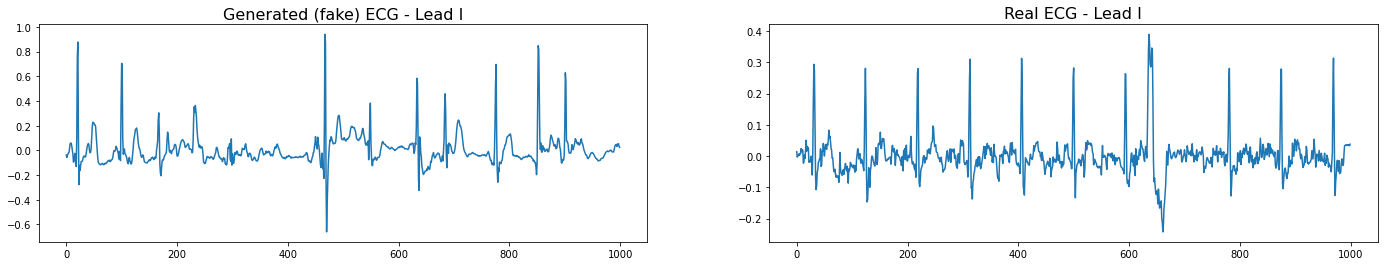

Generator AUROC: 0.0
Generator loss: 0.9004963
Descriminator AUROC: 0.4453125
Descriminator loss: 0.5517455
-------------------
epoch 287
Generator AUROC: 0.0
Generator loss: 0.90035284
Descriminator AUROC: 0.38671875
Descriminator loss: 0.5517073
-------------------
epoch 288
Generator AUROC: 0.0
Generator loss: 0.9005406
Descriminator AUROC: 0.40625
Descriminator loss: 0.55201775
-------------------
epoch 289
Generator AUROC: 0.0
Generator loss: 0.90039456
Descriminator AUROC: 0.34765625
Descriminator loss: 0.55522794
-------------------
epoch 290
Generator AUROC: 0.0
Generator loss: 0.9004579
Descriminator AUROC: 0.41015625
Descriminator loss: 0.55382663
-------------------
epoch 291


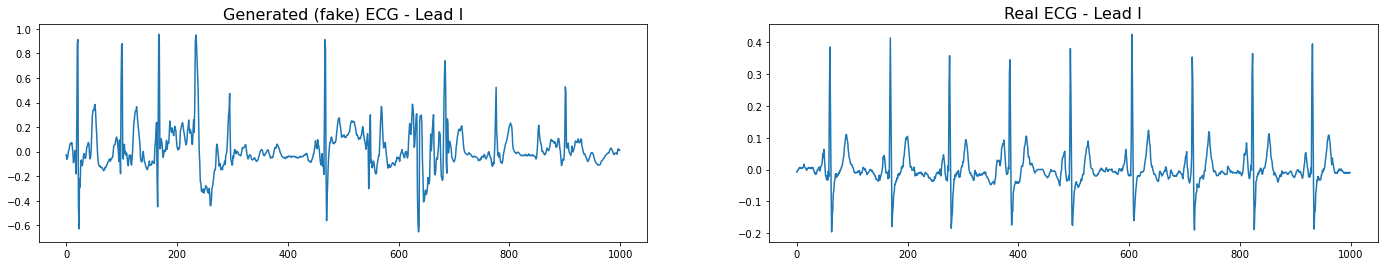

Generator AUROC: 0.0
Generator loss: 0.90050447
Descriminator AUROC: 0.3984375
Descriminator loss: 0.55530566
-------------------
epoch 292
Generator AUROC: 0.0
Generator loss: 0.90028316
Descriminator AUROC: 0.6015625
Descriminator loss: 0.5544024
-------------------
epoch 293
Generator AUROC: 0.0
Generator loss: 0.9003661
Descriminator AUROC: 0.4765625
Descriminator loss: 0.5503866
-------------------
epoch 294
Generator AUROC: 0.0
Generator loss: 0.90040153
Descriminator AUROC: 0.5078125
Descriminator loss: 0.55282694
-------------------
epoch 295
Generator AUROC: 0.0
Generator loss: 0.90038943
Descriminator AUROC: 0.328125
Descriminator loss: 0.55382377
-------------------
epoch 296


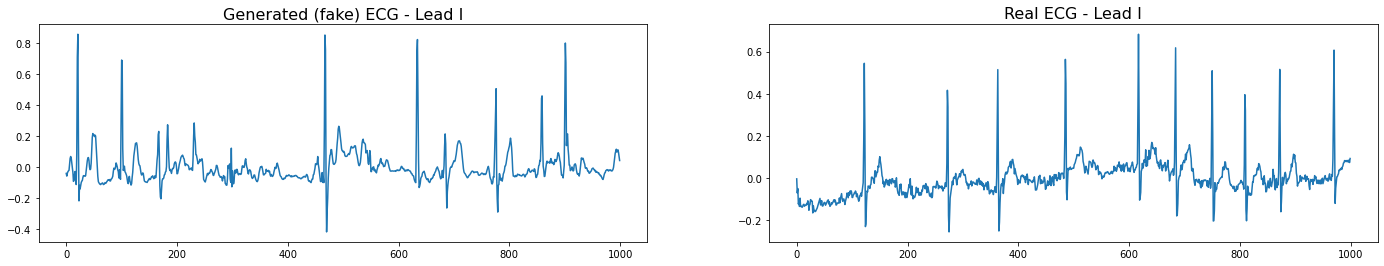

Generator AUROC: 0.0
Generator loss: 0.90030295
Descriminator AUROC: 0.43359375
Descriminator loss: 0.5531389
-------------------
epoch 297
Generator AUROC: 0.0
Generator loss: 0.9003847
Descriminator AUROC: 0.3203125
Descriminator loss: 0.5532138
-------------------
epoch 298
Generator AUROC: 0.0
Generator loss: 0.90026015
Descriminator AUROC: 0.484375
Descriminator loss: 0.5519982
-------------------
epoch 299
Generator AUROC: 0.0
Generator loss: 0.9004745
Descriminator AUROC: 0.3828125
Descriminator loss: 0.550336
-------------------
epoch 300
Generator AUROC: 0.0
Generator loss: 0.9004508
Descriminator AUROC: 0.484375
Descriminator loss: 0.55569094
-------------------
epoch 301


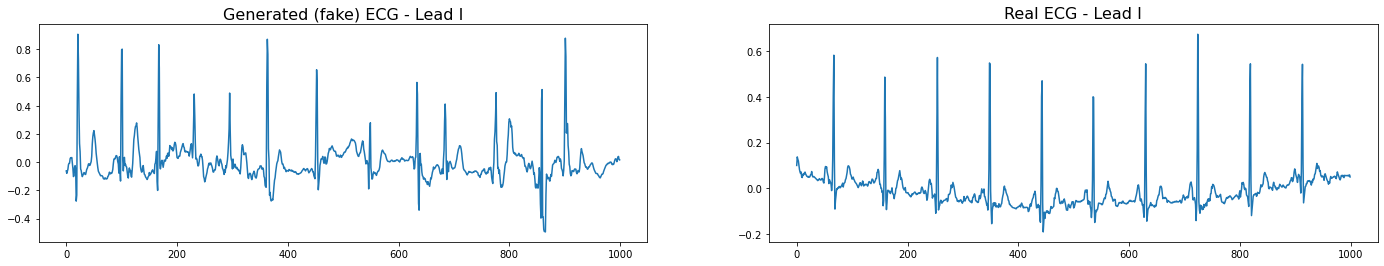

Generator AUROC: 0.0
Generator loss: 0.900413
Descriminator AUROC: 0.53125
Descriminator loss: 0.55238736
-------------------
epoch 302
Generator AUROC: 0.0
Generator loss: 0.9003891
Descriminator AUROC: 0.5078125
Descriminator loss: 0.551445
-------------------
epoch 303
Generator AUROC: 0.0
Generator loss: 0.9004847
Descriminator AUROC: 0.47265625
Descriminator loss: 0.55156094
-------------------
epoch 304
Generator AUROC: 0.0
Generator loss: 0.9004108
Descriminator AUROC: 0.6796875
Descriminator loss: 0.5539352
-------------------
epoch 305
Generator AUROC: 0.0
Generator loss: 0.90045434
Descriminator AUROC: 0.5625
Descriminator loss: 0.5550044
-------------------
epoch 306


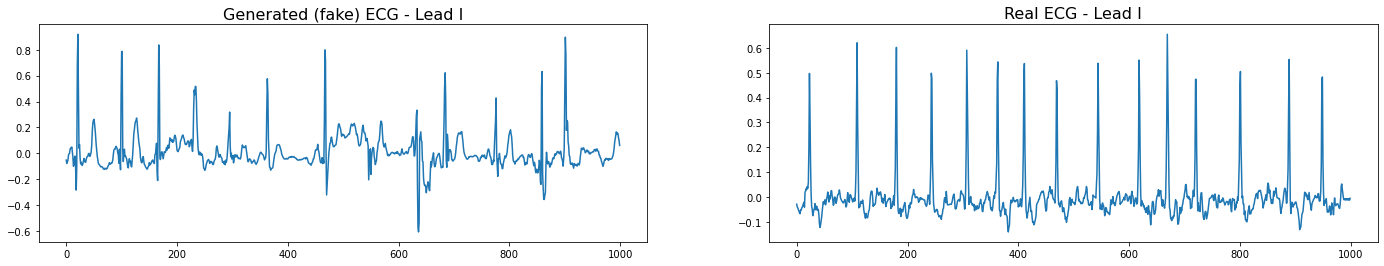

Generator AUROC: 0.0
Generator loss: 0.9005038
Descriminator AUROC: 0.5078125
Descriminator loss: 0.55536705
-------------------
epoch 307
Generator AUROC: 0.0
Generator loss: 0.900355
Descriminator AUROC: 0.46484375
Descriminator loss: 0.5541896
-------------------
epoch 308
Generator AUROC: 0.0
Generator loss: 0.90036404
Descriminator AUROC: 0.5
Descriminator loss: 0.5504774
-------------------
epoch 309
Generator AUROC: 0.0
Generator loss: 0.9003947
Descriminator AUROC: 0.3671875
Descriminator loss: 0.55323976
-------------------
epoch 310
Generator AUROC: 0.0
Generator loss: 0.90030026
Descriminator AUROC: 0.41796875
Descriminator loss: 0.55490005
-------------------
epoch 311


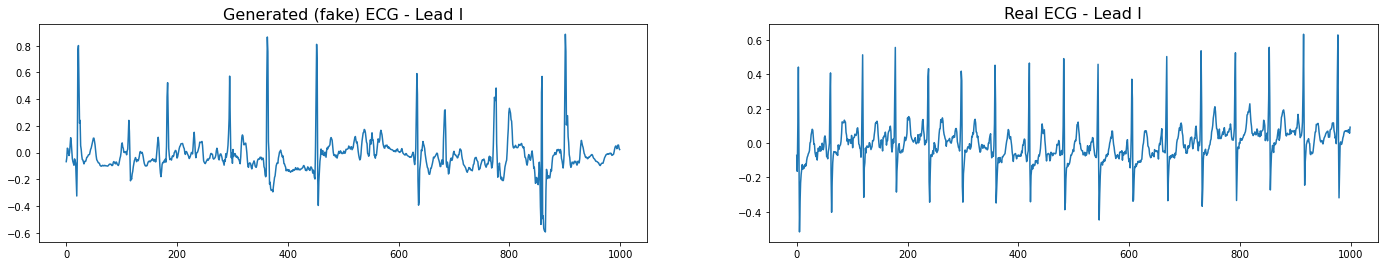

Generator AUROC: 0.0
Generator loss: 0.90059394
Descriminator AUROC: 0.7421875
Descriminator loss: 0.55093086
-------------------
epoch 312
Generator AUROC: 0.0
Generator loss: 0.90044343
Descriminator AUROC: 0.375
Descriminator loss: 0.55260384
-------------------
epoch 313
Generator AUROC: 0.0
Generator loss: 0.90036243
Descriminator AUROC: 0.39453125
Descriminator loss: 0.5535069
-------------------
epoch 314
Generator AUROC: 0.0
Generator loss: 0.90046704
Descriminator AUROC: 0.56640625
Descriminator loss: 0.5502082
-------------------
epoch 315
Generator AUROC: 0.0
Generator loss: 0.90043217
Descriminator AUROC: 0.3125
Descriminator loss: 0.55406773
-------------------
epoch 316


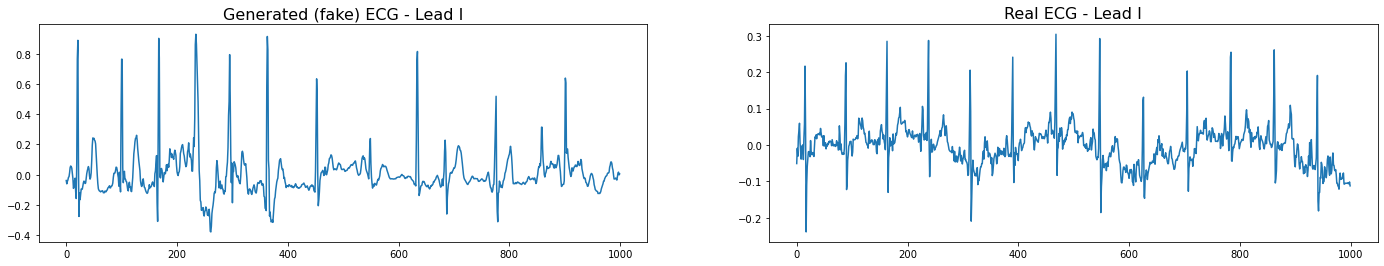

Generator AUROC: 0.0
Generator loss: 0.900362
Descriminator AUROC: 0.44921875
Descriminator loss: 0.5546926
-------------------
epoch 317
Generator AUROC: 0.0
Generator loss: 0.90048516
Descriminator AUROC: 0.51171875
Descriminator loss: 0.5534232
-------------------
epoch 318
Generator AUROC: 0.0
Generator loss: 0.90039754
Descriminator AUROC: 0.69140625
Descriminator loss: 0.5511322
-------------------
epoch 319
Generator AUROC: 0.0
Generator loss: 0.9005027
Descriminator AUROC: 0.546875
Descriminator loss: 0.5521123
-------------------
epoch 320
Generator AUROC: 0.0
Generator loss: 0.900321
Descriminator AUROC: 0.59765625
Descriminator loss: 0.5528548
-------------------
epoch 321


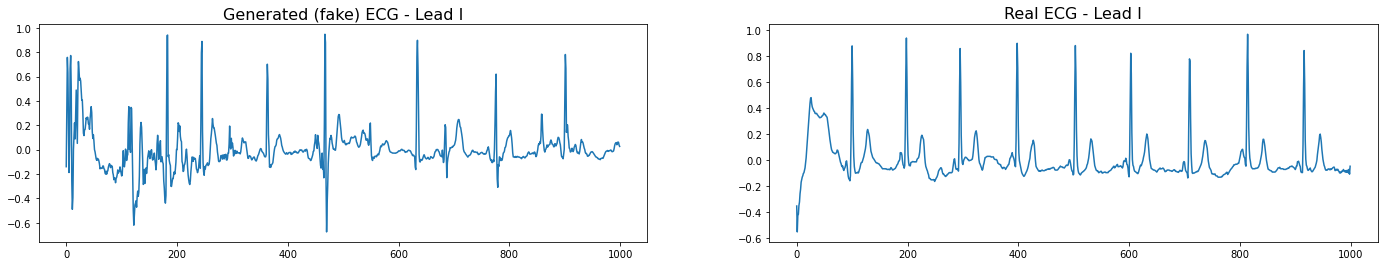

Generator AUROC: 0.0
Generator loss: 0.90039015
Descriminator AUROC: 0.671875
Descriminator loss: 0.5508848
-------------------
epoch 322
Generator AUROC: 0.0
Generator loss: 0.9004545
Descriminator AUROC: 0.59375
Descriminator loss: 0.55258495
-------------------
epoch 323
Generator AUROC: 0.0
Generator loss: 0.9001652
Descriminator AUROC: 0.63671875
Descriminator loss: 0.55230767
-------------------
epoch 324
Generator AUROC: 0.0
Generator loss: 0.9003001
Descriminator AUROC: 0.359375
Descriminator loss: 0.5540027
-------------------
epoch 325
Generator AUROC: 0.0
Generator loss: 0.90021443
Descriminator AUROC: 0.6015625
Descriminator loss: 0.5554442
-------------------
epoch 326


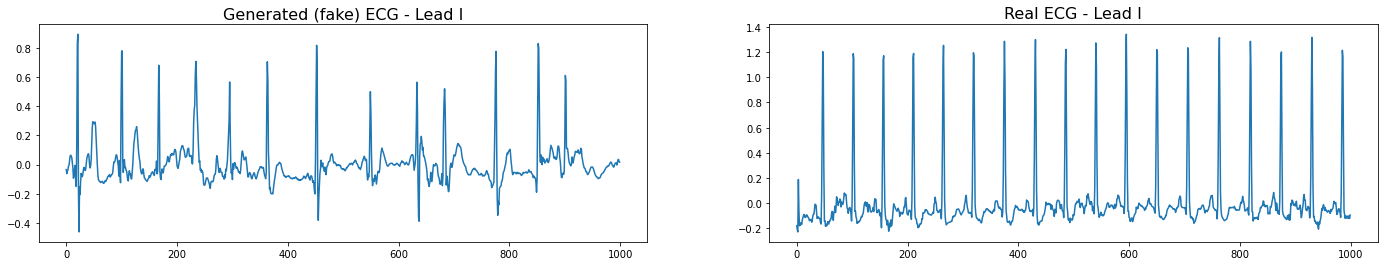

Generator AUROC: 0.0
Generator loss: 0.90047115
Descriminator AUROC: 0.54296875
Descriminator loss: 0.5524328
-------------------
epoch 327
Generator AUROC: 0.0
Generator loss: 0.90045774
Descriminator AUROC: 0.68359375
Descriminator loss: 0.551082
-------------------
epoch 328
Generator AUROC: 0.0
Generator loss: 0.90040743
Descriminator AUROC: 0.375
Descriminator loss: 0.5529481
-------------------
epoch 329
Generator AUROC: 0.0
Generator loss: 0.90040314
Descriminator AUROC: 0.34375
Descriminator loss: 0.5509402
-------------------
epoch 330
Generator AUROC: 0.0
Generator loss: 0.9004279
Descriminator AUROC: 0.375
Descriminator loss: 0.5534233
-------------------
epoch 331


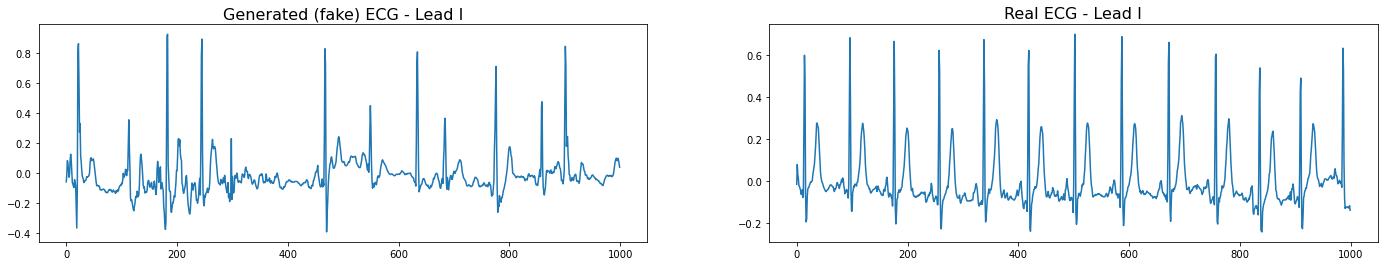

Generator AUROC: 0.0
Generator loss: 0.9003705
Descriminator AUROC: 0.48828125
Descriminator loss: 0.554199
-------------------
epoch 332
Generator AUROC: 0.0
Generator loss: 0.90033954
Descriminator AUROC: 0.53515625
Descriminator loss: 0.5558069
-------------------
epoch 333
Generator AUROC: 0.0
Generator loss: 0.9004983
Descriminator AUROC: 0.4140625
Descriminator loss: 0.55369455
-------------------
epoch 334
Generator AUROC: 0.0
Generator loss: 0.9003806
Descriminator AUROC: 0.57421875
Descriminator loss: 0.55328906
-------------------
epoch 335
Generator AUROC: 0.0
Generator loss: 0.90047044
Descriminator AUROC: 0.6171875
Descriminator loss: 0.5532378
-------------------
epoch 336


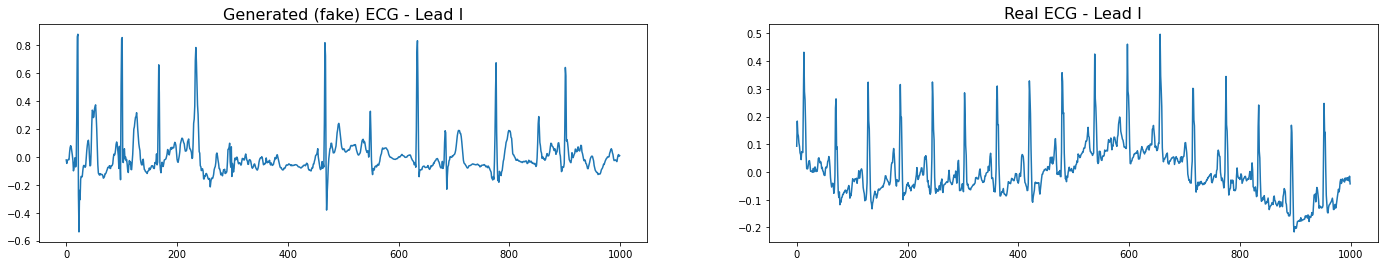

Generator AUROC: 0.0
Generator loss: 0.9004319
Descriminator AUROC: 0.46484375
Descriminator loss: 0.55528367
-------------------
epoch 337
Generator AUROC: 0.0
Generator loss: 0.90027356
Descriminator AUROC: 0.6484375
Descriminator loss: 0.5505148
-------------------
epoch 338
Generator AUROC: 0.0
Generator loss: 0.9001758
Descriminator AUROC: 0.65234375
Descriminator loss: 0.55432874
-------------------
epoch 339
Generator AUROC: 0.0
Generator loss: 0.9003798
Descriminator AUROC: 0.5390625
Descriminator loss: 0.5504488
-------------------
epoch 340
Generator AUROC: 0.0
Generator loss: 0.90029955
Descriminator AUROC: 0.48046875
Descriminator loss: 0.5528529
-------------------
epoch 341


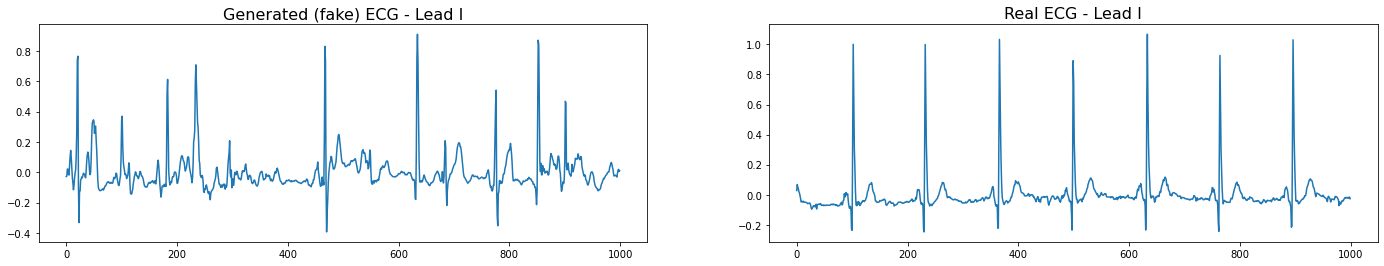

Generator AUROC: 0.0
Generator loss: 0.90054584
Descriminator AUROC: 0.48828125
Descriminator loss: 0.55156404
-------------------
epoch 342
Generator AUROC: 0.0
Generator loss: 0.90029234
Descriminator AUROC: 0.59765625
Descriminator loss: 0.5515781
-------------------
epoch 343
Generator AUROC: 0.0
Generator loss: 0.90023667
Descriminator AUROC: 0.6640625
Descriminator loss: 0.55336905
-------------------
epoch 344
Generator AUROC: 0.0
Generator loss: 0.90051496
Descriminator AUROC: 0.43359375
Descriminator loss: 0.55075693
-------------------
epoch 345
Generator AUROC: 0.0
Generator loss: 0.9004292
Descriminator AUROC: 0.53125
Descriminator loss: 0.55354804
-------------------
epoch 346


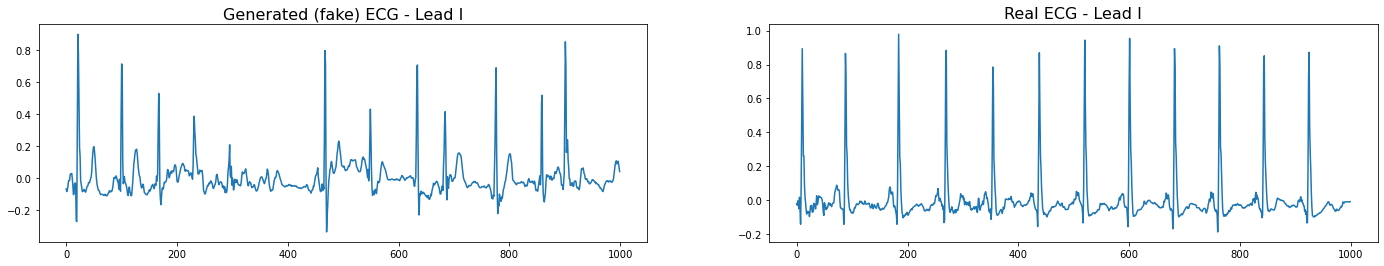

Generator AUROC: 0.0
Generator loss: 0.9004949
Descriminator AUROC: 0.5
Descriminator loss: 0.5513775
-------------------
epoch 347
Generator AUROC: 0.0
Generator loss: 0.90053684
Descriminator AUROC: 0.453125
Descriminator loss: 0.5499812
-------------------
epoch 348
Generator AUROC: 0.0
Generator loss: 0.9003101
Descriminator AUROC: 0.3828125
Descriminator loss: 0.5516796
-------------------
epoch 349
Generator AUROC: 0.0
Generator loss: 0.9004988
Descriminator AUROC: 0.4921875
Descriminator loss: 0.5488038
-------------------
epoch 350
Generator AUROC: 0.0
Generator loss: 0.90029174
Descriminator AUROC: 0.58984375
Descriminator loss: 0.5557539
-------------------
epoch 351


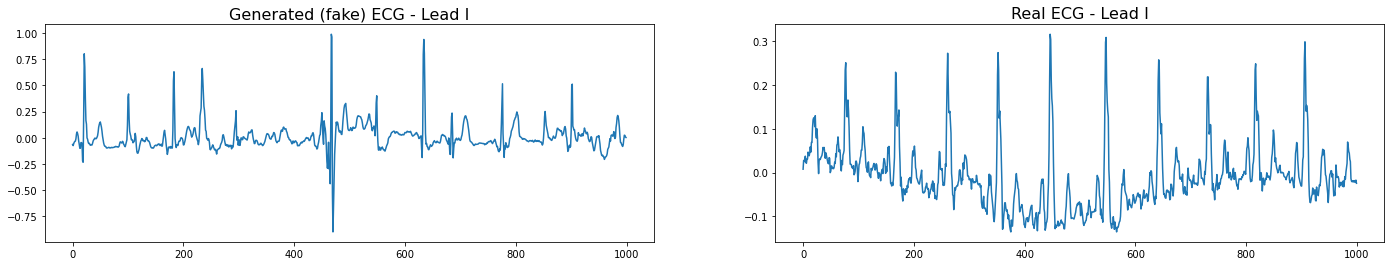

Generator AUROC: 0.0
Generator loss: 0.9003974
Descriminator AUROC: 0.5703125
Descriminator loss: 0.5532437
-------------------
epoch 352
Generator AUROC: 0.0
Generator loss: 0.90054625
Descriminator AUROC: 0.42578125
Descriminator loss: 0.5497533
-------------------
epoch 353
Generator AUROC: 0.0
Generator loss: 0.9004785
Descriminator AUROC: 0.515625
Descriminator loss: 0.5489411
-------------------
epoch 354
Generator AUROC: 0.0
Generator loss: 0.90028554
Descriminator AUROC: 0.49609375
Descriminator loss: 0.5515545
-------------------
epoch 355
Generator AUROC: 0.0
Generator loss: 0.90042275
Descriminator AUROC: 0.3515625
Descriminator loss: 0.5536286
-------------------
epoch 356


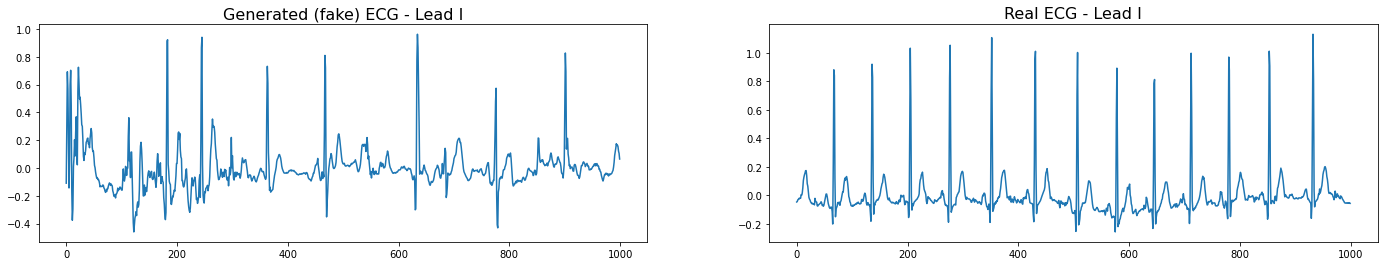

Generator AUROC: 0.0
Generator loss: 0.9004888
Descriminator AUROC: 0.5859375
Descriminator loss: 0.55264527
-------------------
epoch 357
Generator AUROC: 0.0
Generator loss: 0.9004658
Descriminator AUROC: 0.6171875
Descriminator loss: 0.5549461
-------------------
epoch 358
Generator AUROC: 0.0
Generator loss: 0.90026397
Descriminator AUROC: 0.4765625
Descriminator loss: 0.55118036
-------------------
epoch 359
Generator AUROC: 0.0
Generator loss: 0.9002886
Descriminator AUROC: 0.578125
Descriminator loss: 0.5530783
-------------------
epoch 360
Generator AUROC: 0.0
Generator loss: 0.90042555
Descriminator AUROC: 0.48828125
Descriminator loss: 0.5532689
-------------------
epoch 361


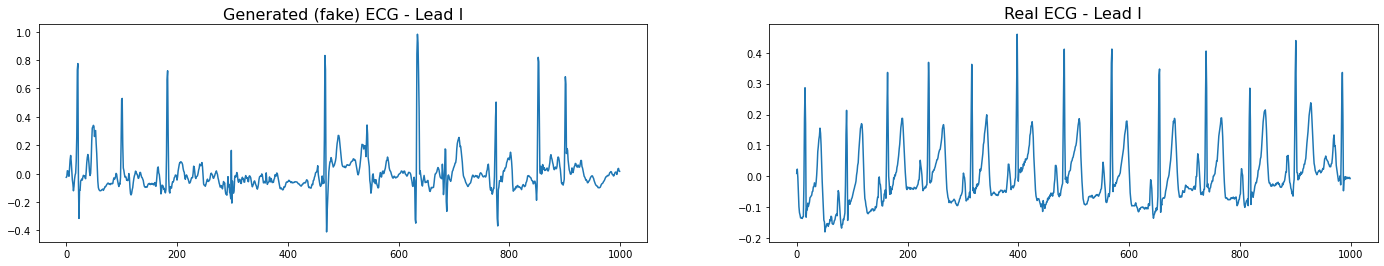

Generator AUROC: 0.0
Generator loss: 0.90047455
Descriminator AUROC: 0.50390625
Descriminator loss: 0.55438817
-------------------
epoch 362
Generator AUROC: 0.0
Generator loss: 0.9003008
Descriminator AUROC: 0.359375
Descriminator loss: 0.5493357
-------------------
epoch 363
Generator AUROC: 0.0
Generator loss: 0.9004345
Descriminator AUROC: 0.4765625
Descriminator loss: 0.55438566
-------------------
epoch 364
Generator AUROC: 0.0
Generator loss: 0.90040326
Descriminator AUROC: 0.44140625
Descriminator loss: 0.55616355
-------------------
epoch 365
Generator AUROC: 0.0
Generator loss: 0.9003822
Descriminator AUROC: 0.3515625
Descriminator loss: 0.54900146
-------------------
epoch 366


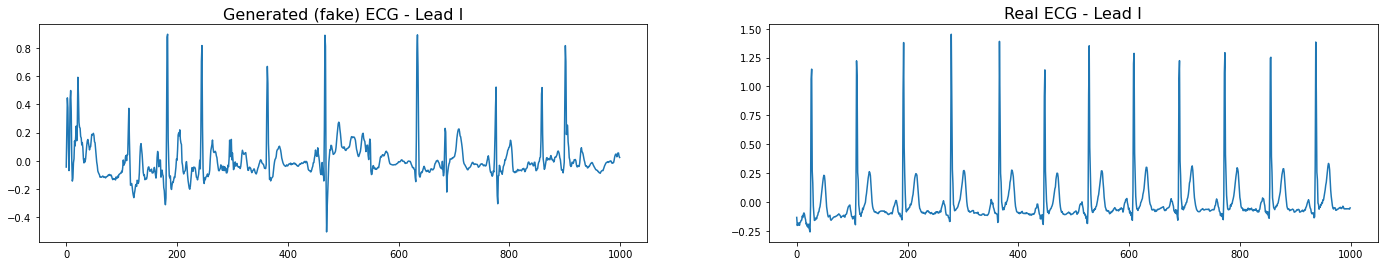

Generator AUROC: 0.0
Generator loss: 0.90038526
Descriminator AUROC: 0.45703125
Descriminator loss: 0.5505659
-------------------
epoch 367
Generator AUROC: 0.0
Generator loss: 0.9004934
Descriminator AUROC: 0.39453125
Descriminator loss: 0.55248934
-------------------
epoch 368
Generator AUROC: 0.0
Generator loss: 0.9003243
Descriminator AUROC: 0.60546875
Descriminator loss: 0.55470985
-------------------
epoch 369
Generator AUROC: 0.0
Generator loss: 0.9003406
Descriminator AUROC: 0.57421875
Descriminator loss: 0.5500676
-------------------
epoch 370
Generator AUROC: 0.0
Generator loss: 0.900372
Descriminator AUROC: 0.53125
Descriminator loss: 0.5538094
-------------------
epoch 371


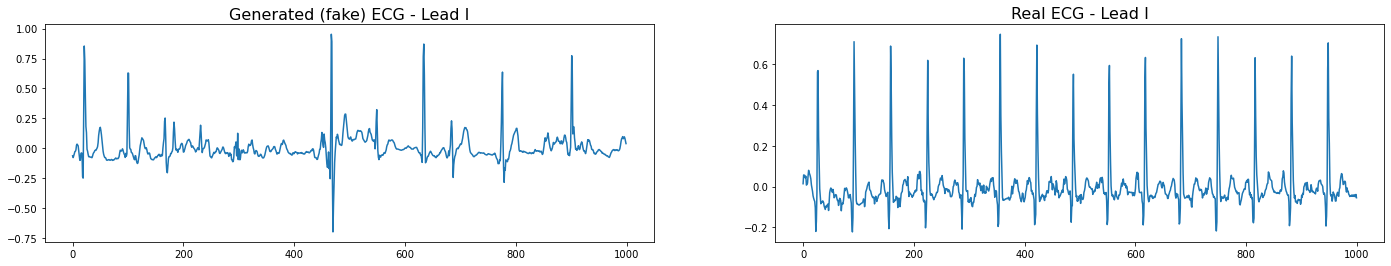

Generator AUROC: 0.0
Generator loss: 0.90047026
Descriminator AUROC: 0.75
Descriminator loss: 0.5517386
-------------------
epoch 372
Generator AUROC: 0.0
Generator loss: 0.9004258
Descriminator AUROC: 0.453125
Descriminator loss: 0.5551076
-------------------
epoch 373
Generator AUROC: 0.0
Generator loss: 0.90059984
Descriminator AUROC: 0.3359375
Descriminator loss: 0.5541476
-------------------
epoch 374
Generator AUROC: 0.0
Generator loss: 0.90055037
Descriminator AUROC: 0.51171875
Descriminator loss: 0.54924655
-------------------
epoch 375
Generator AUROC: 0.0
Generator loss: 0.90041524
Descriminator AUROC: 0.4921875
Descriminator loss: 0.55364496
-------------------
epoch 376


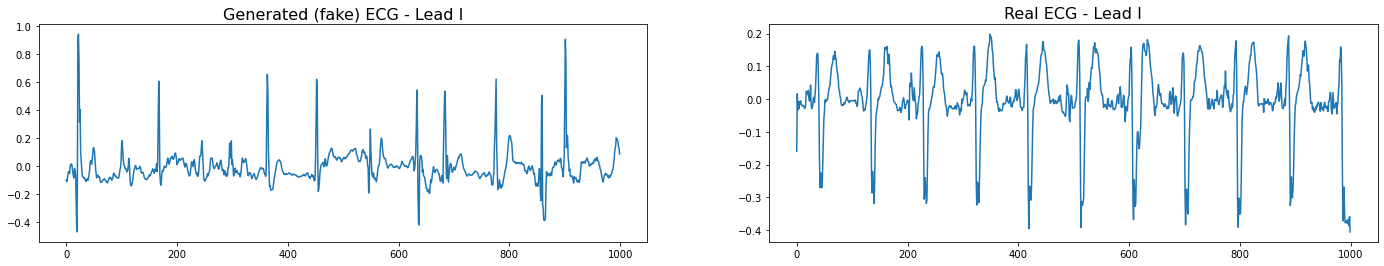

Generator AUROC: 0.0
Generator loss: 0.90040636
Descriminator AUROC: 0.57421875
Descriminator loss: 0.5534252
-------------------
epoch 377
Generator AUROC: 0.0
Generator loss: 0.90053487
Descriminator AUROC: 0.453125
Descriminator loss: 0.55230576
-------------------
epoch 378
Generator AUROC: 0.0
Generator loss: 0.90049034
Descriminator AUROC: 0.4375
Descriminator loss: 0.55258834
-------------------
epoch 379
Generator AUROC: 0.0
Generator loss: 0.90049845
Descriminator AUROC: 0.57421875
Descriminator loss: 0.5523589
-------------------
epoch 380
Generator AUROC: 0.0
Generator loss: 0.9004452
Descriminator AUROC: 0.48828125
Descriminator loss: 0.55103254
-------------------
epoch 381


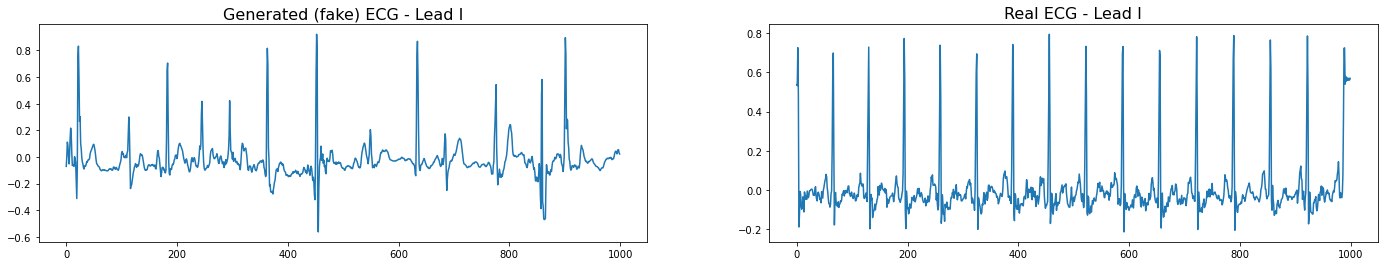

Generator AUROC: 0.0
Generator loss: 0.9004438
Descriminator AUROC: 0.390625
Descriminator loss: 0.5524592
-------------------
epoch 382
Generator AUROC: 0.0
Generator loss: 0.9003555
Descriminator AUROC: 0.5546875
Descriminator loss: 0.5507749
-------------------
epoch 383
Generator AUROC: 0.0
Generator loss: 0.9003798
Descriminator AUROC: 0.46484375
Descriminator loss: 0.55016774
-------------------
epoch 384
Generator AUROC: 0.0
Generator loss: 0.90041566
Descriminator AUROC: 0.46484375
Descriminator loss: 0.55489886
-------------------
epoch 385
Generator AUROC: 0.0
Generator loss: 0.9002986
Descriminator AUROC: 0.55859375
Descriminator loss: 0.5552627
-------------------
epoch 386


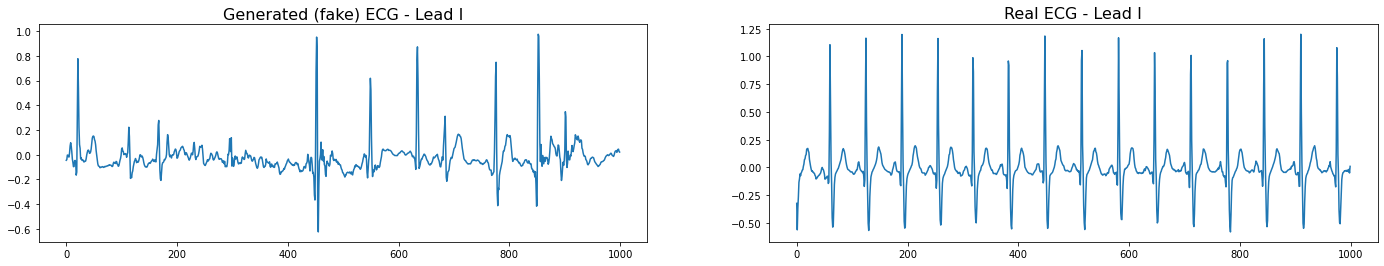

Generator AUROC: 0.0
Generator loss: 0.9004365
Descriminator AUROC: 0.61328125
Descriminator loss: 0.54963154
-------------------
epoch 387
Generator AUROC: 0.0
Generator loss: 0.9004488
Descriminator AUROC: 0.27734375
Descriminator loss: 0.55644244
-------------------
epoch 388
Generator AUROC: 0.0
Generator loss: 0.9004502
Descriminator AUROC: 0.4453125
Descriminator loss: 0.5513864
-------------------
epoch 389
Generator AUROC: 0.0
Generator loss: 0.90045536
Descriminator AUROC: 0.5
Descriminator loss: 0.5526792
-------------------
epoch 390
Generator AUROC: 0.0
Generator loss: 0.9005293
Descriminator AUROC: 0.58203125
Descriminator loss: 0.5510781
-------------------
epoch 391


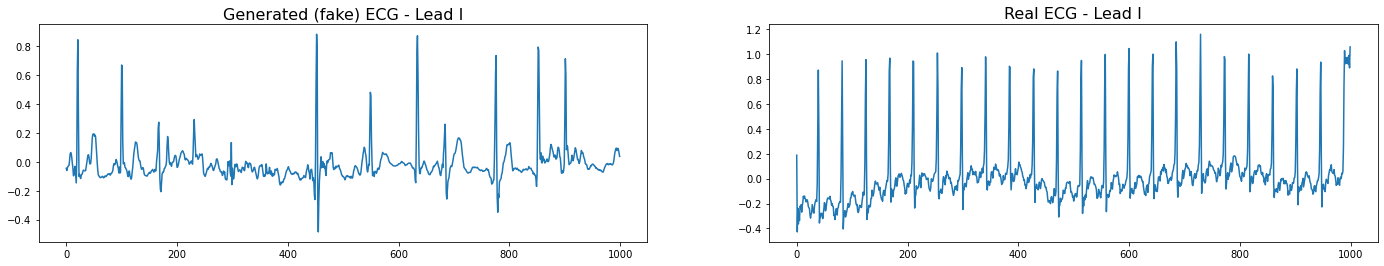

Generator AUROC: 0.0
Generator loss: 0.90043896
Descriminator AUROC: 0.51171875
Descriminator loss: 0.55202895
-------------------
epoch 392
Generator AUROC: 0.0
Generator loss: 0.90035784
Descriminator AUROC: 0.46484375
Descriminator loss: 0.5516093
-------------------
epoch 393
Generator AUROC: 0.0
Generator loss: 0.90046346
Descriminator AUROC: 0.46484375
Descriminator loss: 0.55261385
-------------------
epoch 394
Generator AUROC: 0.0
Generator loss: 0.90027624
Descriminator AUROC: 0.4453125
Descriminator loss: 0.55134815
-------------------
epoch 395
Generator AUROC: 0.0
Generator loss: 0.9004443
Descriminator AUROC: 0.65234375
Descriminator loss: 0.5516696
-------------------
epoch 396


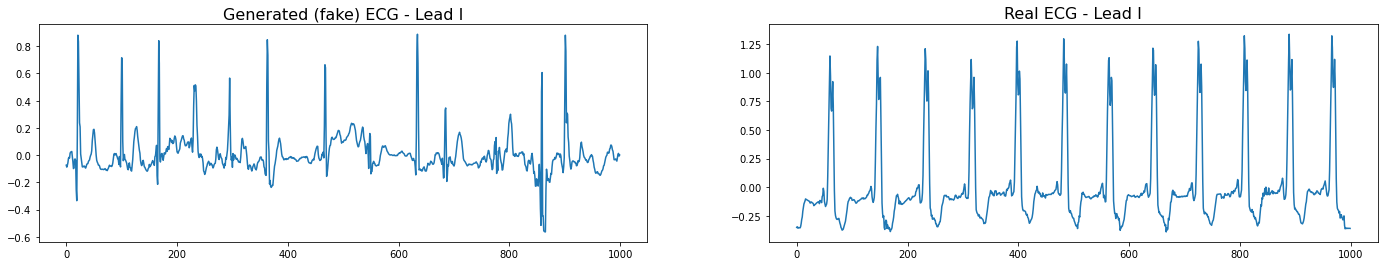

Generator AUROC: 0.0
Generator loss: 0.9003401
Descriminator AUROC: 0.38671875
Descriminator loss: 0.55321324
-------------------
epoch 397
Generator AUROC: 0.0
Generator loss: 0.90035266
Descriminator AUROC: 0.44921875
Descriminator loss: 0.55408114
-------------------
epoch 398
Generator AUROC: 0.0
Generator loss: 0.9003419
Descriminator AUROC: 0.65625
Descriminator loss: 0.55208653
-------------------
epoch 399
Generator AUROC: 0.0
Generator loss: 0.9004027
Descriminator AUROC: 0.5390625
Descriminator loss: 0.5541635
-------------------
epoch 400
Generator AUROC: 0.0
Generator loss: 0.9005111
Descriminator AUROC: 0.41015625
Descriminator loss: 0.5514342
-------------------
epoch 401


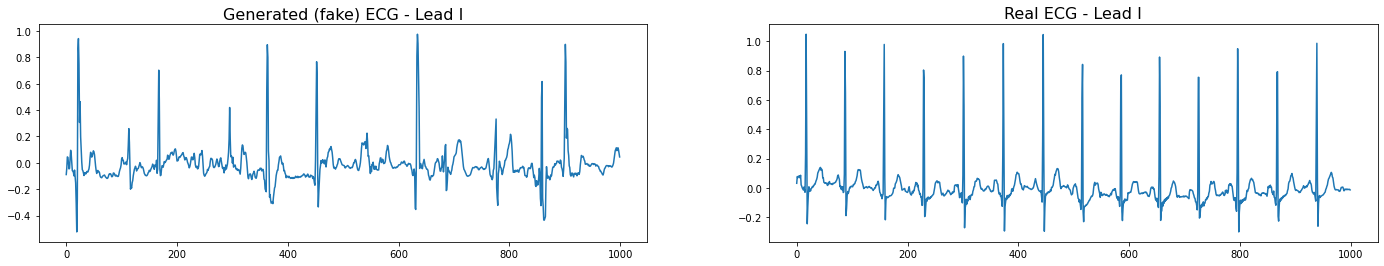

Generator AUROC: 0.0
Generator loss: 0.9003201
Descriminator AUROC: 0.58984375
Descriminator loss: 0.5522117
-------------------
epoch 402
Generator AUROC: 0.0
Generator loss: 0.90048164
Descriminator AUROC: 0.40234375
Descriminator loss: 0.5497212
-------------------
epoch 403
Generator AUROC: 0.0
Generator loss: 0.90039074
Descriminator AUROC: 0.546875
Descriminator loss: 0.55070245
-------------------
epoch 404
Generator AUROC: 0.0
Generator loss: 0.9003026
Descriminator AUROC: 0.40625
Descriminator loss: 0.5529491
-------------------
epoch 405
Generator AUROC: 0.0
Generator loss: 0.9004167
Descriminator AUROC: 0.49609375
Descriminator loss: 0.5502498
-------------------
epoch 406


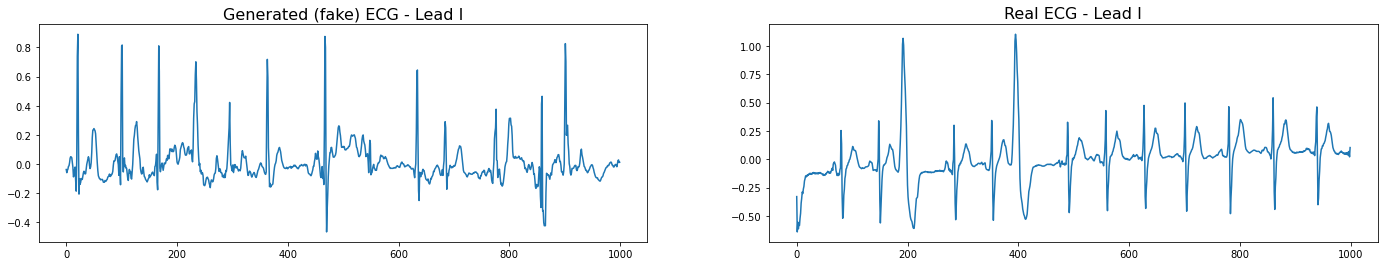

Generator AUROC: 0.0
Generator loss: 0.90027374
Descriminator AUROC: 0.62890625
Descriminator loss: 0.55084217
-------------------
epoch 407
Generator AUROC: 0.0
Generator loss: 0.9002613
Descriminator AUROC: 0.62890625
Descriminator loss: 0.55298686
-------------------
epoch 408
Generator AUROC: 0.0
Generator loss: 0.900471
Descriminator AUROC: 0.6328125
Descriminator loss: 0.5507998
-------------------
epoch 409
Generator AUROC: 0.0
Generator loss: 0.90038365
Descriminator AUROC: 0.5390625
Descriminator loss: 0.5490625
-------------------
epoch 410
Generator AUROC: 0.0
Generator loss: 0.90046716
Descriminator AUROC: 0.5390625
Descriminator loss: 0.55038476
-------------------
epoch 411


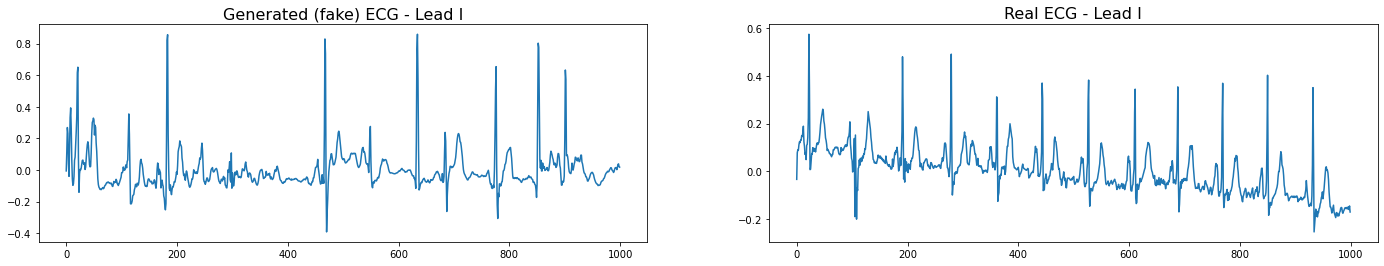

Generator AUROC: 0.0
Generator loss: 0.90045327
Descriminator AUROC: 0.50390625
Descriminator loss: 0.55583173
-------------------
epoch 412
Generator AUROC: 0.0
Generator loss: 0.9004898
Descriminator AUROC: 0.44140625
Descriminator loss: 0.5550136
-------------------
epoch 413
Generator AUROC: 0.0
Generator loss: 0.90038174
Descriminator AUROC: 0.55859375
Descriminator loss: 0.5550917
-------------------
epoch 414
Generator AUROC: 0.0
Generator loss: 0.90060246
Descriminator AUROC: 0.40625
Descriminator loss: 0.554836
-------------------
epoch 415
Generator AUROC: 0.0
Generator loss: 0.9004036
Descriminator AUROC: 0.359375
Descriminator loss: 0.5511093
-------------------
epoch 416


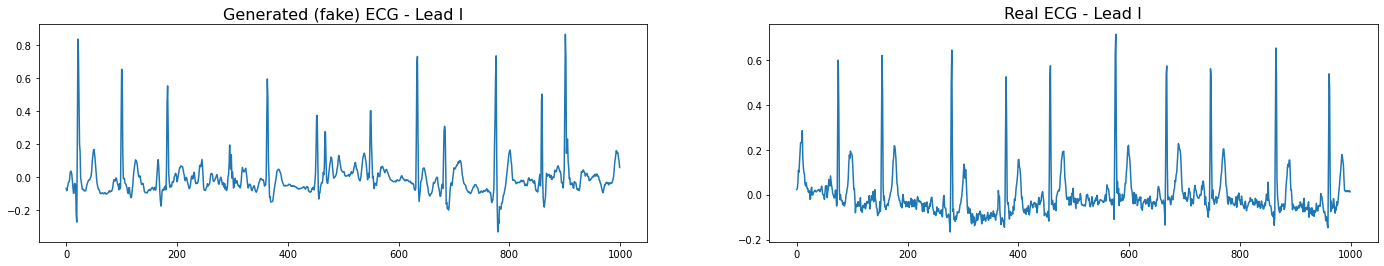

Generator AUROC: 0.0
Generator loss: 0.90046555
Descriminator AUROC: 0.55859375
Descriminator loss: 0.55419356
-------------------
epoch 417
Generator AUROC: 0.0
Generator loss: 0.9005484
Descriminator AUROC: 0.66015625
Descriminator loss: 0.55169106
-------------------
epoch 418
Generator AUROC: 0.0
Generator loss: 0.9004367
Descriminator AUROC: 0.57421875
Descriminator loss: 0.55352926
-------------------
epoch 419
Generator AUROC: 0.0
Generator loss: 0.9004259
Descriminator AUROC: 0.5234375
Descriminator loss: 0.551398
-------------------
epoch 420
Generator AUROC: 0.0
Generator loss: 0.9005168
Descriminator AUROC: 0.52734375
Descriminator loss: 0.551629
-------------------
epoch 421


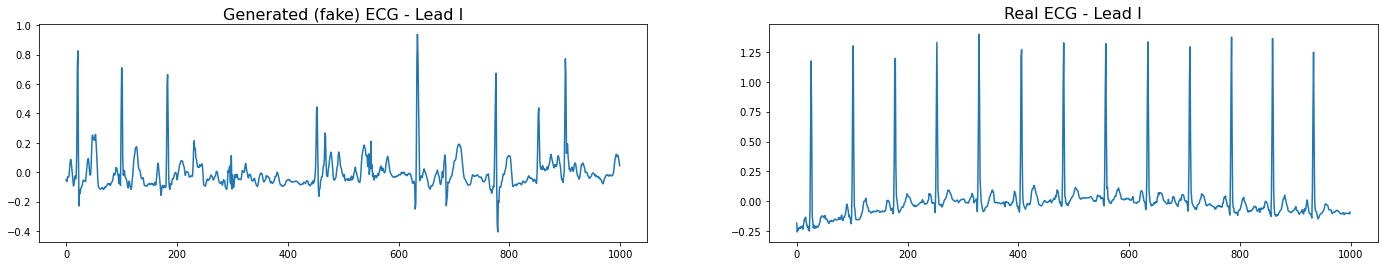

Generator AUROC: 0.0
Generator loss: 0.9003416
Descriminator AUROC: 0.5390625
Descriminator loss: 0.55229384
-------------------
epoch 422
Generator AUROC: 0.0
Generator loss: 0.90043217
Descriminator AUROC: 0.42578125
Descriminator loss: 0.5533112
-------------------
epoch 423
Generator AUROC: 0.0
Generator loss: 0.9003972
Descriminator AUROC: 0.49609375
Descriminator loss: 0.55514294
-------------------
epoch 424
Generator AUROC: 0.0
Generator loss: 0.9003019
Descriminator AUROC: 0.40625
Descriminator loss: 0.55314827
-------------------
epoch 425
Generator AUROC: 0.0
Generator loss: 0.9002612
Descriminator AUROC: 0.36328125
Descriminator loss: 0.5563852
-------------------
epoch 426


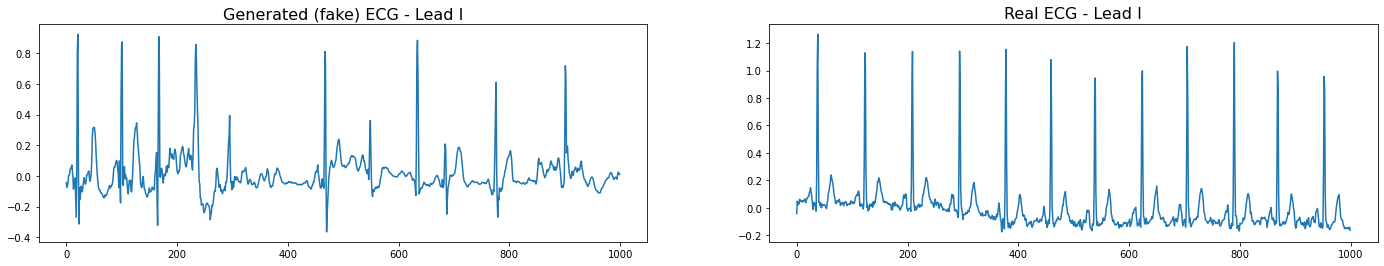

Generator AUROC: 0.0
Generator loss: 0.90036273
Descriminator AUROC: 0.546875
Descriminator loss: 0.5505406
-------------------
epoch 427
Generator AUROC: 0.0
Generator loss: 0.90044415
Descriminator AUROC: 0.37109375
Descriminator loss: 0.55218315
-------------------
epoch 428
Generator AUROC: 0.0
Generator loss: 0.90038025
Descriminator AUROC: 0.5546875
Descriminator loss: 0.55188704
-------------------
epoch 429
Generator AUROC: 0.0
Generator loss: 0.9002748
Descriminator AUROC: 0.7109375
Descriminator loss: 0.55060226
-------------------
epoch 430
Generator AUROC: 0.0
Generator loss: 0.90041745
Descriminator AUROC: 0.421875
Descriminator loss: 0.5547103
-------------------
epoch 431


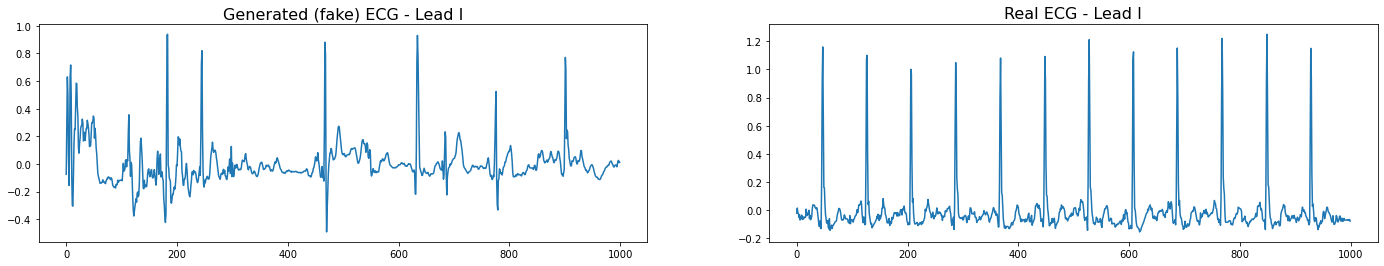

Generator AUROC: 0.0
Generator loss: 0.9005077
Descriminator AUROC: 0.49609375
Descriminator loss: 0.5518227
-------------------
epoch 432
Generator AUROC: 0.0
Generator loss: 0.90047723
Descriminator AUROC: 0.44921875
Descriminator loss: 0.5563991
-------------------
epoch 433
Generator AUROC: 0.0
Generator loss: 0.90038043
Descriminator AUROC: 0.48828125
Descriminator loss: 0.55276304
-------------------
epoch 434
Generator AUROC: 0.0
Generator loss: 0.90041167
Descriminator AUROC: 0.3359375
Descriminator loss: 0.5523731
-------------------
epoch 435
Generator AUROC: 0.0
Generator loss: 0.9005313
Descriminator AUROC: 0.546875
Descriminator loss: 0.5541149
-------------------
epoch 436


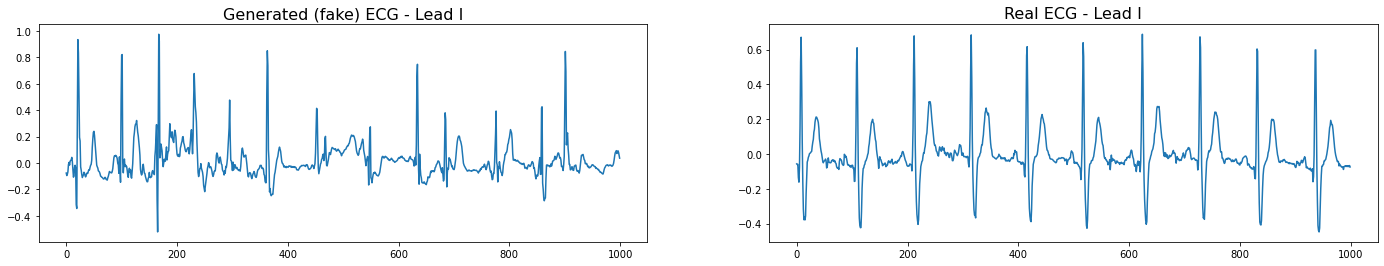

Generator AUROC: 0.0
Generator loss: 0.9004456
Descriminator AUROC: 0.44140625
Descriminator loss: 0.5508624
-------------------
epoch 437
Generator AUROC: 0.0
Generator loss: 0.9004105
Descriminator AUROC: 0.45703125
Descriminator loss: 0.5538032
-------------------
epoch 438
Generator AUROC: 0.0
Generator loss: 0.90052146
Descriminator AUROC: 0.50390625
Descriminator loss: 0.55227137
-------------------
epoch 439
Generator AUROC: 0.0
Generator loss: 0.90043306
Descriminator AUROC: 0.6015625
Descriminator loss: 0.55529815
-------------------
epoch 440
Generator AUROC: 0.0
Generator loss: 0.9004792
Descriminator AUROC: 0.46875
Descriminator loss: 0.5535656
-------------------
epoch 441


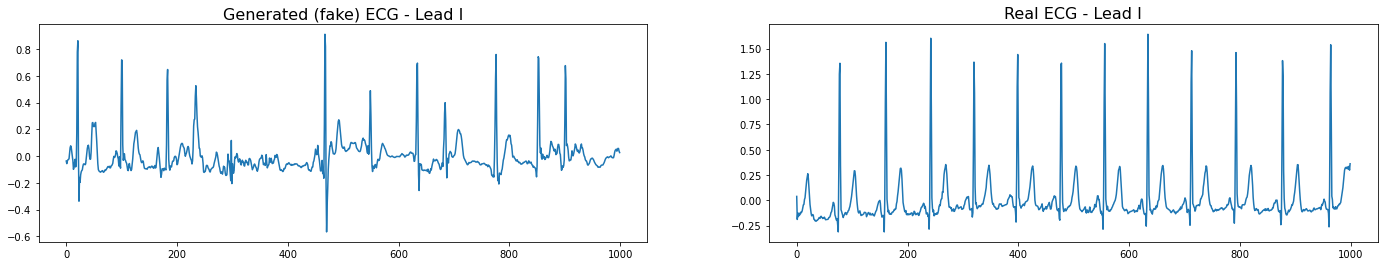

Generator AUROC: 0.0
Generator loss: 0.9003083
Descriminator AUROC: 0.3359375
Descriminator loss: 0.5522954
-------------------
epoch 442
Generator AUROC: 0.0
Generator loss: 0.900401
Descriminator AUROC: 0.453125
Descriminator loss: 0.55414724
-------------------
epoch 443
Generator AUROC: 0.0
Generator loss: 0.90035015
Descriminator AUROC: 0.41796875
Descriminator loss: 0.5522516
-------------------
epoch 444
Generator AUROC: 0.0
Generator loss: 0.90063244
Descriminator AUROC: 0.56640625
Descriminator loss: 0.5537568
-------------------
epoch 445
Generator AUROC: 0.0
Generator loss: 0.9003974
Descriminator AUROC: 0.59765625
Descriminator loss: 0.5546122
-------------------
epoch 446


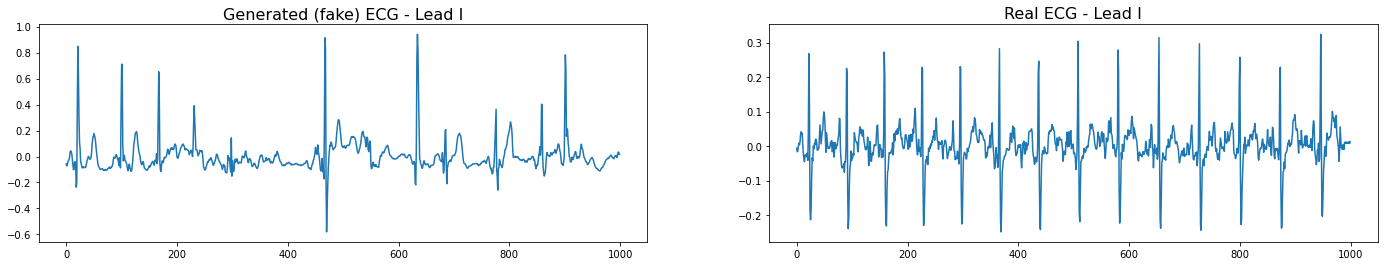

Generator AUROC: 0.0
Generator loss: 0.9004488
Descriminator AUROC: 0.45703125
Descriminator loss: 0.55355895
-------------------
epoch 447
Generator AUROC: 0.0
Generator loss: 0.90039366
Descriminator AUROC: 0.47265625
Descriminator loss: 0.55303293
-------------------
epoch 448
Generator AUROC: 0.0
Generator loss: 0.90051234
Descriminator AUROC: 0.53125
Descriminator loss: 0.5526047
-------------------
epoch 449
Generator AUROC: 0.0
Generator loss: 0.90039164
Descriminator AUROC: 0.5546875
Descriminator loss: 0.552009
-------------------
epoch 450
Generator AUROC: 0.0
Generator loss: 0.900562
Descriminator AUROC: 0.60546875
Descriminator loss: 0.55144536
-------------------
epoch 451


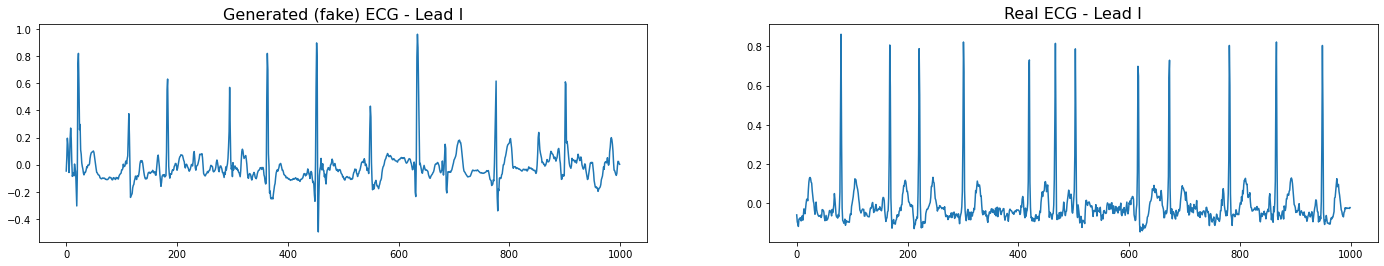

Generator AUROC: 0.0
Generator loss: 0.9003501
Descriminator AUROC: 0.671875
Descriminator loss: 0.552361
-------------------
epoch 452
Generator AUROC: 0.0
Generator loss: 0.90034676
Descriminator AUROC: 0.3359375
Descriminator loss: 0.55430484
-------------------
epoch 453
Generator AUROC: 0.0
Generator loss: 0.900394
Descriminator AUROC: 0.63671875
Descriminator loss: 0.5481569
-------------------
epoch 454
Generator AUROC: 0.0
Generator loss: 0.9004497
Descriminator AUROC: 0.5234375
Descriminator loss: 0.55287087
-------------------
epoch 455
Generator AUROC: 0.0
Generator loss: 0.90034103
Descriminator AUROC: 0.48828125
Descriminator loss: 0.55832475
-------------------
epoch 456


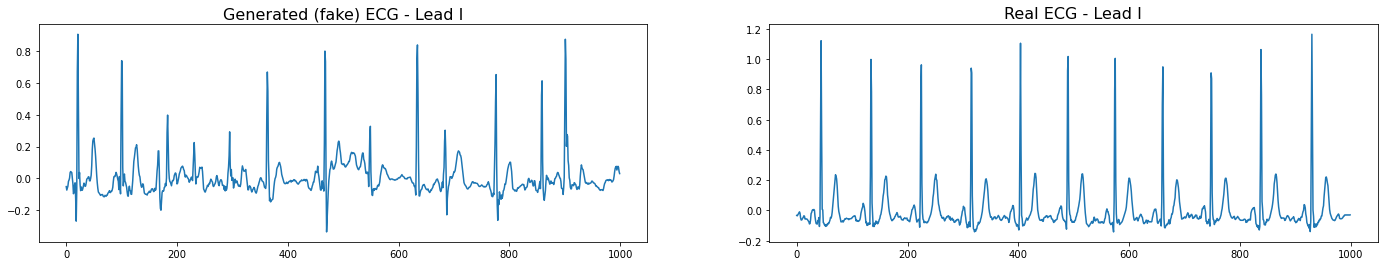

Generator AUROC: 0.0
Generator loss: 0.90055305
Descriminator AUROC: 0.51953125
Descriminator loss: 0.55180514
-------------------
epoch 457
Generator AUROC: 0.0
Generator loss: 0.9002902
Descriminator AUROC: 0.46484375
Descriminator loss: 0.55554605
-------------------
epoch 458
Generator AUROC: 0.0
Generator loss: 0.9003226
Descriminator AUROC: 0.59375
Descriminator loss: 0.5529414
-------------------
epoch 459
Generator AUROC: 0.0
Generator loss: 0.90037435
Descriminator AUROC: 0.6015625
Descriminator loss: 0.5538134
-------------------
epoch 460
Generator AUROC: 0.0
Generator loss: 0.9004028
Descriminator AUROC: 0.57421875
Descriminator loss: 0.5495861
-------------------
epoch 461


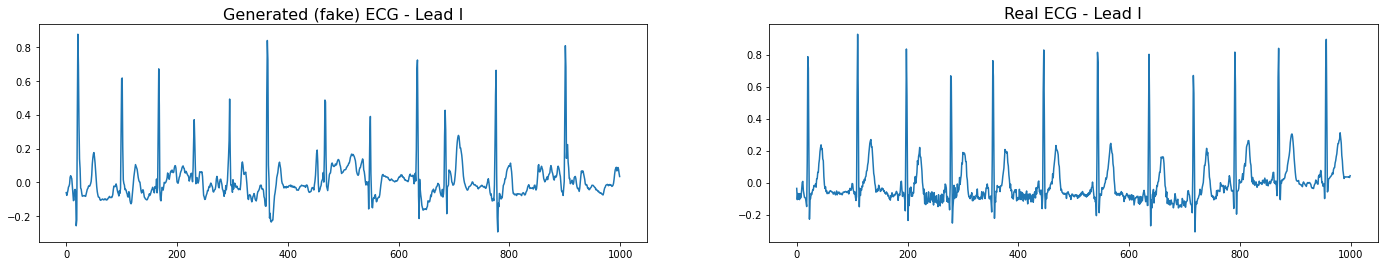

Generator AUROC: 0.0
Generator loss: 0.9003869
Descriminator AUROC: 0.5
Descriminator loss: 0.5524198
-------------------
epoch 462
Generator AUROC: 0.0
Generator loss: 0.90040404
Descriminator AUROC: 0.5546875
Descriminator loss: 0.55296683
-------------------
epoch 463
Generator AUROC: 0.0
Generator loss: 0.9004558
Descriminator AUROC: 0.5
Descriminator loss: 0.5561835
-------------------
epoch 464
Generator AUROC: 0.0
Generator loss: 0.900364
Descriminator AUROC: 0.33984375
Descriminator loss: 0.55315316
-------------------
epoch 465
Generator AUROC: 0.0
Generator loss: 0.9004642
Descriminator AUROC: 0.70703125
Descriminator loss: 0.551666
-------------------
epoch 466


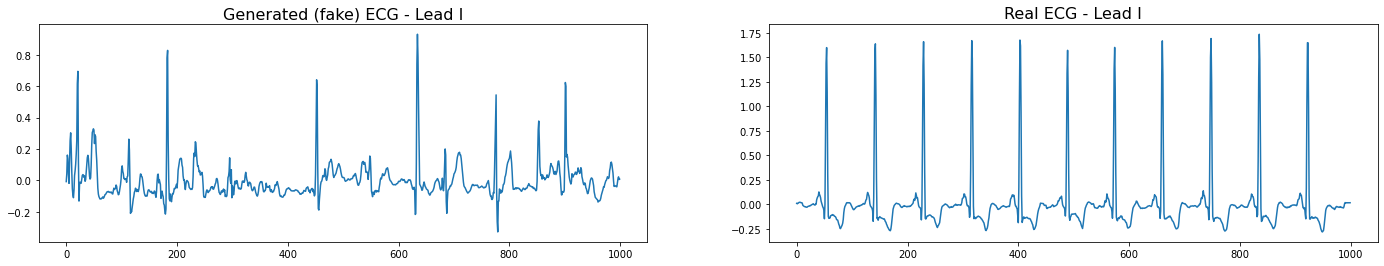

Generator AUROC: 0.0
Generator loss: 0.9001574
Descriminator AUROC: 0.51171875
Descriminator loss: 0.552269
-------------------
epoch 467
Generator AUROC: 0.0
Generator loss: 0.9003085
Descriminator AUROC: 0.48046875
Descriminator loss: 0.5538868
-------------------
epoch 468
Generator AUROC: 0.0
Generator loss: 0.900499
Descriminator AUROC: 0.4140625
Descriminator loss: 0.54676723
-------------------
epoch 469
Generator AUROC: 0.0
Generator loss: 0.90029174
Descriminator AUROC: 0.4609375
Descriminator loss: 0.5535437
-------------------
epoch 470
Generator AUROC: 0.0
Generator loss: 0.90040773
Descriminator AUROC: 0.55859375
Descriminator loss: 0.5565028
-------------------
epoch 471


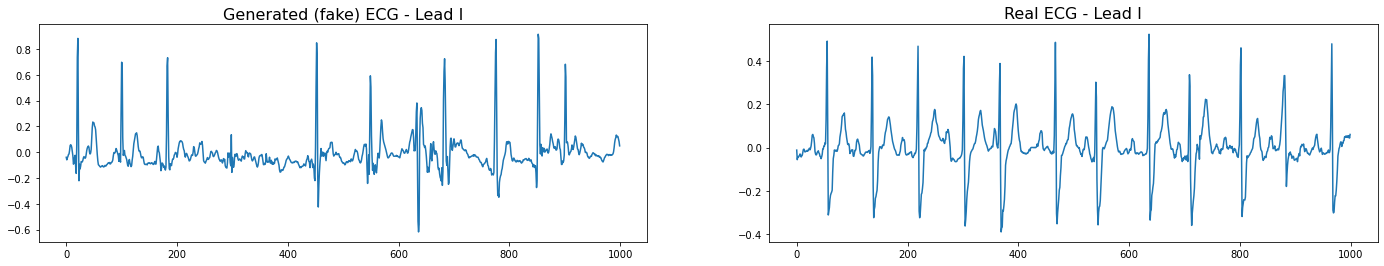

Generator AUROC: 0.0
Generator loss: 0.90045846
Descriminator AUROC: 0.640625
Descriminator loss: 0.55482113
-------------------
epoch 472
Generator AUROC: 0.0
Generator loss: 0.9004751
Descriminator AUROC: 0.578125
Descriminator loss: 0.5501351
-------------------
epoch 473
Generator AUROC: 0.0
Generator loss: 0.90047616
Descriminator AUROC: 0.578125
Descriminator loss: 0.55164325
-------------------
epoch 474
Generator AUROC: 0.0
Generator loss: 0.9003626
Descriminator AUROC: 0.5
Descriminator loss: 0.5519663
-------------------
epoch 475
Generator AUROC: 0.0
Generator loss: 0.9004479
Descriminator AUROC: 0.58984375
Descriminator loss: 0.55258733
-------------------
epoch 476


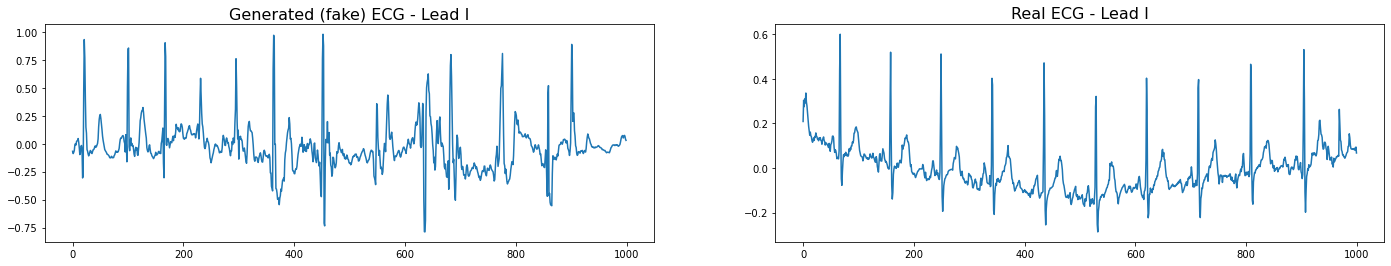

Generator AUROC: 0.0
Generator loss: 0.9003676
Descriminator AUROC: 0.59765625
Descriminator loss: 0.5503483
-------------------
epoch 477
Generator AUROC: 0.0
Generator loss: 0.9005661
Descriminator AUROC: 0.5703125
Descriminator loss: 0.55627
-------------------
epoch 478
Generator AUROC: 0.0
Generator loss: 0.90024966
Descriminator AUROC: 0.4296875
Descriminator loss: 0.55768126
-------------------
epoch 479
Generator AUROC: 0.0
Generator loss: 0.9004067
Descriminator AUROC: 0.484375
Descriminator loss: 0.55853516
-------------------
epoch 480
Generator AUROC: 0.0
Generator loss: 0.9002231
Descriminator AUROC: 0.46875
Descriminator loss: 0.55522233
-------------------
epoch 481


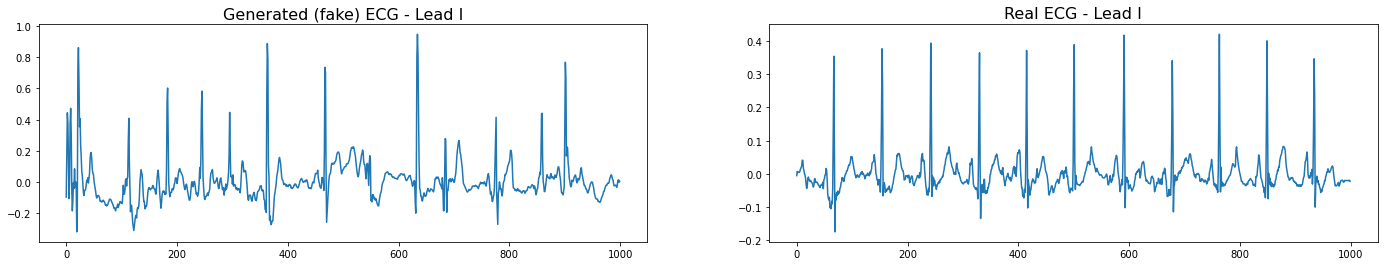

Generator AUROC: 0.0
Generator loss: 0.90044844
Descriminator AUROC: 0.2265625
Descriminator loss: 0.5527897
-------------------
epoch 482
Generator AUROC: 0.0
Generator loss: 0.9004247
Descriminator AUROC: 0.4140625
Descriminator loss: 0.5522832
-------------------
epoch 483
Generator AUROC: 0.0
Generator loss: 0.9003397
Descriminator AUROC: 0.546875
Descriminator loss: 0.5545025
-------------------
epoch 484
Generator AUROC: 0.0
Generator loss: 0.90052056
Descriminator AUROC: 0.6875
Descriminator loss: 0.55260515
-------------------
epoch 485
Generator AUROC: 0.0
Generator loss: 0.900304
Descriminator AUROC: 0.296875
Descriminator loss: 0.5554776
-------------------
epoch 486


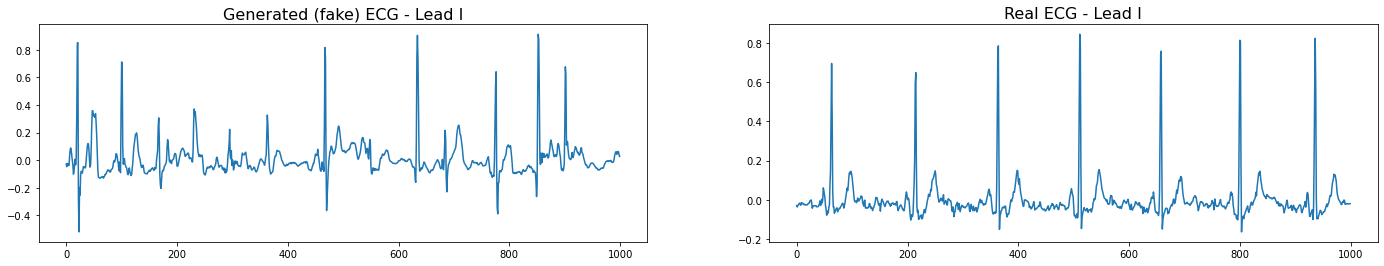

Generator AUROC: 0.0
Generator loss: 0.9002361
Descriminator AUROC: 0.4765625
Descriminator loss: 0.5523455
-------------------
epoch 487
Generator AUROC: 0.0
Generator loss: 0.90028566
Descriminator AUROC: 0.78125
Descriminator loss: 0.5527688
-------------------
epoch 488
Generator AUROC: 0.0
Generator loss: 0.90036666
Descriminator AUROC: 0.578125
Descriminator loss: 0.5503684
-------------------
epoch 489
Generator AUROC: 0.0
Generator loss: 0.9003155
Descriminator AUROC: 0.46875
Descriminator loss: 0.55173445
-------------------
epoch 490
Generator AUROC: 0.0
Generator loss: 0.9004923
Descriminator AUROC: 0.49609375
Descriminator loss: 0.5540422
-------------------
epoch 491


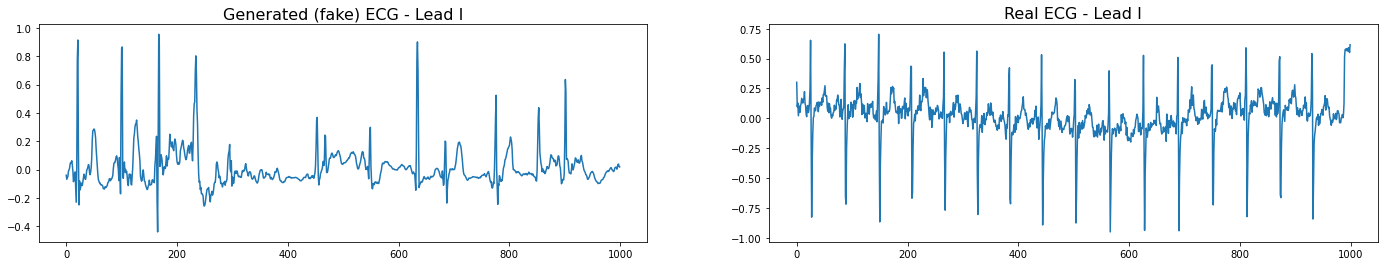

Generator AUROC: 0.0
Generator loss: 0.9004054
Descriminator AUROC: 0.68359375
Descriminator loss: 0.5525916
-------------------
epoch 492
Generator AUROC: 0.0
Generator loss: 0.90039724
Descriminator AUROC: 0.6015625
Descriminator loss: 0.553139
-------------------
epoch 493
Generator AUROC: 0.0
Generator loss: 0.9003473
Descriminator AUROC: 0.515625
Descriminator loss: 0.5554106
-------------------
epoch 494
Generator AUROC: 0.0
Generator loss: 0.9005106
Descriminator AUROC: 0.4921875
Descriminator loss: 0.55508244
-------------------
epoch 495
Generator AUROC: 0.0
Generator loss: 0.90026766
Descriminator AUROC: 0.61328125
Descriminator loss: 0.5519778
-------------------
epoch 496


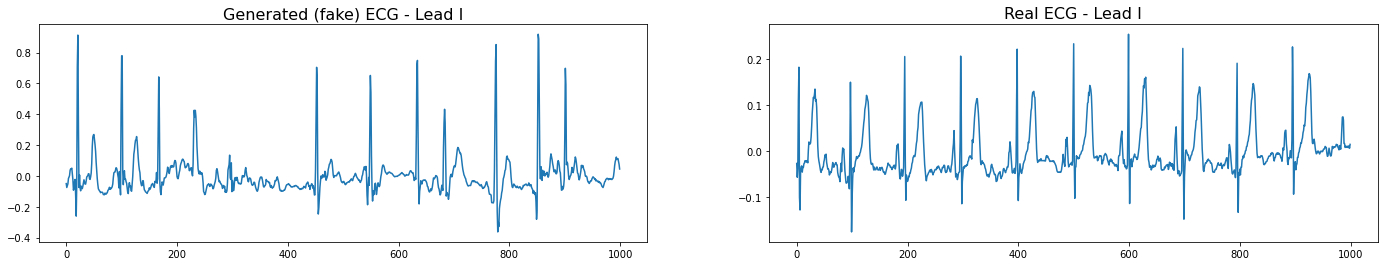

Generator AUROC: 0.0
Generator loss: 0.9004593
Descriminator AUROC: 0.48828125
Descriminator loss: 0.55031085
-------------------
epoch 497
Generator AUROC: 0.0
Generator loss: 0.90041417
Descriminator AUROC: 0.44140625
Descriminator loss: 0.55470514
-------------------
epoch 498
Generator AUROC: 0.0
Generator loss: 0.9004037
Descriminator AUROC: 0.2265625
Descriminator loss: 0.55298746
-------------------
epoch 499
Generator AUROC: 0.0
Generator loss: 0.9003872
Descriminator AUROC: 0.515625
Descriminator loss: 0.55489194
-------------------


In [13]:
batch_size=32
latent_dim=12
steps = len(ECGs)//32
half_batch = batch_size // 2
epochs = 500
#gen = generator()
#desc = discriminator()
init_lr_desc = 0.0002
init_lr_gen = 0.0004
opt_desc = tf.keras.optimizers.Adam(learning_rate=init_lr_desc,beta_1=0.5, beta_2=0.9)
opt_gen = tf.keras.optimizers.Adam(learning_rate=init_lr_gen,beta_1=0.5, beta_2=0.9)
print("Before training:")
res = gen(generate_latent_points(12,1))
compare_real_and_gen_ecg(res)
print("-------------------")
for epoch in range(epochs):
    if epoch % 5 == True:
        init_lr_desc = init_lr_desc/2
        init_lr_gen = init_lr_gen/2
        opt_desc.lr = init_lr_desc
        opt_gen.lr = init_lr_gen
    accu_loss_gan = []
    accu_loss_desc = []
    print("epoch {}".format(epoch))
    for step in range(steps):
        x_real, y_real = generate_real_samples(ECGs,half_batch)
        x_fake, y_fake = generate_fake_samples(latent_dim,gen,half_batch)
        X_train = np.vstack([x_real,x_fake])
        y_train = np.vstack([y_real,y_fake])
        p = np.random.permutation(len(y_train)) #shuffle

        with tf.GradientTape() as tape:
            pred_desc = desc(X_train[p])
            loss_desc = tf.keras.losses.binary_crossentropy(y_train[p], pred_desc)
        accu_loss_desc.append(loss_desc)
        grads = tape.gradient(loss_desc, desc.trainable_variables)
        opt_desc.apply_gradients(zip(grads, desc.trainable_variables))
        

        with tf.GradientTape() as tape:
            x_latent = generate_latent_points(latent_dim,batch_size)
            x_gan = gen(x_latent)
            y_gan = np.ones((batch_size, 1))
            pred_gan = desc(x_gan)
            loss_gan = tf.keras.losses.binary_crossentropy(y_gan, pred_gan)
        accu_loss_gan.append(loss_gan)
        grads = tape.gradient(loss_gan, gen.trainable_variables)
        opt_gen.apply_gradients(zip(grads, gen.trainable_variables))
        #summarize_performance(1,gen, desc, latent_dim, ECGs)
    if epoch % 5 == True:
        res = gen(generate_latent_points(12,1))
        compare_real_and_gen_ecg(res)
    print("Generator AUROC:", roc_auc_score(np.concatenate([y_gan.ravel(),np.array([0])]),np.concatenate([np.asarray(pred_gan).ravel(),np.array([0.5])])))
    print("Generator loss:", np.mean(np.asarray(accu_loss_gan)))
    print("Descriminator AUROC:", roc_auc_score(y_train.ravel(),np.asarray(pred_desc).ravel()))   
    print("Descriminator loss:", np.mean(np.asarray(accu_loss_desc)))
    print("-------------------")

In [14]:
gen.save_weights("generator_weights_round2.h5")

In [15]:
desc.save_weights("descriminator_weights_round2.h5")